# GLM, Neural Network and Gradient Boosting for Insurance Pricing: Claim Frequency Modeling

by Daniel König and Friedrich Loser. Version 3, March 2024

What are the benefits of machine learning techniques for motor insurance pricing? To answer this question, the claims frequency for a large French motor third party liability insurance portfolio is modeled and predicted using classical and machine learning methods. There are several changes compared to version 2 (2020): The claims data is cleaned, the Poisson deviation is weighted. GLMs are supplemented by regularization and Generalized Additive Models (GAM). In gradient tree boosting (GBM), XGBoost is challenged by CatBoost and LightGBM and explainability is addressed with SHAP. 

It is shown that both neural networks and GBMs can at least be used to improve classical models, while GAMs perform better than GLMs. Furthermore, the GBMs are shown to be the superior forecasting models, even when monotone constraints are applied to account for plausible tariff structures. Finally, we recommend considering LightGBM and GAMs when modeling similar data.

This R notebook is linked to a current Python notebook https://www.kaggle.com/code/floser/use-case-claim-frequency-modeling-python and uses hyperparameter optimization results.

## Table of Contents
1. [Data Exploration and Preparations](#ch1)
2. [Classics: GLMs, GAMs and Regularization](#ch2)
3. [Gradient Boosting and Explainability](#ch3)
4. [Deep Learning Approach with Embeddings and the "CANN"](#ch4)
5. [Back to GLM and GAM: Interactions](#ch5)
6. [Cross Validation and Boxplots: Results](#ch6)
7. [Summary](#ch7)

<a id="ch1"></a>
# 1. Data Exploration and Preparations

## 1.1 Load, correct and inspect data

We analyse data for motor third party liability claims (MTPL) in France. The data is available via the R library CASdatasets by Christophe Dutang. The specific datasets are called FreMTPL2freq and FreMTPL2sev. The former contains the information on the insurance policy and claims frequency and the latter the corresponding information on claims severity.

The claim counts on the insurance policies with policy IDs ≤ 24500 in the dataset FreMTPL2freq do not have claim severity counterparts in the dataset FreMTPL2sev and thus seem not to be correct. For this reason we work with the claim counts extracted from FreMTPL2sev. More details can be found here (https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev) and in Chapter 13.1 of "Statistical Foundations of Actuarial Learning and its Applications" by Mario Wüthrich and Michael Merz (open-access book, 2023).

In [1]:
# Remark: All necessary libraries are pre-installed on Kaggle. We call them directly before usage 

dat <- read.csv("../input/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv",
                header=TRUE, stringsAsFactors = TRUE)

# inspect data set
dim(dat)  # count rows and colums
head(dat) # show first few policies

[1] 678013     12

IDpol ClaimNb Exposure Area VehPower VehAge DrivAge BonusMalus VehBrand
1  1    1       0.10     D    5        0      55      50         B12     
2  3    1       0.77     D    5        0      55      50         B12     
3  5    1       0.75     B    6        2      52      50         B12     
4 10    1       0.09     B    7        0      46      50         B12     
5 11    1       0.84     B    7        0      46      50         B12     
6 13    1       0.52     E    6        2      38      50         B12     
  VehGas  Density Region
1 Regular 1217    R82   
2 Regular 1217    R82   
3 Diesel    54    R22   
4 Diesel    76    R72   
5 Diesel    76    R72   
6 Regular 3003    R31

In [2]:
# new: take claim number from severity file (see https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev)
sev <- read.csv("../input/fremtpl2sev/freMTPL2sev.csv")
sev$ClaimNb <- 1
sev_agg <- aggregate(sev,by=list(IDpol=sev$IDpol),FUN = sum)[c("IDpol","ClaimNb")]
# checks, sums and counts
head(sev_agg)

IDpol ClaimNb
1 139   1      
2 190   1      
3 414   1      
4 424   2      
5 463   1      
6 606   1

In [3]:
# left join with claims frequency data (exposures, features and without questionable ClaimNb). 
dat <- merge(x=dat[,-2], y=sev_agg, by="IDpol", all.x=TRUE)
dat[is.na(dat)] <- 0

# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
dat$ClaimNb  <- pmin(dat$ClaimNb,4)   
dat$Exposure <- pmin(dat$Exposure,1) 

# new: further data preparations
dat$DrivAge  <- pmin(dat$DrivAge,90)   
dat$VehAge  <- pmin(dat$VehAge,40)   

# show summary statistics 
summary(dat) 

     IDpol            Exposure        Area          VehPower     
 Min.   :      1   Min.   :0.002732   A:103957   Min.   : 4.000  
 1st Qu.:1157951   1st Qu.:0.180000   B: 75459   1st Qu.: 5.000  
 Median :2272152   Median :0.490000   C:191880   Median : 6.000  
 Mean   :2621857   Mean   :0.528545   D:151596   Mean   : 6.455  
 3rd Qu.:4046274   3rd Qu.:0.990000   E:137167   3rd Qu.: 7.000  
 Max.   :6114330   Max.   :1.000000   F: 17954   Max.   :15.000  
                                                                 
     VehAge          DrivAge       BonusMalus        VehBrand     
 Min.   : 0.000   Min.   :18.0   Min.   : 50.00   B12    :166024  
 1st Qu.: 2.000   1st Qu.:34.0   1st Qu.: 50.00   B1     :162736  
 Median : 6.000   Median :44.0   Median : 50.00   B2     :159861  
 Mean   : 7.037   Mean   :45.5   Mean   : 59.76   B3     : 53395  
 3rd Qu.:11.000   3rd Qu.:55.0   3rd Qu.: 64.00   B5     : 34753  
 Max.   :40.000   Max.   :90.0   Max.   :230.00   B6     : 28548  
   

## 1.2 A glimpse on exposures and claim frequencies
To get a first impression of claim frequencies, important features and their interactions, we start our analysis with a small binary decision tree of depth 3.

In [4]:
library(rpart) # "Recursive partitioning for classification, regression and survival trees". Default metric: Gini impurity
tree <- rpart(cbind(Exposure,ClaimNb) ~ Area + VehPower + VehAge + DrivAge 
              + BonusMalus + VehBrand + VehGas + Density + Region, dat, 
              method="poisson", control=rpart.control(maxdepth=3,cp=0.001))      
#            complexity-parameter cp is used to control the number of splits 

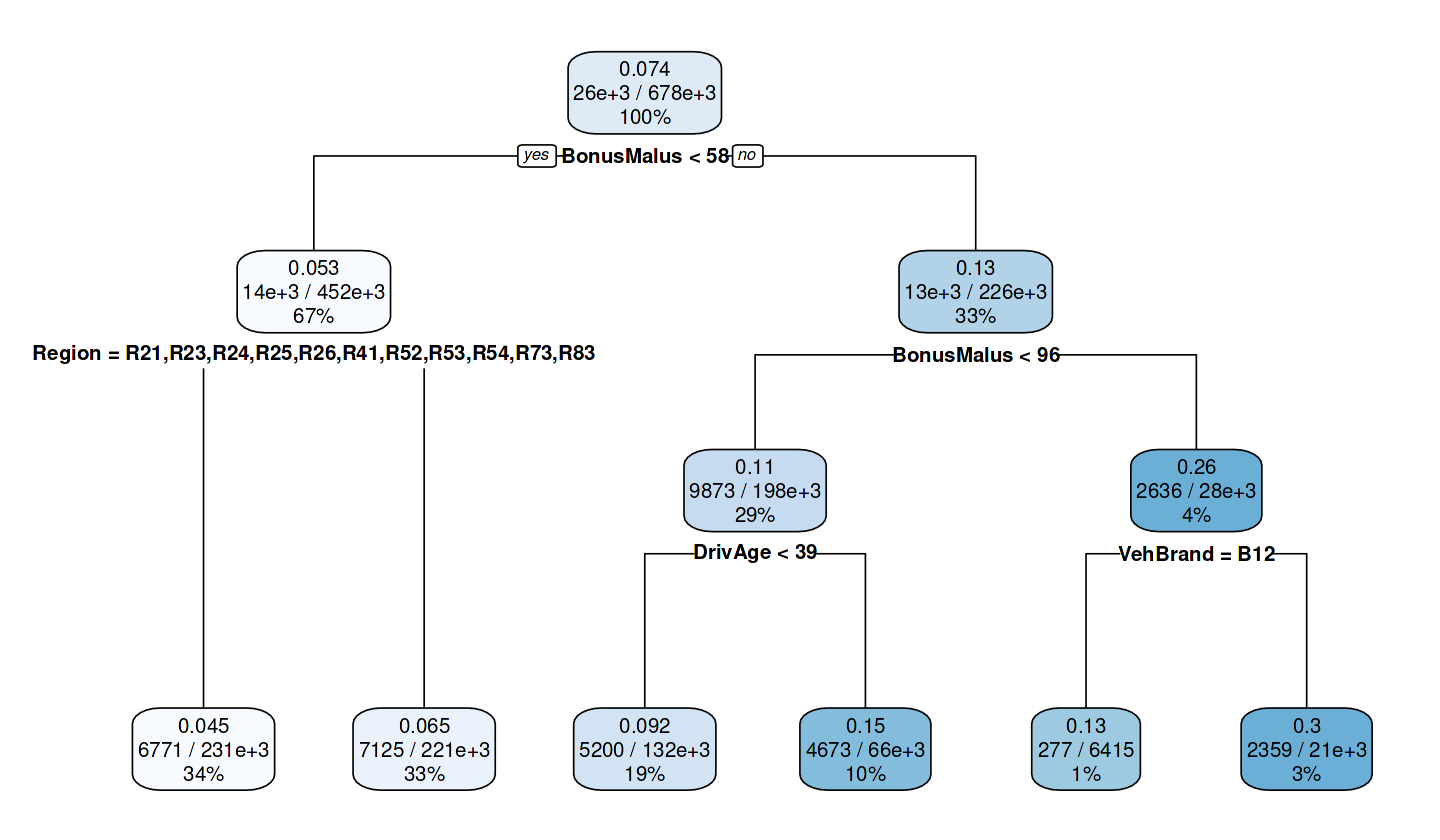

In [5]:
library(repr) # Scale plot size:
options(repr.plot.width=12, repr.plot.height = 7)

library(rpart.plot)
rpart.plot(tree) # display decision tree

The first line in the root node indicates the overall 7.4% claim frequency, the second line #claims / #exposure and the third line the exposure-proportion, which is 100% at the root node.

The root node is split (metric: gini impurity) into two more homogeneous groups by "BonusMalus < 58". Insurance policies that meet this condition are shown on the left. This applies to 67% of the policies that have a claims frequency of 5.3%. In contrast, the claim frequency on the right-hand side of the decision tree is 13% and rises to 26% in the next split if the bonus-malus level is 96 or higher.

This small decision tree divides the data set into six more homogeneous groups with a claim frequency of 4.5% to 30%. Compared to version 2 of this notebook, the remarkable segment with a claim frequency of 66% is now missing, which is due to the claim data cleansing carried out above. This will have a significant impact on the results later on.

## 1.3 Explorative data analysis

In this section we try to get more insight into the data. We use some functions of the R-"Tidyverse" and the pipe operator %>% to make the code more readable.




In [6]:
#library(tidyverse) # work quietly:
suppressMessages(library(tidyverse))

#### a) 1.3.1 Car brand, car age and fuel
As in version 2, we first consider the claim frequencies depending on car brand, car age and fuel for groups with a minimum exposure of 100. 

`summarise()` has grouped output by 'VehBrand', 'VehAgeS'. You can override
using the `.groups` argument.


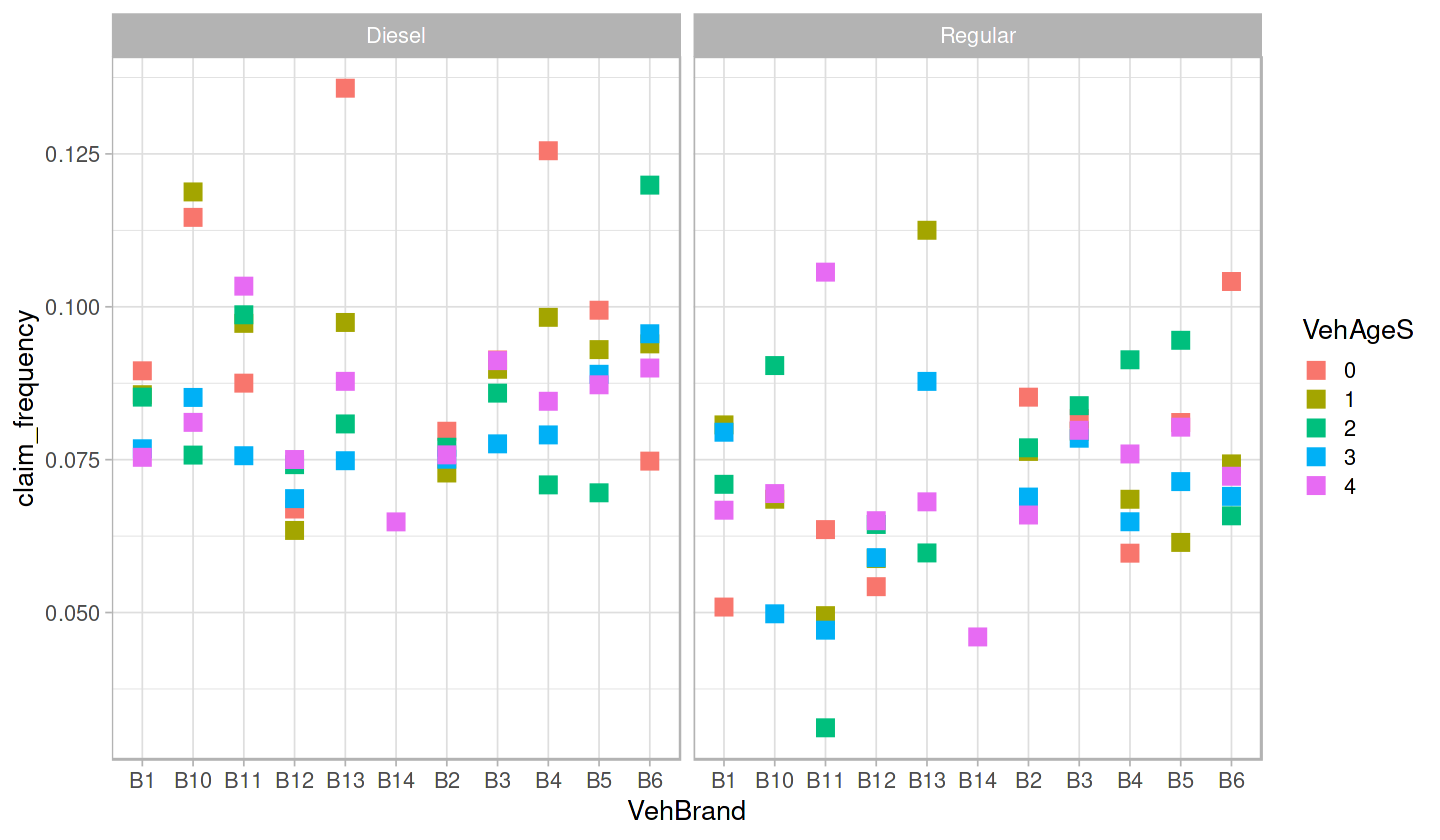

In [7]:
# To focus on new car effects, all cars from the age of four belong to the same group in the following plot:
dat %>% 
  mutate(VehAgeS=as.factor(pmin(VehAge, 4))) %>% 
  group_by(VehBrand,VehAgeS,VehGas) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure), expo=sum(Exposure)) %>% 
  filter(expo>=100)  %>% 
  ggplot(aes(x=VehBrand, y=claim_frequency, color=VehAgeS)) + 
  facet_grid(. ~ VehGas) + 
  geom_point(size=5,shape=15) + theme_light(base_size = 16)

We can see that the previously extremely high claim frequency for non-diesel new B12 cars is now actually below average. This is due to the data cleansing mentioned above.

#### b) Car age and BonusMalus
Next we look at interactions of vehicle age and Bonus-Malus-ranges (deductible). The data are filtered to avoid the new-car-effects of car brand B12 and very small groups with BonusMalus greater than 125%. To avoid noisy effects of very small groups all cars from the age of twenty belong to the same group. 

`summarise()` has grouped output by 'VehAge'. You can override using the
`.groups` argument.
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


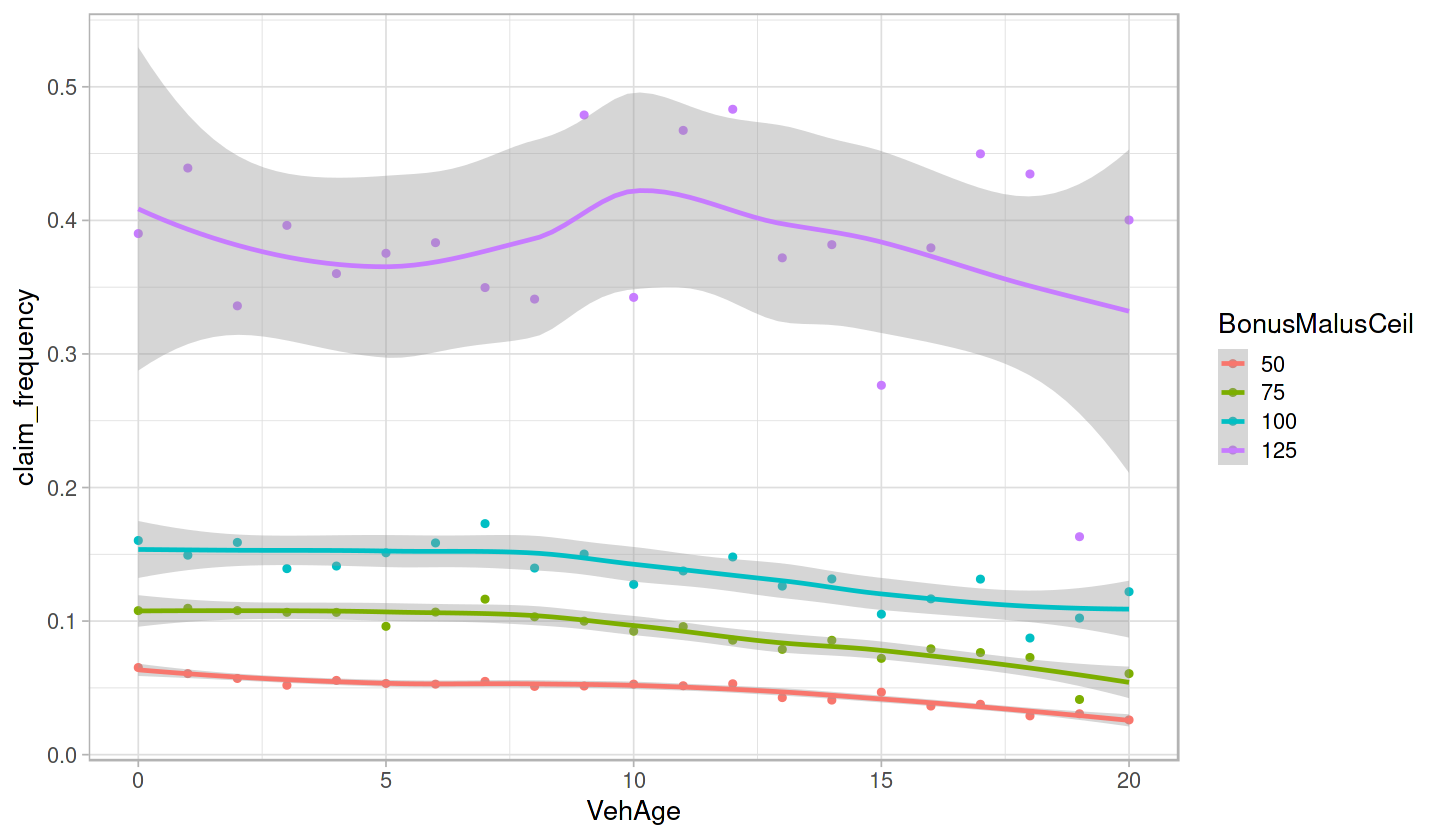

In [8]:
dat %>% 
  filter(VehBrand!='B12' & BonusMalus<=125)  %>% 
  mutate(VehAge=pmin(VehAge,20),
         BonusMalusCeil=as.factor(ceiling(BonusMalus/25)*25)) %>% 
  group_by(VehAge,BonusMalusCeil) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure)) %>% 
  ggplot(aes(x=VehAge, y=claim_frequency, color=BonusMalusCeil)) + 
  geom_point() + geom_smooth() + theme_light(base_size = 16)

#### c) Driver age and BonusMalus
There might also be effects of driver age and Bonus-Malus. To avoid noisy effects of very small groups policies with BonusMalus>125 are excluded, driver age is grouped in five-year steps, all driver from the age of 85 belong to the same group and all cars from the age of twenty belong to the same group. 

`summarise()` has grouped output by 'DrivAge'. You can override using the
`.groups` argument.
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


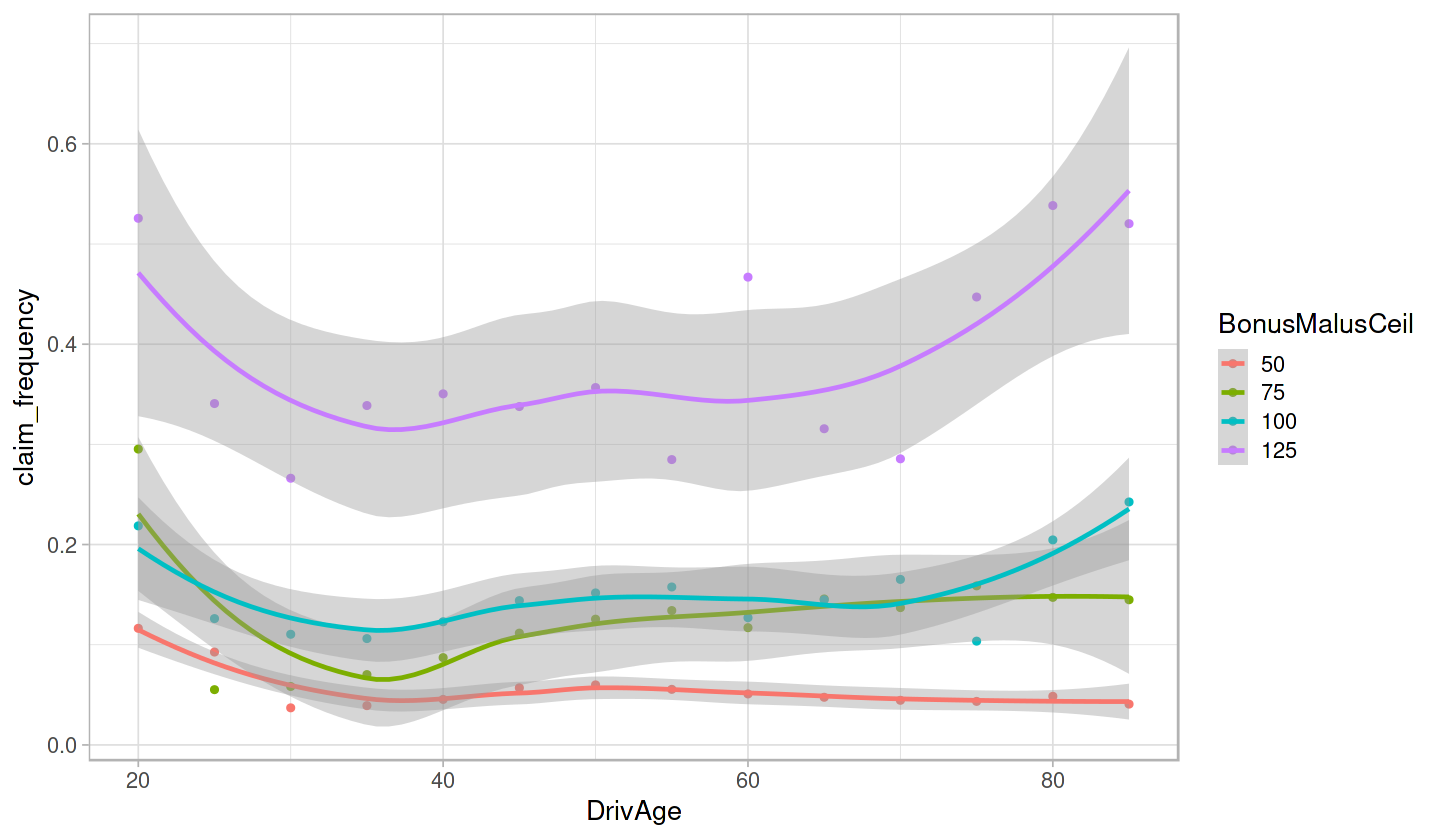

In [9]:
# To avoid noisy effects of very small groups we limit the on BonusMalus up to 125% driver age is grouped in five-year steps. 
# Further all driver from the age of 85 belong to the same group. 
dat %>% 
  filter(BonusMalus<=125)  %>% 
  mutate(DrivAge=ceiling(pmin(DrivAge,85)/5)*5,
         BonusMalusCeil=as.factor(ceiling(BonusMalus/25)*25)) %>% 
  group_by(DrivAge,BonusMalusCeil) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure)) %>% 
  ggplot(aes(x=DrivAge, y=claim_frequency, color=BonusMalusCeil)) + 
  geom_point() + geom_smooth() + theme_light(base_size = 16)

It could also be interesting to investigate this interaction via the number of claims in a violin plot:

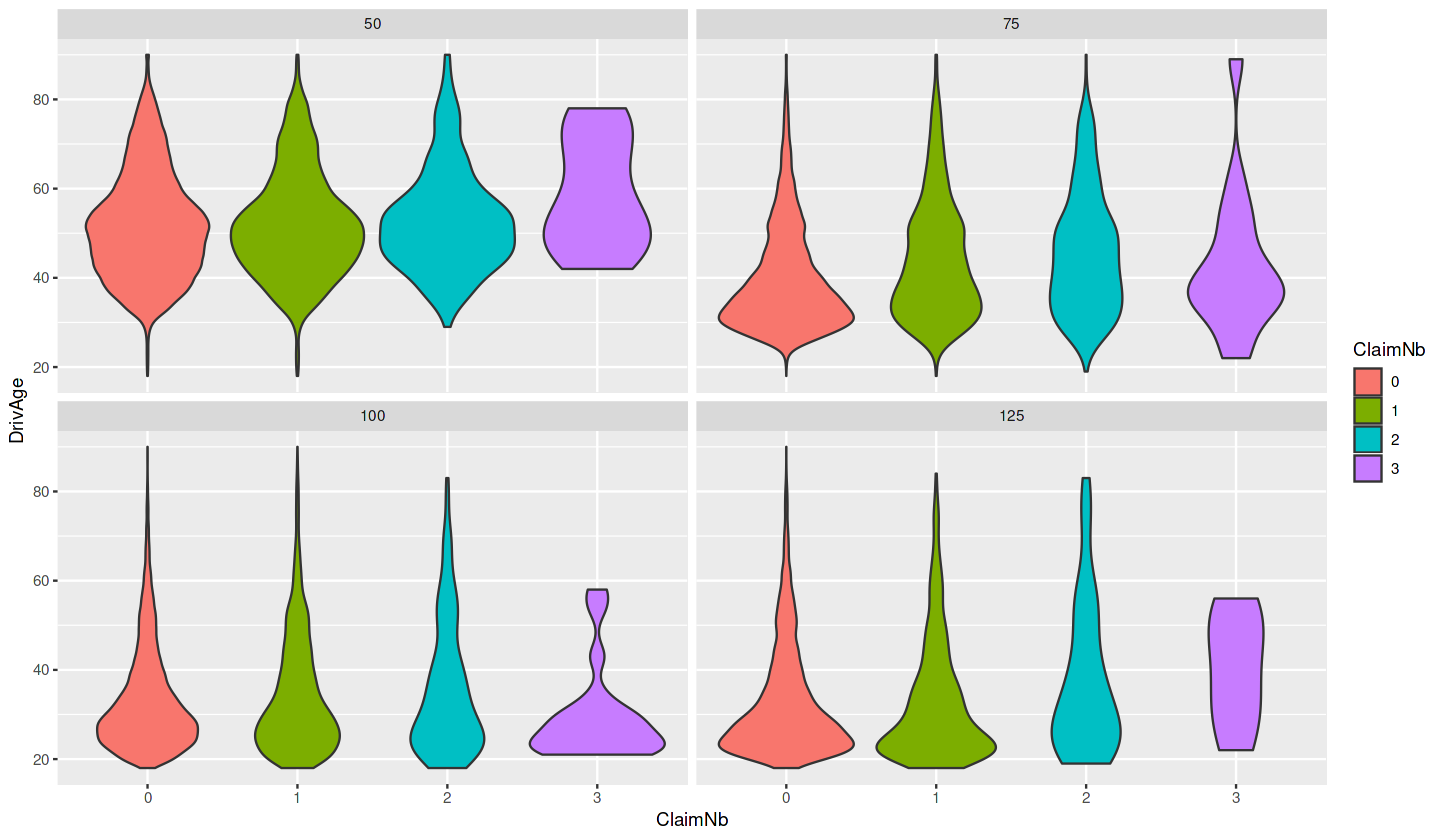

In [10]:
# Violin plot DrivAge vs number of claims for BonusMalus-groups:
dat %>% filter(ClaimNb<4 & BonusMalus<=125) %>% 
  mutate(BonusMalusCeil=as.factor(ceiling(BonusMalus/25)*25), 
         ClaimNb=as.factor(ClaimNb)) %>% 
  ggplot(aes(ClaimNb, DrivAge)) + 
  geom_violin(aes(fill = ClaimNb)) +
  facet_wrap(~BonusMalusCeil)


The most striking is the different age distribution of the drivers with three claims, but this group is very small, see the following table:

In [11]:
# View distribution of all claims 
table(dat$ClaimNb)


     0      1      2      3      4 
653069  23571   1298     62     13 

## 1.4 Feature preprocessing for GLM
We perform the feature preprocessing according to Schelldorfer and Wüthrich (2019):

In [12]:
dat1 <- dat
dat1$AreaGLM <- as.integer(dat1$Area)
dat1$VehPowerGLM <- as.factor(pmin(dat1$VehPower,9))
VehAgeGLM <- cbind(c(0:110), c(1, rep(2,10), rep(3,100)))
dat1$VehAgeGLM <- as.factor(VehAgeGLM[dat1$VehAge+1,2])
dat1[,"VehAgeGLM"] <-relevel(dat1[,"VehAgeGLM"], ref="2")
DrivAgeGLM <- cbind(c(18:100), c(rep(1,21-18), rep(2,26-21), rep(3,31-26), rep(4,41-31), rep(5,51-41), rep(6,71-51), rep(7,101-71)))
dat1$DrivAgeGLM <- as.factor(DrivAgeGLM[dat1$DrivAge-17,2])
dat1[,"DrivAgeGLM"] <-relevel(dat1[,"DrivAgeGLM"], ref="5")
dat1$BonusMalusGLM <- as.integer(pmin(dat1$BonusMalus, 150))
dat1$DensityGLM <- as.numeric(log(dat1$Density))
dat1[,"Region"] <-relevel(dat1[,"Region"], ref="R24")
head(dat1) # show first few policies and generated features

IDpol Exposure Area VehPower VehAge DrivAge BonusMalus VehBrand VehGas 
1  1    0.10     D    5        0      55      50         B12      Regular
2  3    0.77     D    5        0      55      50         B12      Regular
3  5    0.75     B    6        2      52      50         B12      Diesel 
4 10    0.09     B    7        0      46      50         B12      Diesel 
5 11    0.84     B    7        0      46      50         B12      Diesel 
6 13    0.52     E    6        2      38      50         B12      Regular
  Density Region ClaimNb AreaGLM VehPowerGLM VehAgeGLM DrivAgeGLM BonusMalusGLM
1 1217    R82    0       4       5           1         6          50           
2 1217    R82    0       4       5           1         6          50           
3   54    R22    0       2       6           2         6          50           
4   76    R72    0       2       7           1         5          50           
5   76    R72    0       2       7           1         5          50           
6 3003    R31    0       5       6           2         4          50           
  DensityGLM
1 7.104144  
2 7.104144  
3 3.988984  
4 4.330733  
5 4.330733  
6 8.007367

## 1.5 Evaluation metrics and helper functions

In [13]:
# Modified function PDX: Weighted Poisson Deviance
PDW <- function(pred, obs, ex = rep(1, length(obs))) {
  200 * sum( ex * ( pred - obs  + log((obs / pred) ^ (obs )))) / sum(ex)
}

# Function PD2: Print Poisson Deviance learn/test
PDW2 <- function(txt, l.c, l.x, l.e, t.c, t.x, t.e) {
    sprintf("%s, Learn/Test: %.2f%% / %.2f%%", txt, PDW(l.c, l.x, l.e), PDW(t.c, t.x, t.e)) 
}

# Function CF2: Print claim frequency
CF2 <- function(txt, l.c, l.x, t.c, t.x) {
    sprintf("%s: %.2f%% / %.2f%%", txt, sum(l.c)/sum(l.x)*100, sum(t.c)/sum(t.x)*100) 
}

# Function Benchmark.GLM2: Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2 <- function(txt, pred) {
  index <- ((PDW(pred, test$ClaimNb, test$Exposure) - PDW(test$fit.cf, test$ClaimNb, test$Exposure)) / (PDW(test$fitGLM2, test$ClaimNb, test$Exposure) - PDW(test$fit.cf, test$ClaimNb, test$Exposure))) * 100
  sprintf("GLM2-Improvement-Index (PD test) of %s: %.1f%%", txt, index) 
}

## 1.6 choosing learning (training) and test sample

In this case, the learning sample randomly takes 80% and the test sample 20% of the data sets.

In [14]:
# for later use (Ch.5) we create five 20%-subsamples ("folds") and take the last fold as the holdout data set
k <- 5
set.seed(42)
fold <- sample(1:k, nrow(dat1), replace = TRUE)
dat1$fold <- fold
learn <- dat1[dat1$fold != 5,]    # 80%
test <- dat1[ dat1$fold == 5,]    # 20%
CF2("Claim Frequency (Actual) Learn/Test", learn$ClaimNb,learn$Exposure, test$ClaimNb,test$Exposure)

[1] "Claim Frequency (Actual) Learn/Test: 7.37% / 7.38%"

In [15]:
# # Export data partition (for later use in other notebooks)
# write_csv(dat1[,c("IDpol","fold")],"freMTPL2freq_folds2.csv")

In [16]:
# # Check it by reading back
# dat_folds <- read.csv("freMTPL2freq_folds2.csv",header=TRUE)
# head(dat_folds)

## 1.7 Model INT (intercept-only)
The model "INT" consists solely of the intercept. It should give an impression of how much or little of the overall variation can be explained by classical and machine learning models. 

In [17]:
# Model INT "predictions"
cf <- sum(learn$ClaimNb)/sum(learn$Exposure) # claim frequency
learn$fit.cf <- cf*learn$Exposure
test$fit.cf <- cf*test$Exposure
# Print Poisson Deviance (weighted)
PDW2("Poisson Deviance INT", learn$fit.cf,learn$ClaimNb,learn$Exposure, test$fit.cf,test$ClaimNb,test$Exposure)

[1] "Poisson Deviance INT, Learn/Test: 31.19% / 31.09%"

In [18]:
# Print claim frequency actual vs predicted (Intercept model)
CF2("Claim Frequency INT, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fit.cf,test$Exposure)

[1] "Claim Frequency INT, Test-Sample, Actual/Predicted: 7.38% / 7.37%"

As expected, the predicted claim frequency of the test sample corresponds to the actual claim frequency of the learning sample.

<a id="ch2"></a>
# 2. Classics: GLMs, GAMs and Regularization

"The industry has widely adopted generalized linear models (GLMs) as a standard approach to modeling claims" is stated in this 2019 machine learning report: https://www.soa.org/globalassets/assets/files/resources/research-report/2019/machine-learning-methods.pdf. Thus we consider GLMs as well known and give it a try on this data set. We then proceed with regularized GLMs and Generalized Additive Models (GAM). 


## 2.1 Basic "GLM1" (using classes)
Our first GLM is developed in Schelldorfer and Wüthrich (2019) and uses classes of metric features (see Ch. "1.4 Feature preprocessing for GLM").

In [19]:
f.glm1 <- ClaimNb ~ VehPowerGLM + VehAgeGLM + DrivAgeGLM + BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region + AreaGLM
d.glm1 <- glm(f.glm1, data = learn, offset = log(Exposure), family = poisson())

summary(d.glm1) # print fit statistics and parameter list


Call:
glm(formula = f.glm1, family = poisson(), data = learn, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4931  -0.3254  -0.2462  -0.1384   6.9332  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -4.5227265  0.0473647 -95.487  < 2e-16 ***
VehPowerGLM5   0.0626375  0.0244436   2.563 0.010391 *  
VehPowerGLM6   0.0942109  0.0239607   3.932 8.43e-05 ***
VehPowerGLM7   0.0955517  0.0237326   4.026 5.67e-05 ***
VehPowerGLM8   0.1200975  0.0336752   3.566 0.000362 ***
VehPowerGLM9   0.2540995  0.0266308   9.542  < 2e-16 ***
VehAgeGLM1    -0.0178035  0.0341030  -0.522 0.601635    
VehAgeGLM3    -0.1941130  0.0163407 -11.879  < 2e-16 ***
DrivAgeGLM1    0.0997383  0.0503293   1.982 0.047511 *  
DrivAgeGLM2   -0.3304309  0.0328160 -10.069  < 2e-16 ***
DrivAgeGLM3   -0.4804987  0.0281611 -17.062  < 2e-16 ***
DrivAgeGLM4   -0.2773341  0.0202739 -13.679  < 2e-16 ***
DrivAgeGLM6   -0.0813527  0.0188474  -4.316

In [20]:
# make predictions
learn$fitGLM1 <- fitted(d.glm1)
test$fitGLM1 <- predict(d.glm1, newdata=test, type="response")

# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM1, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fitGLM1,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance GLM1", learn$fitGLM1,learn$ClaimNb,learn$Exposure, test$fitGLM1,test$ClaimNb,test$Exposure)

[1] "Claim Frequency GLM1, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance GLM1, Learn/Test: 29.54% / 29.53%"

## 2.2 Basic "GLM2" (driver age polynomial)
Our second GLM is developed in Schelldorfer and Wüthrich (2019) with a focus on driver age and called GLM2.

In [21]:
f.glm2 <- ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region + AreaGLM + DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)
d.glm2 <- glm(f.glm2, data=learn, offset=log(Exposure), family=poisson())

summary(d.glm2) # print fit statistics and parameter list


Call:
glm(formula = f.glm2, family = poisson(), data = learn, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4896  -0.3252  -0.2461  -0.1385   6.9037  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    7.849e+01  6.916e+00  11.349  < 2e-16 ***
VehPowerGLM5   6.417e-02  2.444e-02   2.625 0.008664 ** 
VehPowerGLM6   9.621e-02  2.396e-02   4.015 5.95e-05 ***
VehPowerGLM7   9.563e-02  2.374e-02   4.029 5.61e-05 ***
VehPowerGLM8   1.171e-01  3.368e-02   3.478 0.000506 ***
VehPowerGLM9   2.522e-01  2.663e-02   9.470  < 2e-16 ***
VehAgeGLM1    -1.772e-02  3.410e-02  -0.520 0.603359    
VehAgeGLM3    -1.981e-01  1.634e-02 -12.123  < 2e-16 ***
BonusMalusGLM  2.740e-02  4.114e-04  66.612  < 2e-16 ***
VehBrandB10   -3.800e-02  4.478e-02  -0.848 0.396168    
VehBrandB11    1.845e-01  4.634e-02   3.981 6.87e-05 ***
VehBrandB12   -2.727e-01  2.442e-02 -11.170  < 2e-16 ***
VehBrandB13    2.148e-04  5.068e-02   0.004

In [22]:
# make predictions
learn$fitGLM2 <- fitted(d.glm2)
test$fitGLM2 <- predict(d.glm2, newdata=test, type="response")
dat$fitGLM2 <- predict(d.glm2, newdata=dat1, type="response") # for the CANN

# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fitGLM2,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance GLM2", learn$fitGLM2,learn$ClaimNb,learn$Exposure, test$fitGLM2,test$ClaimNb,test$Exposure)

[1] "Claim Frequency GLM2, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance GLM2, Learn/Test: 29.53% / 29.51%"

The predicted claim frequency is in the learn/test-range and thus fine. 

How does Poisson Deviance change?

In [23]:
# Print Poisson Deviance
PDW2("Poisson Deviance GLM2", learn$fitGLM2,learn$ClaimNb,learn$Exposure, test$fitGLM2,test$ClaimNb,test$Exposure)

[1] "Poisson Deviance GLM2, Learn/Test: 29.53% / 29.51%"

This is not a significant improvement in the Poisson deviance compared to 31.19% / 31.09% of the intercept model INT ("no model", unit premium). Obviously, there are no features that can clearly predict MTPL insurance claims.

## 2.3 GLMs with Regularization (LASSO & Ridge Regression)

Almost half of the coefficients of the two fitted GLMs are not significant. Therefore, there is a risk of overfitting, which we want to counter in this section with regularization via a "penalty term" in the loss function for too high model complexity. The penalty amount is usually determined by cross-validation and prevents the coefficients from becoming too large and leading to overfitting. L1 regularization ("LASSO") can result in some coefficients being set to zero, which is a form of feature selection, while L2 regularization ("Ridge Regression") results in the corresponding coefficients getting close to zero but not reaching exactly zero.  

For an introduction, we recommend chapter 6 of the open-access book "An Introduction to Statistical Learning" by James et al. (2ed), see https://www.statlearning.com/.

### 2.3.1 LASSO

In [24]:
# data preparation
suppressMessages(library(glmnet))

f.lasso <- as.formula(ClaimNb ~ (VehPowerGLM + VehAgeGLM + DrivAgeGLM + BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region + AreaGLM)^2) 
x <- sparse.model.matrix(f.lasso, dat1)[, -1]

learn.glmnet <- x[dat1$fold != 5,]    # 80% 
test.glmnet <- x[dat1$fold == 5,]    # 20%

# claim number and offset
fit.lasso <- cv.glmnet(x=learn.glmnet, y=learn$ClaimNb, offset = log(learn$Exposure), alpha = 1, family = "poisson", nfolds = 5)

Warning message in plot.window(...):
“"label" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"label" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"label" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"label" is not a graphical parameter”
Warning message in box(...):
“"label" is not a graphical parameter”
Warning message in title(...):
“"label" is not a graphical parameter”



Call:  cv.glmnet(x = learn.glmnet, y = learn$ClaimNb, offset = log(learn$Exposure),      nfolds = 5, alpha = 1, family = "poisson") 

Measure: Poisson Deviance 

       Lambda Index Measure       SE Nonzero
min 0.0003724    43   0.242 0.001083     145
1se 0.0016499    27   0.243 0.001019      18


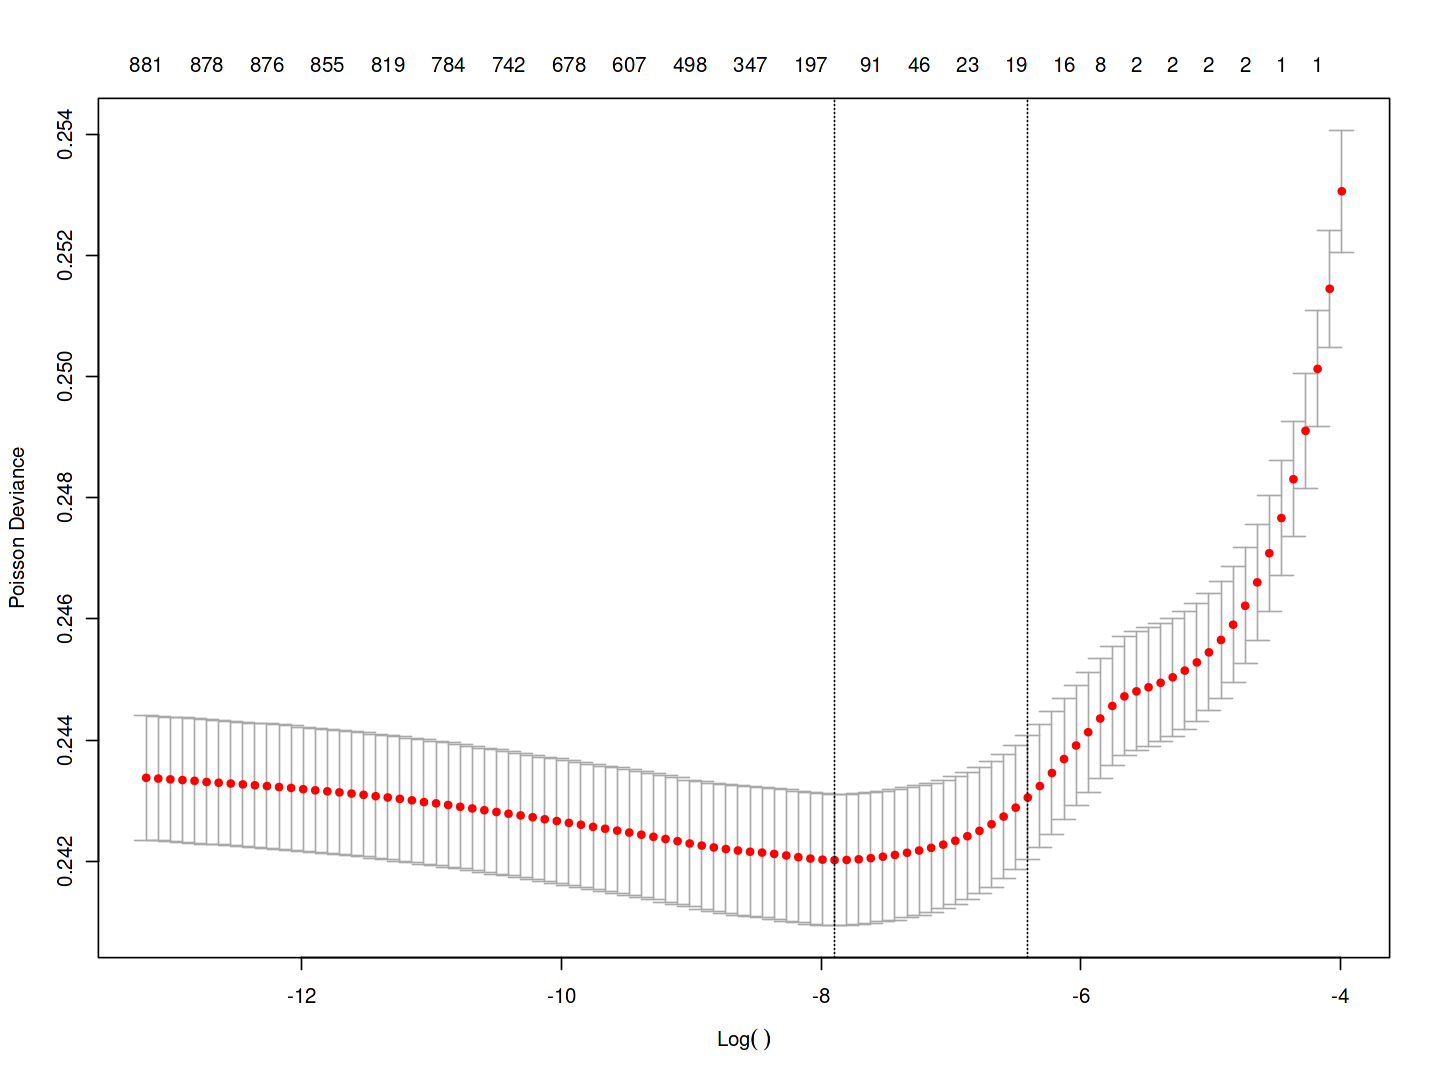

In [25]:
# Plot the regularization path
options(repr.plot.width=12, repr.plot.height = 9) 
plot(fit.lasso,label = TRUE)
print(fit.lasso)

In [26]:
# Show non-zero coefficients

# Extract coefficients as a matrix and convert to a dataframe
df_lasso_coef <- as.data.frame(as.matrix(coef(fit.lasso, s = 0.01)))
#df_lasso_coef$variable <- rownames(df_lasso_coef)
# Filter out rows where coef is not equal to 0
(df_lasso_coef_filtered <- subset(df_lasso_coef, s1 != 0))

s1           
(Intercept)              -3.4151603942
BonusMalusGLM             0.0127574981
BonusMalusGLM:DensityGLM  0.0001400847

   user  system elapsed 
505.195   3.584 508.953 

[1] 0.0004086823

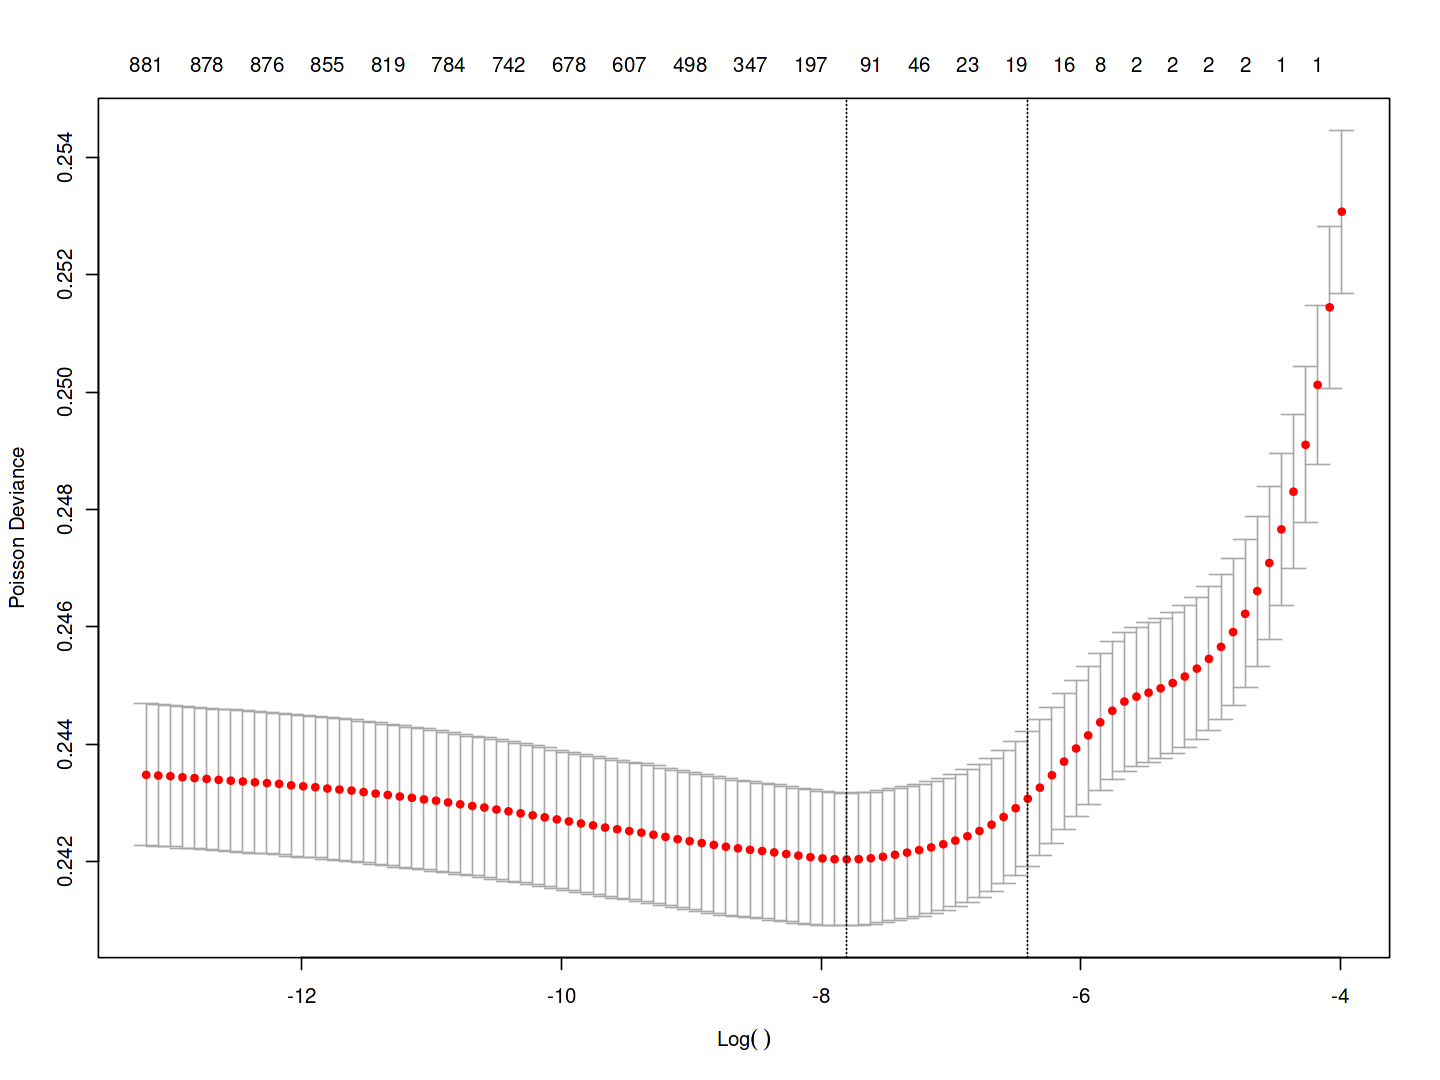

In [27]:
# cross-validation

{t1 <- proc.time()
   cv.lasso <- cv.glmnet(x = learn.glmnet, y=learn$ClaimNb, alpha = 1, offset = log(learn$Exposure), family = "poisson", nfolds = 5)
   (proc.time()-t1)}

plot(cv.lasso)

cv.lasso$lambda.min

In [28]:
# Show (a few) non-zero coefficients
df_lasso_coef <- as.data.frame(as.matrix(coef(cv.lasso, s = "lambda.min")))
df_lasso_coef_filtered <- subset(df_lasso_coef, s1 != 0)
dim(df_lasso_coef_filtered)
head(df_lasso_coef_filtered)

[1] 125   1

s1          
(Intercept)   -4.485352224
VehAgeGLM3    -0.152185624
DrivAgeGLM2   -0.223179253
DrivAgeGLM3   -0.317206396
DrivAgeGLM4   -0.005295672
BonusMalusGLM  0.027282892

In [29]:
test$fitLASSO <-  predict(cv.lasso, newx = test.glmnet, newoffset = log(test$Exposure), type = "response", s = "lambda.min")[,1] 
learn$fitLASSO <- predict(cv.lasso, newx = learn.glmnet, newoffset = log(learn$Exposure), type = "response" , s = "lambda.min")[,1] 

# Print claim frequency actual vs predicted 
CF2('Claim Frequency LASSO, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitLASSO,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance LASSO",
learn$fitLASSO,learn$ClaimNb,learn$Exposure,
test$fitLASSO,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement 
Benchmark.GLM2("LASSO", test$fitLASSO)

[1] "Claim Frequency LASSO, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance LASSO, Learn/Test: 29.50% / 29.53%"

[1] "GLM2-Improvement-Index (PD test) of LASSO: 99.1%"

### 2.3.2 Ridge (Poisson) Regression

   user  system elapsed 
426.996   2.936 430.022 

[1] 0.02056005

[1] "Claim Frequency RIDGE, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance RIDGE, Learn/Test: 29.42% / 29.64%"

[1] "GLM2-Improvement-Index (PD test) of RIDGE: 92.1%"

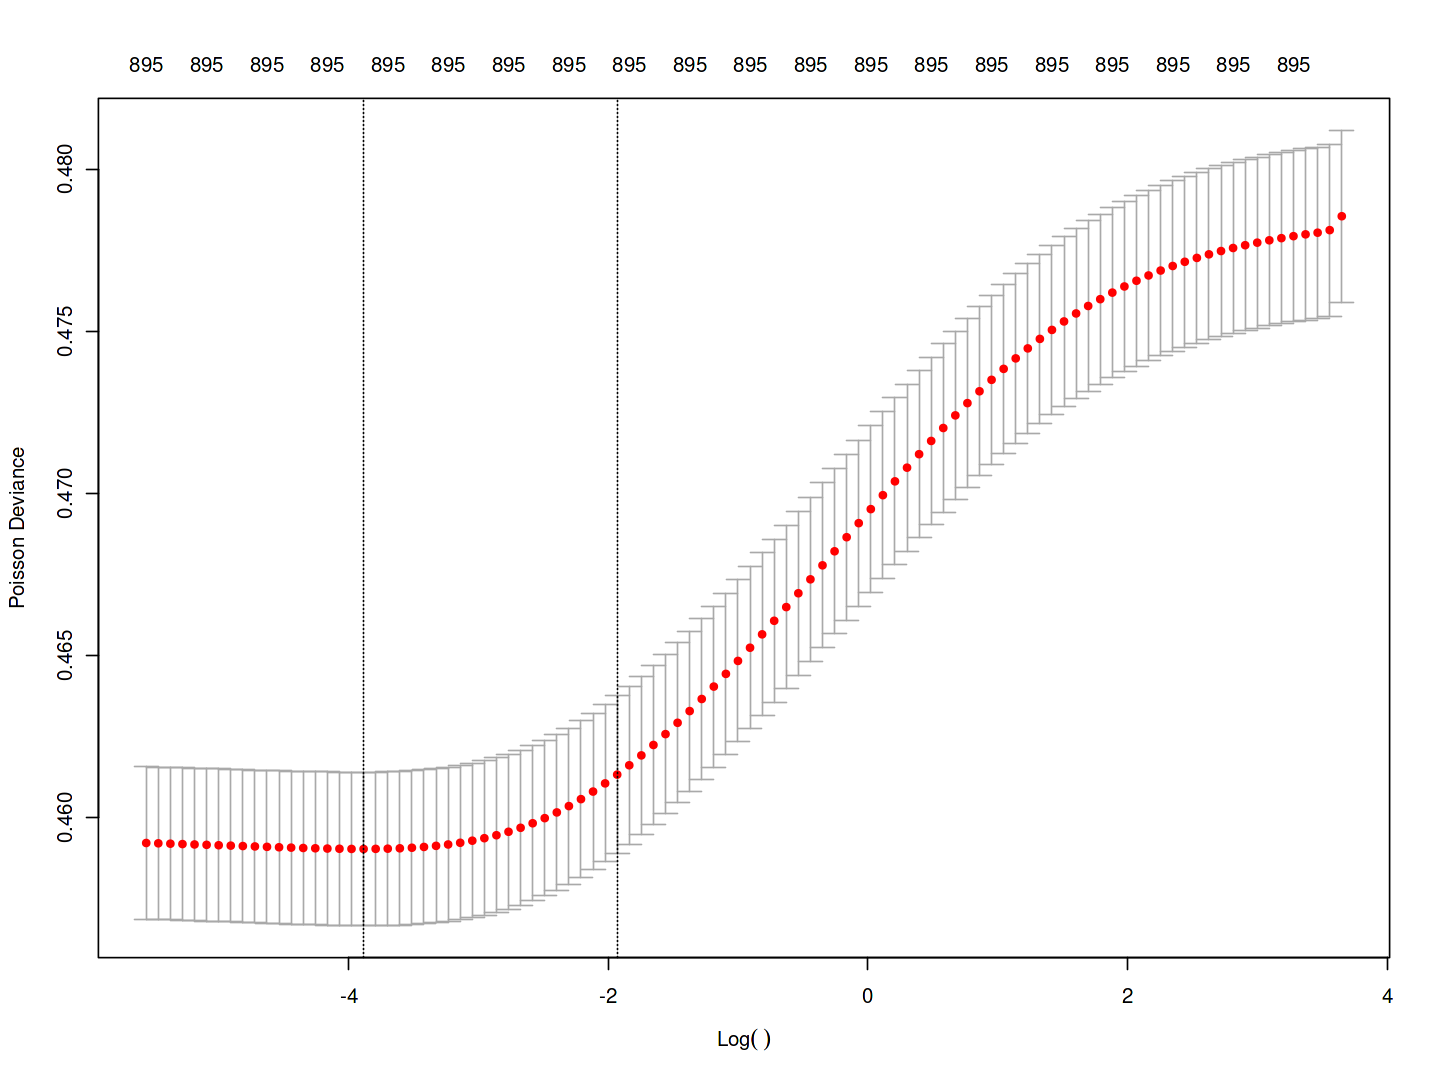

In [30]:
{t1 <- proc.time()
cvRIDGE <- cv.glmnet(x=learn.glmnet, y=learn$ClaimNb/learn$Exposure, alpha = 0, weights = learn$Exposure, family = "poisson", nfolds = 5) 
 (proc.time()-t1)}

plot(cvRIDGE)

cvRIDGE$lambda.min

test$fitRIDGE <-  exp(predict(cvRIDGE, newx = test.glmnet, s = "lambda.min"))[,1] * test$Exposure
learn$fitRIDGE <- exp(predict(cvRIDGE, newx = learn.glmnet, s = "lambda.min"))[,1] * learn$Exposure

# Print claim frequency actual vs predicted
CF2('Claim Frequency RIDGE, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitRIDGE,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance RIDGE", learn$fitRIDGE,learn$ClaimNb,learn$Exposure, test$fitRIDGE,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("RIDGE", test$fitRIDGE)


## 2.4 Generalized Additive Model (GAM)

Generalized additive models (GAMs) extend GLMs to account for certain non-linear relationships, while maintaining additivity. Consequently, GAMs are more flexible than GLMs. For a brief introduction to GAMs, we recommend the book "Extending the Linear Model with R" by Faraway (2016), while for a quick execution we recommend the bam function of the mgcv package.

The models are usually fit by penalized likelihood maximization, in which the loss function is modified by the addition of a penalty for each smooth function, penalizing it‘s „wiggliness“.

In [31]:
suppressMessages(library(mgcv))

# bam(): Generalized additive models for very large datasets, see https://cran.r-project.org/web/packages/mgcv/mgcv.pdf
#        "The advantage of bam is much lower memory footprint than gam, but it can also be much faster, for large datasets."

{t1 <- proc.time()
  d.gam3 <- bam(ClaimNb ~ s(VehAge) + s(DrivAge) + s(BonusMalusGLM) + VehPowerGLM + VehGas + VehBrand + AreaGLM + DensityGLM + Region + offset(log(Exposure)), 
                ,data=learn, scale=-1, family=poisson)
(proc.time()-t1)}
summary(d.gam3) # print fit statistics

   user  system elapsed 
125.090  85.436  55.365 


Family: poisson 
Link function: log 

Formula:
ClaimNb ~ s(VehAge) + s(DrivAge) + s(BonusMalusGLM) + VehPowerGLM + 
    VehGas + VehBrand + AreaGLM + DensityGLM + Region + offset(log(Exposure))

Parametric coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -3.083e+00  5.383e-02 -57.277  < 2e-16 ***
VehPowerGLM5   5.594e-02  3.227e-02   1.734 0.083006 .  
VehPowerGLM6   8.751e-02  3.173e-02   2.758 0.005814 ** 
VehPowerGLM7   9.256e-02  3.135e-02   2.953 0.003148 ** 
VehPowerGLM8   1.225e-01  4.447e-02   2.756 0.005860 ** 
VehPowerGLM9   2.609e-01  3.519e-02   7.414 1.22e-13 ***
VehGasRegular -1.575e-01  1.975e-02  -7.974 1.54e-15 ***
VehBrandB10   -3.060e-02  5.915e-02  -0.517 0.604956    
VehBrandB11    1.781e-01  6.118e-02   2.912 0.003593 ** 
VehBrandB12   -2.844e-01  3.363e-02  -8.455  < 2e-16 ***
VehBrandB13   -2.282e-03  6.687e-02  -0.034 0.972772    
VehBrandB14   -3.076e-01  1.369e-01  -2.247 0.024670 *  
VehBrandB2    -1.067e-02  2.539e-02  -

In [32]:
# make predictions
learn$fitGAM3 <- fitted(d.gam3)
test$fitGAM3 <- predict(d.gam3, newdata=test, type="response")
# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fitGAM3,test$Exposure)

# Print Poisson Deviance
PDW2('Poisson Deviance GAM3', learn$fitGAM3,learn$ClaimNb,learn$Exposure, test$fitGAM3,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GAM3", test$fitGAM3)

[1] "Claim Frequency GLM2, Test-Sample, Actual/Predicted: 7.38% / 7.37%"

[1] "Poisson Deviance GAM3, Learn/Test: 29.21% / 29.20%"

[1] "GLM2-Improvement-Index (PD test) of GAM3: 120.0%"

This is a remarkable improvement. Let's view the built-in visualizations and examine residuals and marginal effects of the spline functions:

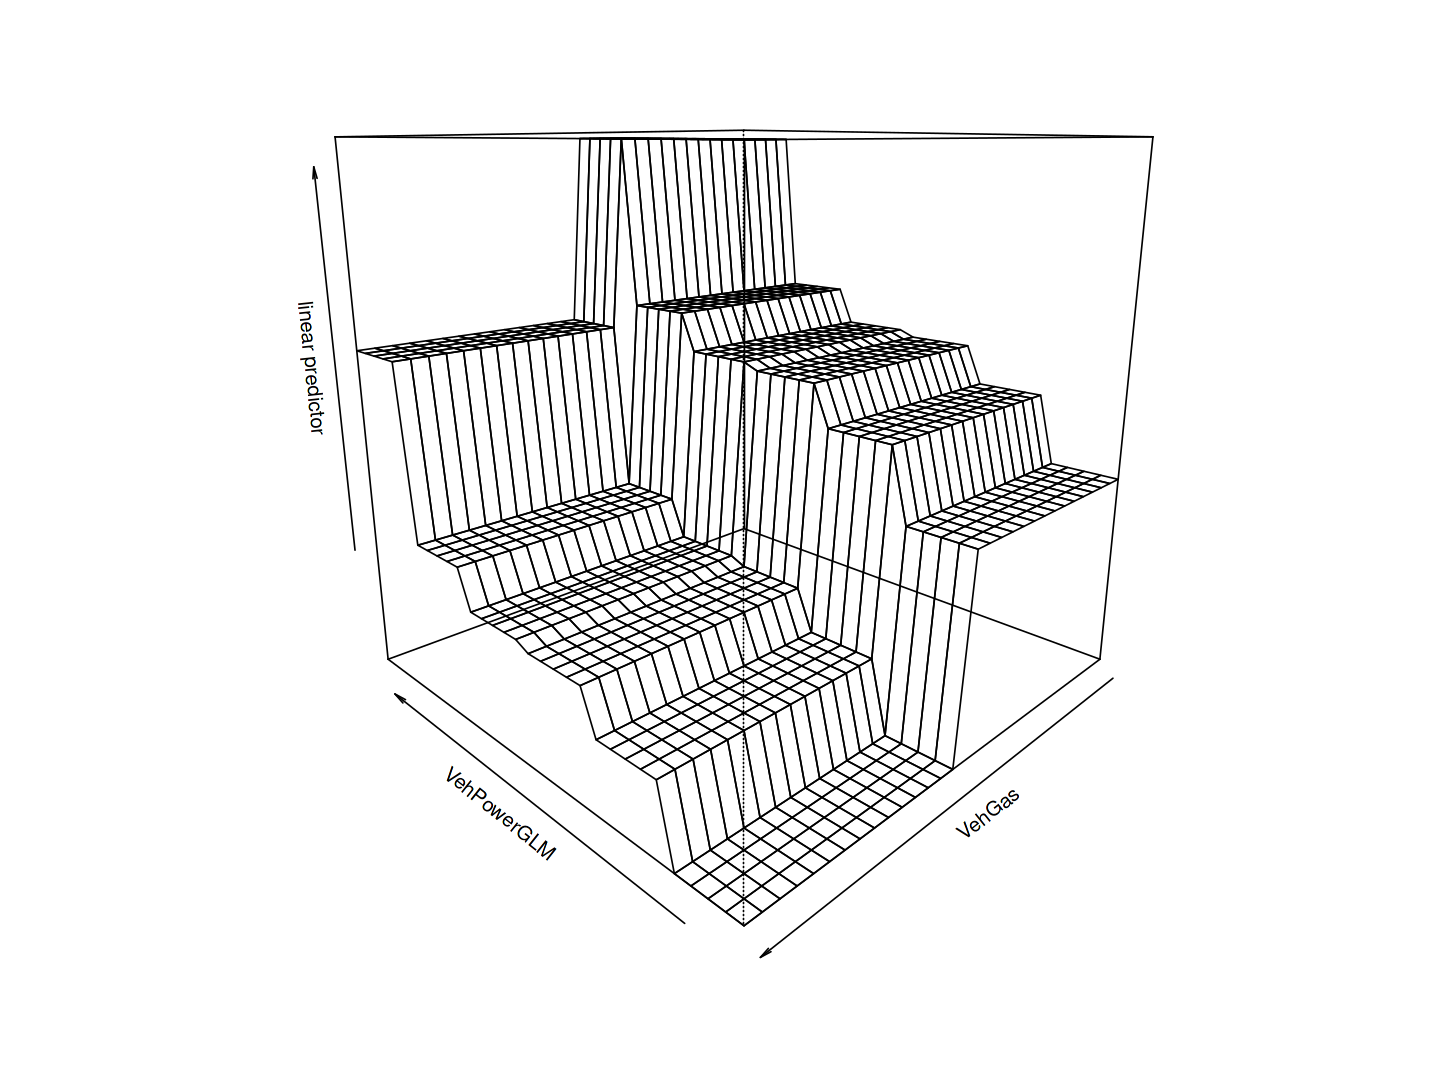

In [33]:
# 3D-plot 
vis.gam(d.gam3, theta=-135)

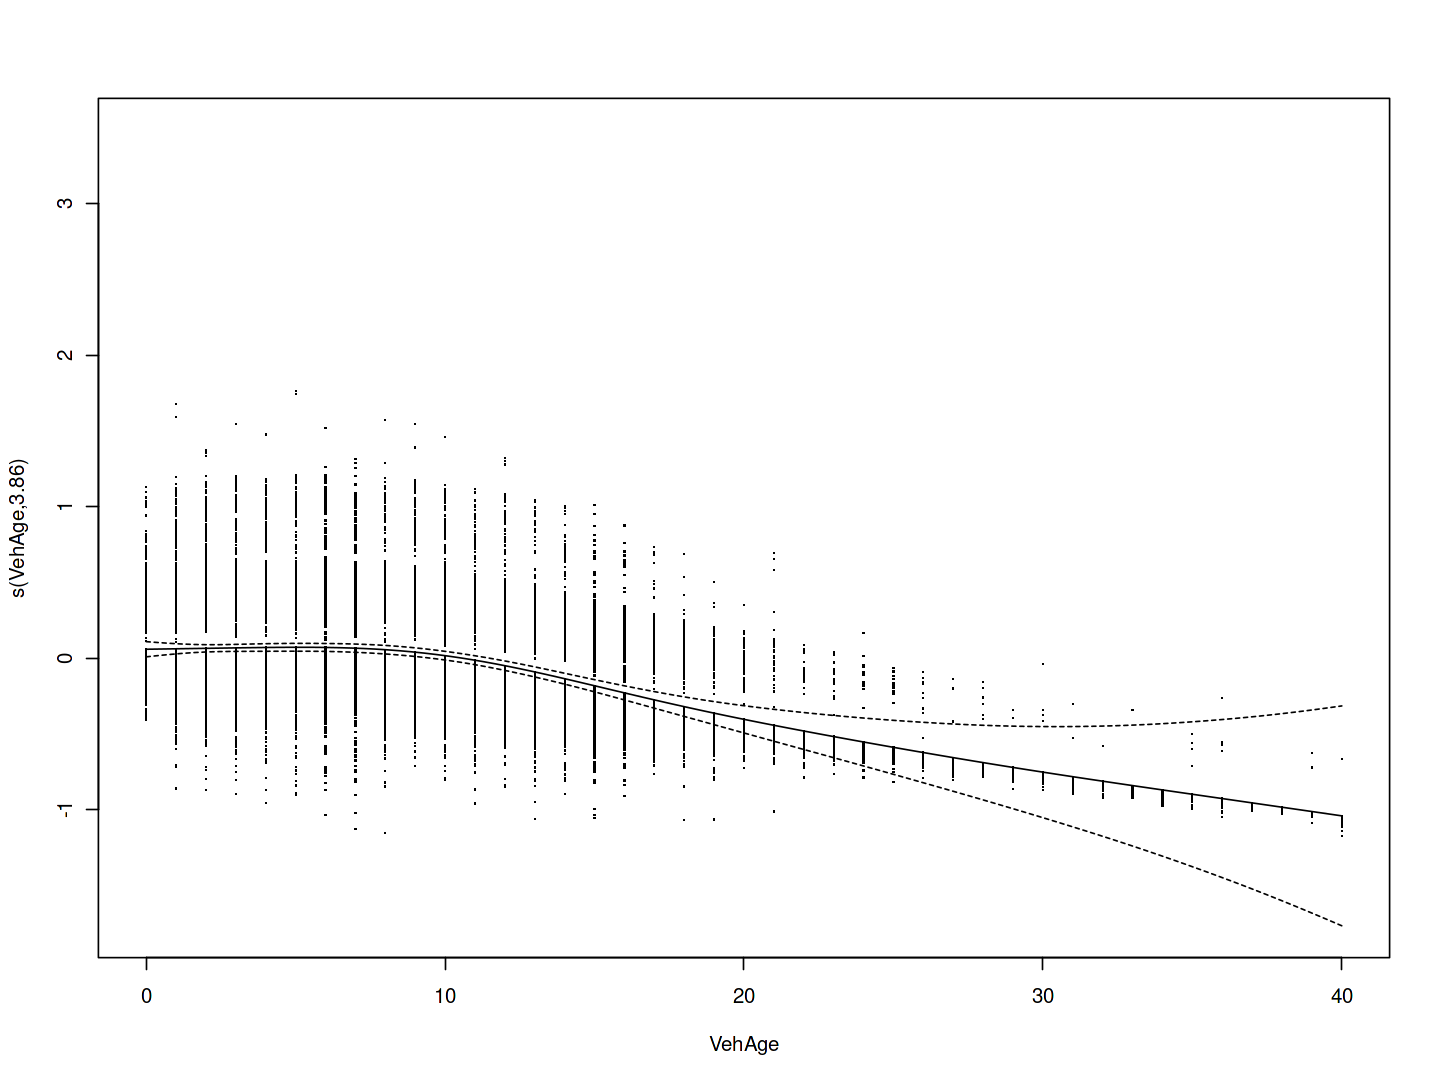

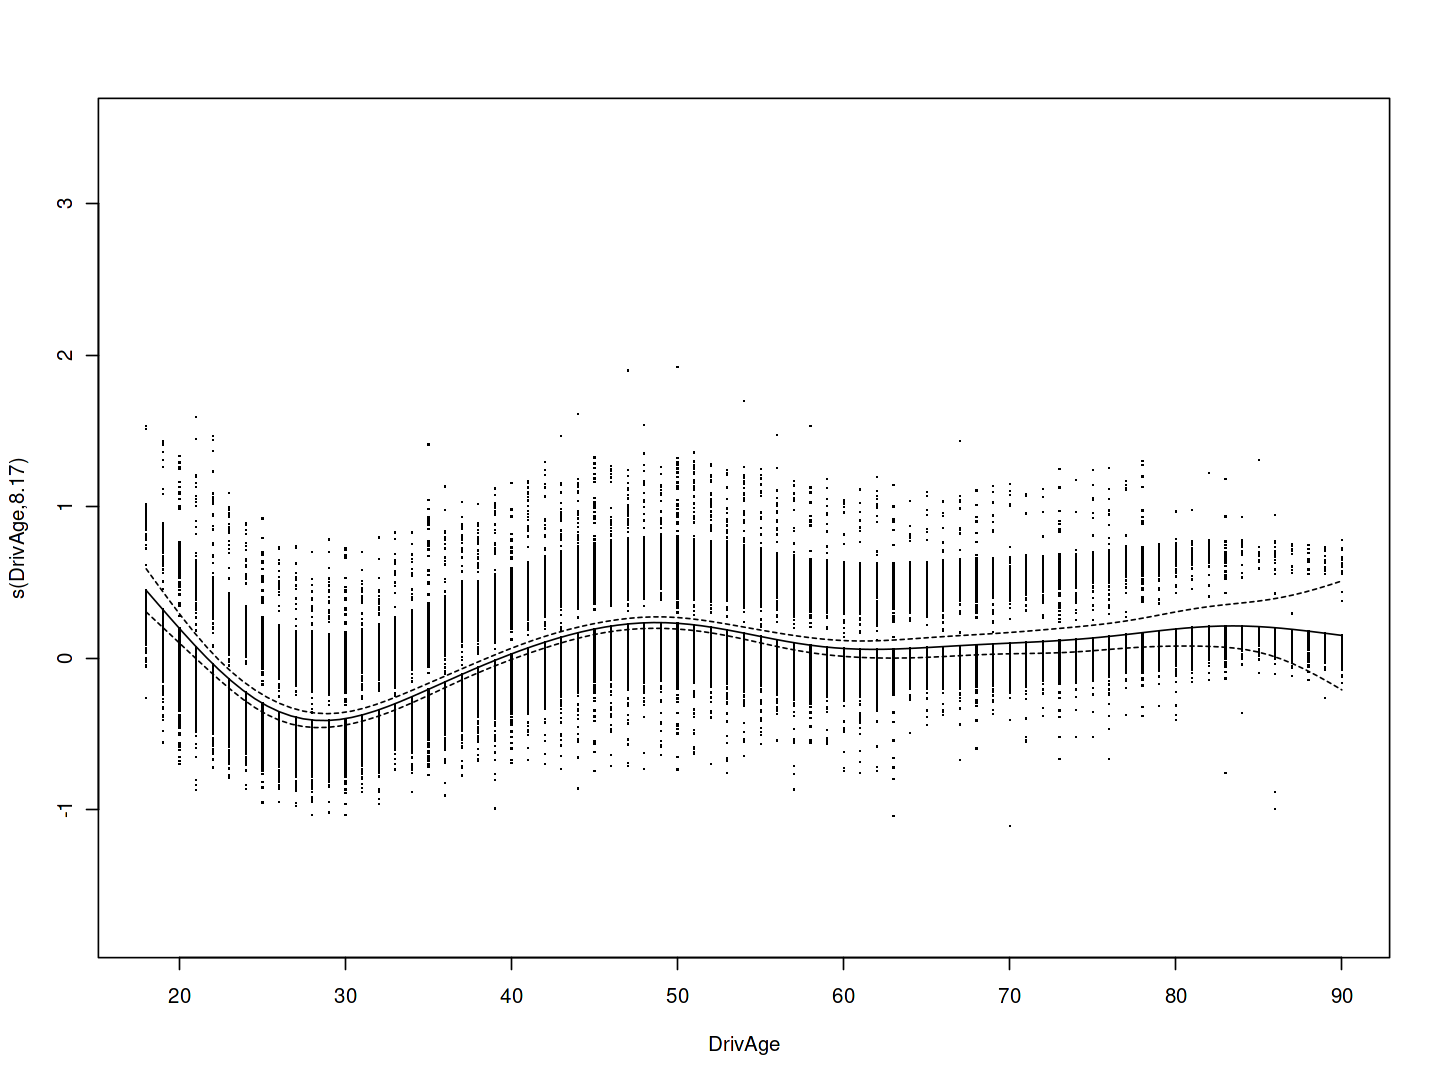

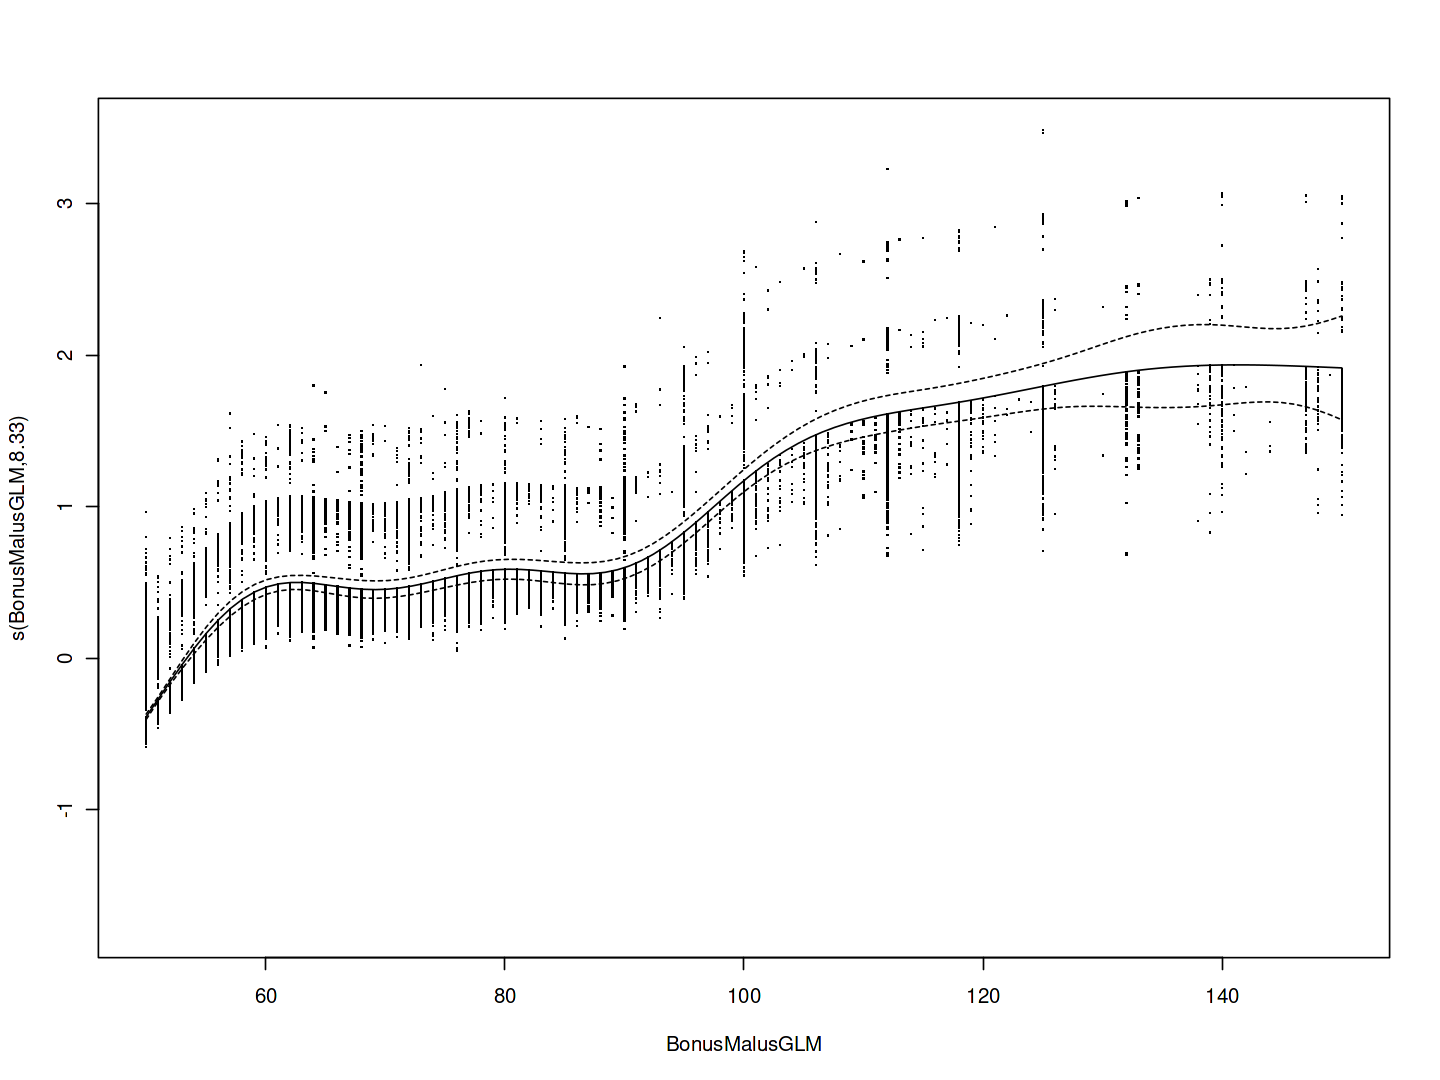

In [34]:
# Plot residuals of spline-functions
plot(d.gam3, residuals=TRUE)

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(Exposure = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(Exposure)` in the model formula.



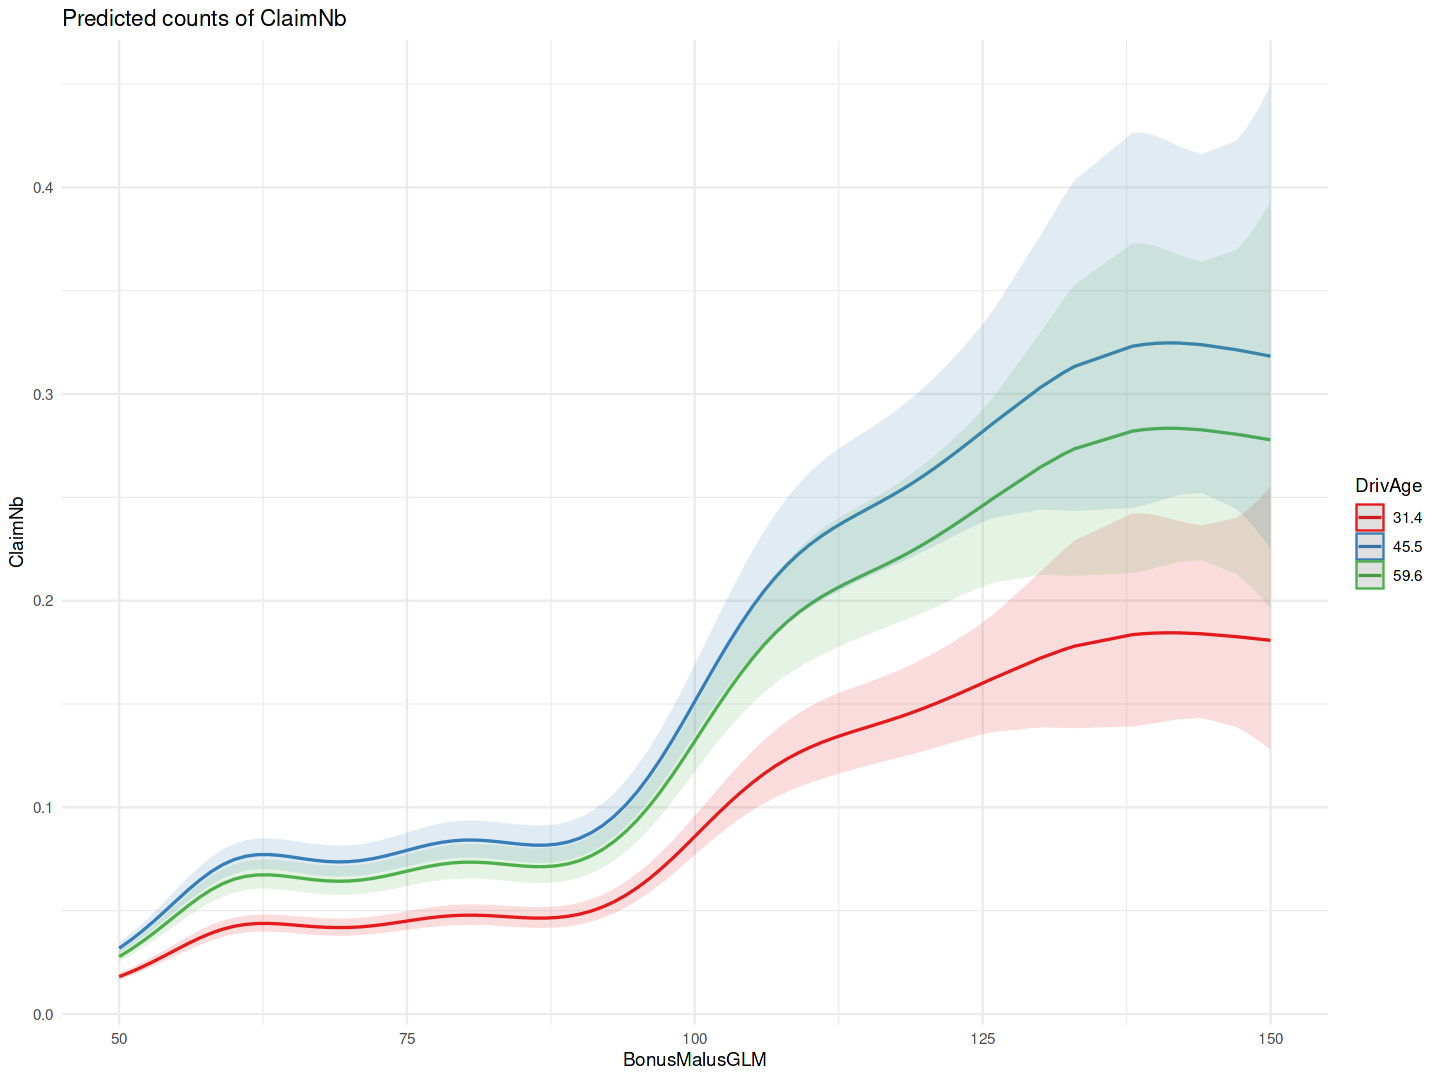

In [35]:
# plot marginal effects
library(ggplot2)
library(ggeffects)

ggpredict(d.gam3, c("BonusMalusGLM", "DrivAge")) %>%
  plot() +
  theme_minimal()

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(Exposure = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(Exposure)` in the model formula.



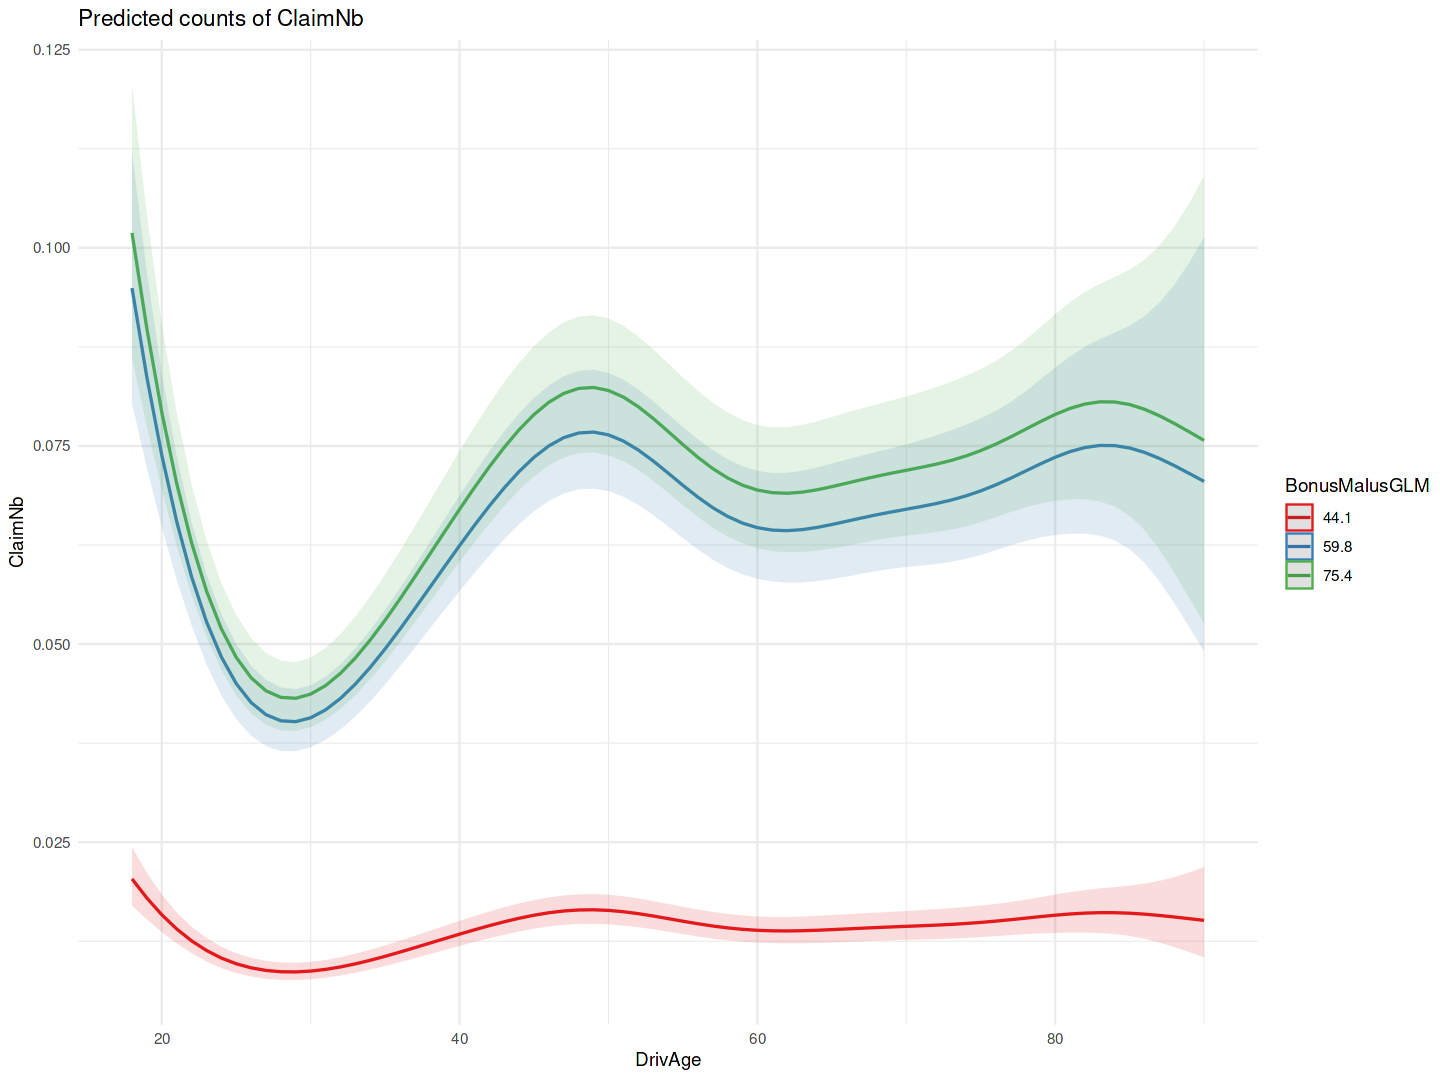

In [36]:
ggpredict(d.gam3, c("DrivAge", "BonusMalusGLM")) %>%
  plot() +
  theme_minimal()

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(Exposure = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(Exposure)` in the model formula.



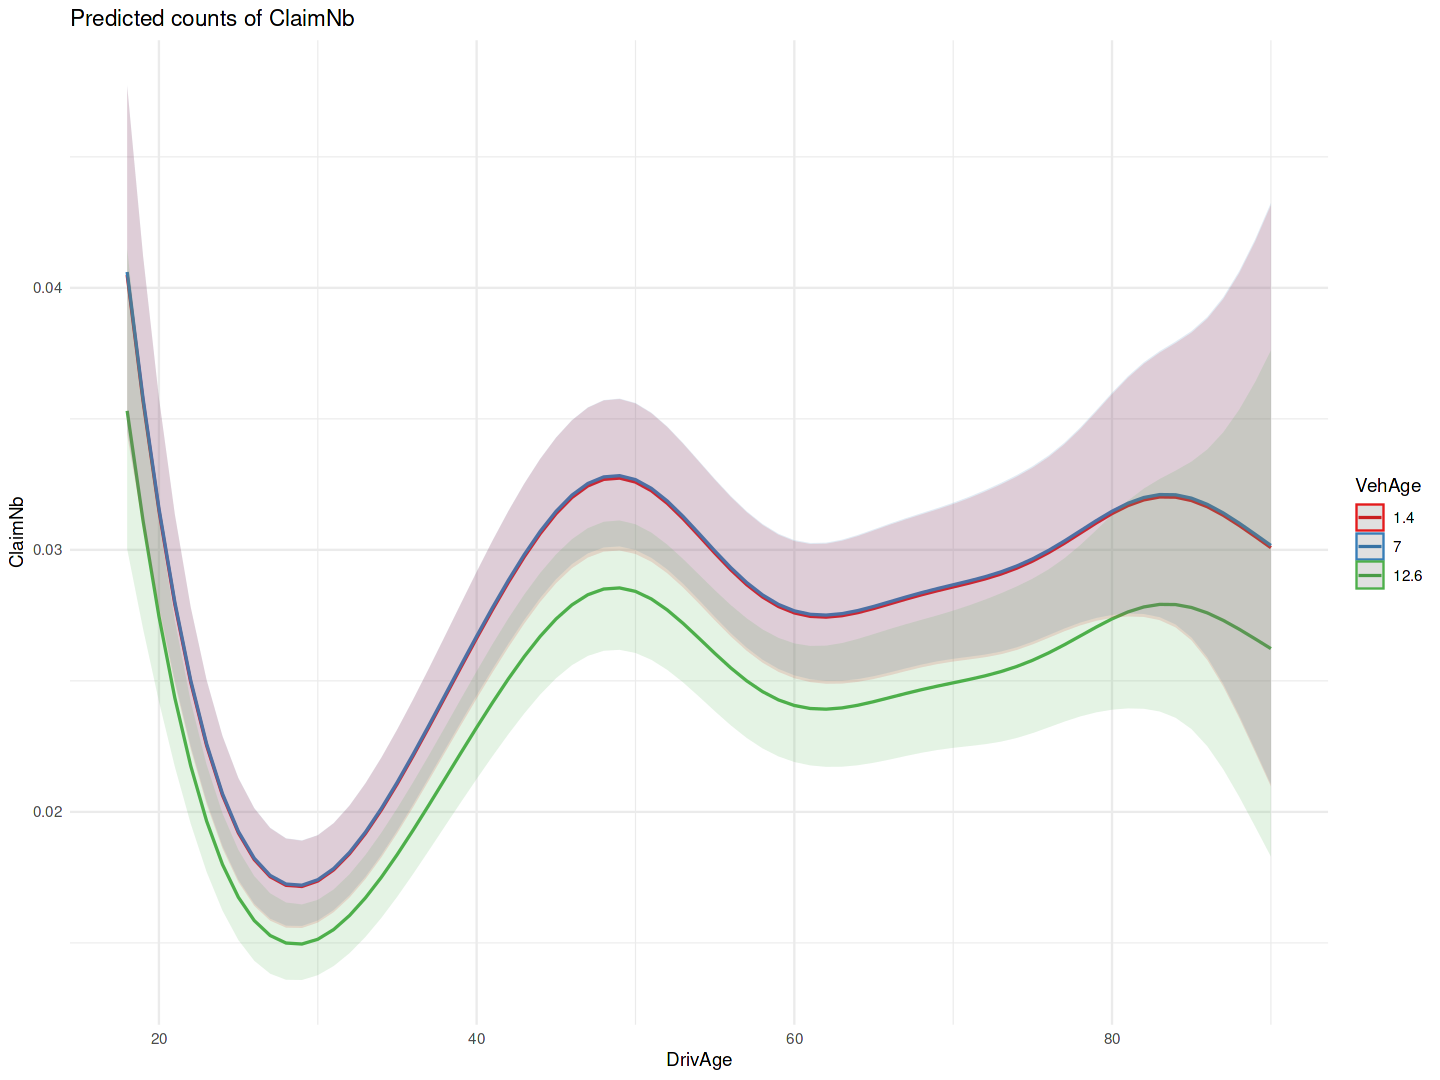

In [37]:
ggpredict(d.gam3, c("DrivAge", "VehAge")) %>%
  plot() +
  theme_minimal()

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(Exposure = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(Exposure)` in the model formula.



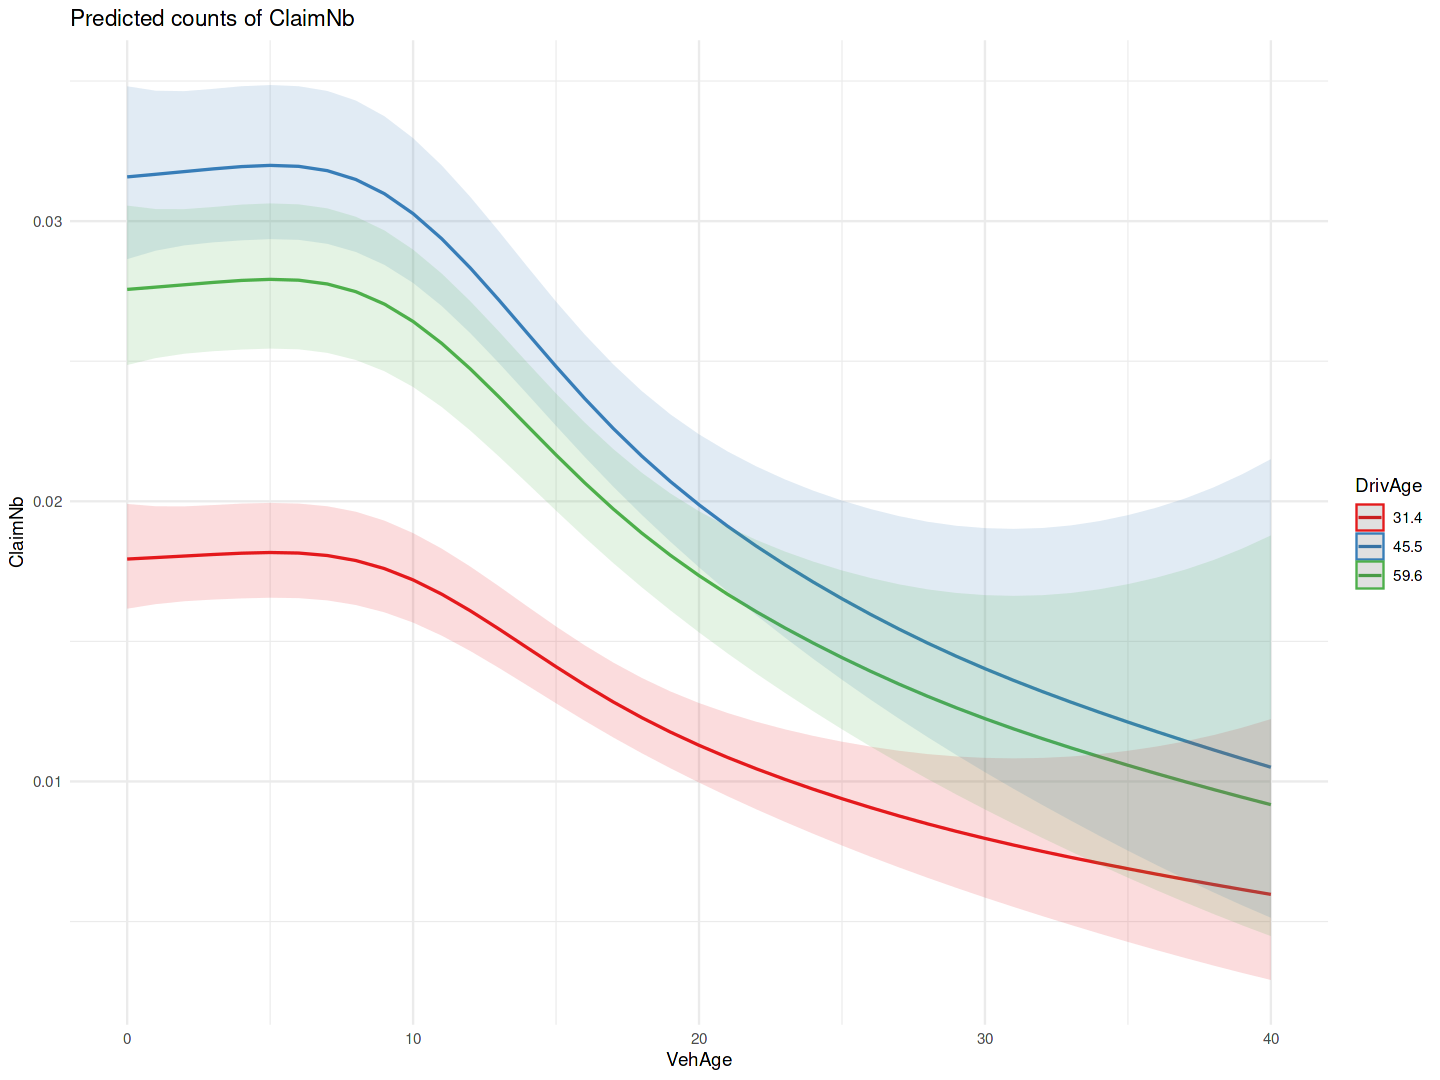

In [38]:
ggpredict(d.gam3, c("VehAge", "DrivAge")) %>%
  plot() +
  theme_minimal()

The relationships recognizable here and other possible relationships are systematically examined in Chapter 5 and, if necessary, incorporated into the GLM models as interactions.

## 2.5 Other Approaches and Summary

Encouraged by the successful and fast implementation and execution of the GAMs with mgcv functions, we tried Generalized Additive Mixed Models (GAMMs) and, as in version 2 of this notebook, Generalized Linear Mixed Models (GLMMs, now for the entire data set) as further interesting and related models. Unfortunately, in addition to very long runtimes, considerable convergence problems also occurred. Therefore, these approaches were not pursued further. 

In summary, the regularized (or penalized) GLMs LASSO and Ridge Regression have a similar Poisson deviation to GLM2 and have not led to an improvement. The individual predictions and their summations are quite similar to those of GLM2:

In [39]:
summary(test[,c(22:25)])

    fitGLM2             fitLASSO            fitRIDGE        
 Min.   :0.0000771   Min.   :0.0000871   Min.   :0.0000446  
 1st Qu.:0.0116528   1st Qu.:0.0119156   1st Qu.:0.0117709  
 Median :0.0325933   Median :0.0332890   Median :0.0332188  
 Mean   :0.0388732   Mean   :0.0388728   Mean   :0.0388962  
 3rd Qu.:0.0545922   3rd Qu.:0.0548097   3rd Qu.:0.0549220  
 Max.   :1.6123148   Max.   :1.3968238   Max.   :1.5390656  
    fitGAM3         
 Min.   :0.0000489  
 1st Qu.:0.0113883  
 Median :0.0311378  
 Mean   :0.0388232  
 3rd Qu.:0.0532217  
 Max.   :0.9186659  

In [40]:
head(test[,c(2:7,22:25)])

Exposure Area VehPower VehAge DrivAge BonusMalus fitGLM2     fitLASSO   
2  0.77     D    5        0      55      50         0.043237633 0.042273331
12 0.87     C    7        0      56      50         0.048637388 0.047245206
21 0.03     A    6        2      55      50         0.001256530 0.001234614
22 0.81     E    7        0      73      50         0.043599397 0.051576266
23 0.06     E    7        0      73      50         0.003229585 0.003820464
36 0.47     D    4        0      23      85         0.040890913 0.041349609
   fitRIDGE    fitGAM3    
2  0.033083808 0.038588702
12 0.045920546 0.043075455
21 0.002060968 0.001120073
22 0.048254999 0.041834420
23 0.003574444 0.003098846
36 0.028132735 0.039236161

The reason for this could be that the data set has a very limited number of features compared to its size and we have not considered interactions at this point. 

In contrast, the GAM model performed quite well and could be an interesting alternative to GLMs if there are important numerical features with a non-linear relationship to the dependent variable. With this option in hand, we end classical modeling and turn to machine learning methods.

<a id="ch3"></a>
# 3. Gradient Boosting and Explainability

Boosting is an approach to improve the predictions that result from a decision tree (see example in chapter 1.2). In contrast to fitting a single large, potentially overfitting decision tree to the data, the boosting approach learns slowly instead. With gradient boosting, a decision tree is fitted to the residuals of the current model (instead of the result Y). This new decision tree is added into the fitting function with a weight "eta", which is referred to as the "learning rate", in order to update the residuals again. Typically, eta is less than 10% and the process is repeated over a hundred times. Boosting can over-fit if this process is repeated too often and the trees are too deep. The depth of the decision trees, the learning rate (eta) and the "number of rounds" are important hyper parameters that have to be tuned.

Currently, gradient tree boosting machines are the most powerful and fairly easy to use tools for machine learning. This has also been demonstrated in version 2 of this notebook on unadjusted data. Now we want to try out alternatives to XGBoost and find out how these tools perform when the signal is very fuzzy, as in our case with the cleaned data. After first demonstrating the full potential of an unconstrained boosting model, we use a monotonically increasing constraint on the BonusMalus as an exemplary consideration of a tariff system.

In a second part, we will look at the explainability of the models and use tools such as SHAP.

### 3.1  Gradient Boosting with XGBoost

XGBoost (eXtreme Gradient Boosting) was the first fast gradient boosting implementation in 2014 and is known for winning many data science competitions and is still very popular with R users. It can be downloaded from CRAN and there is a lot of information available, even general information for actuaries, e.g. https://www.actuaries.org.uk/news-and-insights/news/article-fitting-data-xgboost (11 October 2019). 

XGBoost requires carefully tuned hyperparameters. In our case, we use the most important parameters from the associated Python notebook.

#### 3.1.1 Data Preparation

In [41]:
num_features <- c('BonusMalus','DrivAge','VehPower','VehAge','Density')
cat_features <- c('Area','VehBrand','VehGas','Region')
features <- c(num_features, cat_features)

# Feature pre-processing for XGBoost and lightGBM

df_feat <- dat[,c(features)]
df_feat$Area <- as.integer(df_feat$Area)
print(paste("Features before one-hot-encoding:",dim(df_feat)[2]))

# one-hot encoding for Region and VehBrand
df_feat <- as.data.frame(model.matrix( ~ 0 +. ,data = df_feat)) 
print(paste("Features after one-hot-encoding: ",dim(df_feat)[2]))

# split data into learn and test
X_learn <- df_feat[dat1$fold != 5,]    # 80%
X_test  <- df_feat[dat1$fold == 5,]    # 20%

[1] "Features before one-hot-encoding: 9"
[1] "Features after one-hot-encoding:  39"


In [42]:
# create monotonic constraints vector: increasing: +1, decreasing: -1, unconstraint: 0
mtc <- c(rep( 0, length(X_learn)))
head(X_learn,2) # check feature names
mtc[1] <- 1 # BonusMalus increasing 
print(mtc)

BonusMalus DrivAge VehPower VehAge Density Area VehBrandB1 VehBrandB10
1 50         55      5        0      1217    4    0          0          
3 50         52      6        2        54    2    0          0          
  VehBrandB11 VehBrandB12 ⋯ RegionR53 RegionR54 RegionR72 RegionR73 RegionR74
1 0           1           ⋯ 0         0         0         0         0        
3 0           1           ⋯ 0         0         0         0         0        
  RegionR82 RegionR83 RegionR91 RegionR93 RegionR94
1 1         0         0         0         0        
3 0         0         0         0         0

 [1] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0


In [43]:
suppressMessages(library(xgboost))
# construct xgb.DMatrices (these are the internal data structures used by XGBoost during training)  
dtrain <- xgb.DMatrix(data = data.matrix(X_learn), label = learn$ClaimNb/learn$Exposure, weight=learn$Exposure)
# make label wrong (shouldn't change anything): change to fold-number
dtest <- xgb.DMatrix(data = data.matrix(X_test), label = test$fold/test$Exposure, weight=test$Exposure)

#### 3.1.2 XGBoost without constraints

For comparison with unconstraint classical models we first show the full potential of an unconstraint XGBoost model for this dataset and task.

In [44]:
# train model (using tuned hyperparameters, see corresponding Python notebook)
{t1 <- proc.time()
  fit.xgb0 <- xgb.train(data=dtrain, objective='count:poisson', 
                       nrounds = 500, max_depth = 5, eta = 0.05, tree_method = "hist")
(proc.time()-t1)}

   user  system elapsed 
125.343   0.155  32.089 

In [45]:
## make predictions
learn$fitXGB0 <- predict(fit.xgb0 , newdata = dtrain) * learn$Exposure
test$fitXGB0 <- predict(fit.xgb0, newdata = dtest) * test$Exposure

# Print claim frequency actual vs predicted
CF2('Claim Frequency XGB, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitXGB0,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance XGB", learn$fitXGB0,learn$ClaimNb,learn$Exposure, test$fitXGB0,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("XGB unconstraint", test$fitXGB0)

[1] "Claim Frequency XGB, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance XGB, Learn/Test: 28.20% / 28.74%"

[1] "GLM2-Improvement-Index (PD test) of XGB unconstraint: 149.0%"

#### 3.1.3 XGBoost with monotonic constraint

We now apply a monotonically increasing condition with BonusMalus to account for a tariff structure (as an example).

In [46]:
# train model (using tuned hyperparameters, see corresponding Python notebook)
{t1 <- proc.time()
  fit.xgb <- xgb.train(data=dtrain, objective='count:poisson', monotone_constraints = mtc,
                       nrounds = 500, max_depth = 5, eta = 0.05, tree_method = "hist")
(proc.time()-t1)}

   user  system elapsed 
126.935   0.151  32.408 

In [47]:
## make predictions
learn$fitXGB <- predict(fit.xgb , newdata = dtrain) * learn$Exposure
test$fitXGB <- predict(fit.xgb, newdata = dtest) * test$Exposure

# Print claim frequency actual vs predicted
CF2('Claim Frequency XGB, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitXGB,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance XGB", learn$fitXGB,learn$ClaimNb,learn$Exposure, test$fitXGB,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("XGB", test$fitXGB)

[1] "Claim Frequency XGB, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance XGB, Learn/Test: 28.51% / 28.98%"

[1] "GLM2-Improvement-Index (PD test) of XGB: 133.8%"

The unrestricted XGBoost model performs best by far. The monotonic constraint reduces the improvement by around a third, but the constraint model still performs remarkably better than all classic models from chapter 2. 

## 3.2 CatBoost: The Superior Challenger?

CatBoost is a powerful ML tool that can process categorical data, requires minimal data pre-processing and interfaces with several programming languages including R, see https://catboost.ai/en/docs/concepts/r-quickstart. It is the newest tool in our comparison and has shown remarkable success on this binary classification task right away:
https://www.kaggle.com/code/floser/binary-classification-credit-scoring. 

When tested on the original MTPL data set (before data cleaning, see version 2 of this notebook) and without monotonic constraints, CatBoost was able to shine with an impressive improvement index of over 200. Is it now also better than the top dog XGBoost?

In [48]:
library(catboost)

learn_pool <- catboost.load_pool(data = learn[features], label = learn$ClaimNb, 
                                 cat_features = cat_features, baseline = as.matrix(learn$Exposure))

# make label wrong (shouldn't change anything): change to fold-number
test_pool <- catboost.load_pool(data = test[features], label = test$fold, 
                                 cat_features = cat_features, baseline = as.matrix(test$Exposure))

In [49]:
# create monotonic constraints vector: increasing: +1, decreasing: -1, unconstraint: 0
mtcc <- c(rep( 0, length(features)))
mtcc[1] <- 1 # BonusMalus increasing 
print(mtcc)
head(learn[features],3)

[1] 1 0 0 0 0 0 0 0 0


BonusMalus DrivAge VehPower VehAge Density Area VehBrand VehGas  Region
1 50         55      5        0      1217    D    B12      Regular R82   
3 50         52      6        2        54    B    B12      Diesel  R22   
4 50         46      7        0        76    B    B12      Diesel  R72

In [50]:
# train model (using tuned hyperparameters, see corresponding Python notebook)
fit_params <- list(logging_level='Silent', loss_function='Poisson', monotone_constraints = mtcc, random_seed=42,
                  iterations = 500, learning_rate = 0.15, depth = 3)
{t1 <- proc.time()
  CB <- catboost.train(learn_pool, params = fit_params)
(proc.time()-t1)}

Model shrinkage in combination with baseline column is not implemented yet. Reset model_shrink_rate to 0.


   user  system elapsed 
506.149  32.767 144.459 

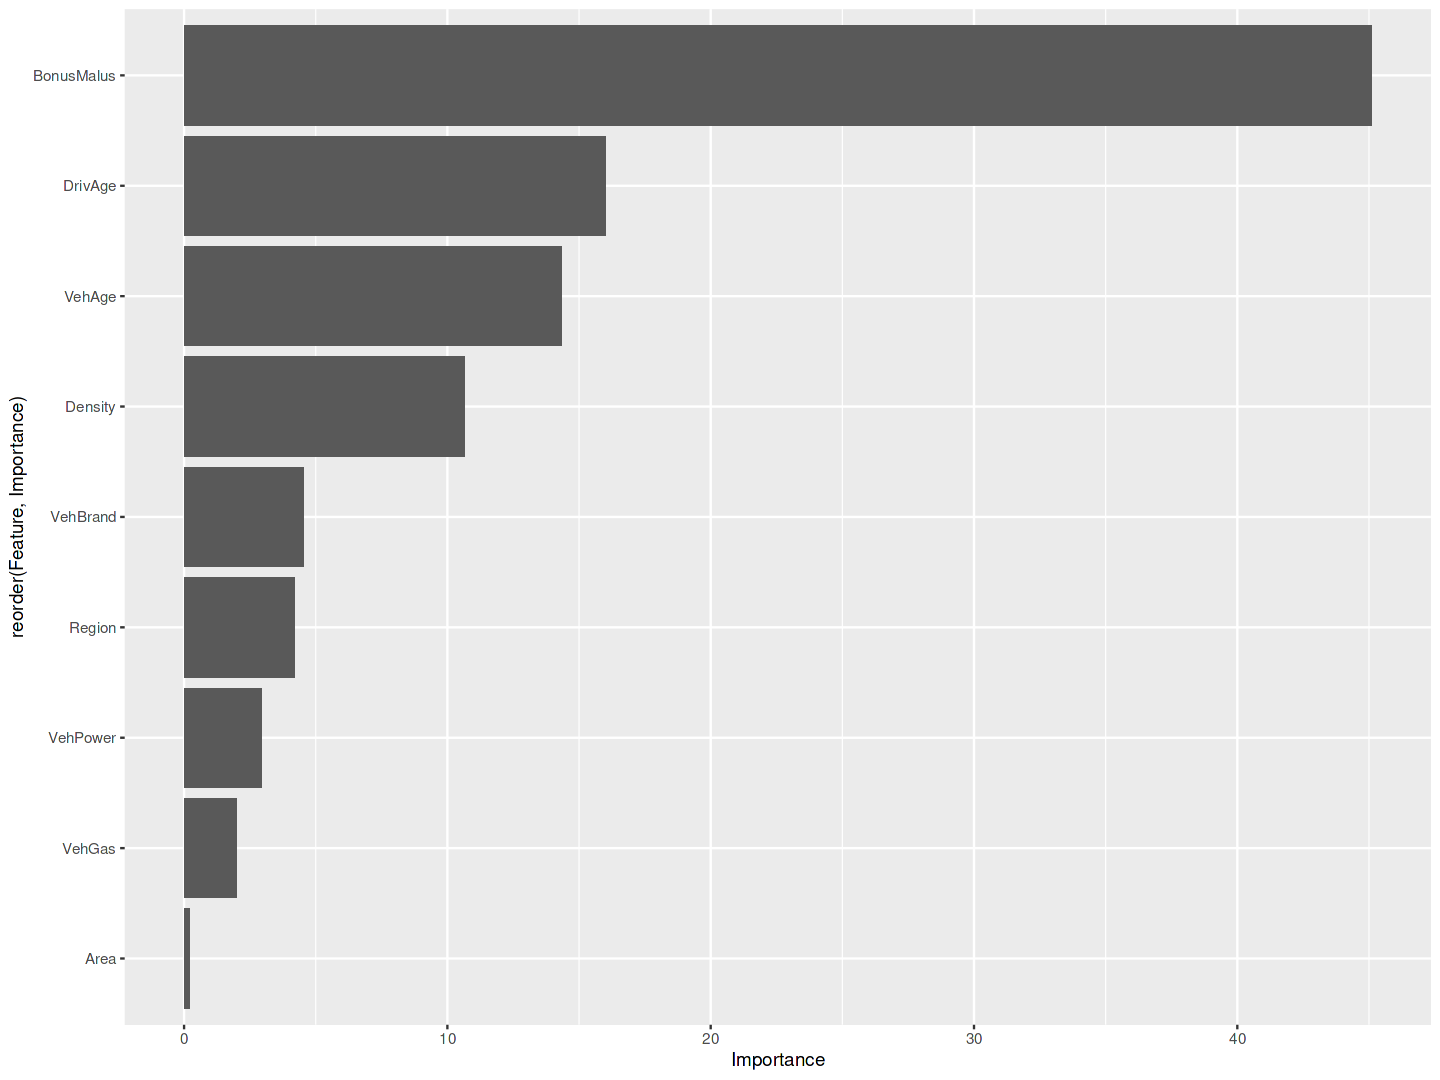

In [51]:
# Variable importance plot
catboost.get_feature_importance(CB, test_pool) %>% 
  as.data.frame() %>% 
  setNames("Importance") %>% 
  rownames_to_column("Feature") %>% 
  ggplot(aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip()

In [52]:
test$fitCB <- exp(catboost.predict(CB,test_pool))
learn$fitCB <-  exp(catboost.predict(CB,learn_pool))

# Print claim frequency actual vs predicted
CF2('Claim Frequency CatBoost, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitCB,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance CatBoost", learn$fitCB,learn$ClaimNb,learn$Exposure, test$fitCB,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("CB", test$fitCB)

[1] "Claim Frequency CatBoost, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance CatBoost, Learn/Test: 28.89% / 29.04%"

[1] "GLM2-Improvement-Index (PD test) of CB: 129.8%"

Unfortunately, model shrinkage in combination with the baseline column is not yet implemented. CatBoost performs worse than XGBoost and is quite slow (and even worse and slower with default values). We therefore move on to the next promising competitor.

### 3.3 lightGBM: A better alternative?

LightGBM is a fast and powerful gradient tree boosting machine and has replaced XGBoost as the top winning tool in ML competitions after its release in 2017. For information about the R package see https://lightgbm.readthedocs.io/en/stable/R/index.html

In [53]:
suppressMessages(library(lightgbm))

# LGB matrices (frequency-weighted-version)
# https://towardsdatascience.com/how-to-handle-the-exposure-offset-with-boosted-trees-fd09cc946837
llearn <- lgb.Dataset(data = data.matrix(X_learn), label = learn$ClaimNb/learn$Exposure, weight=learn$Exposure)

In [54]:
# train lgb-model (using default hyperparameters, see corresponding Python notebook)
{t2 <- proc.time()
  LGB <- lgb.train(data=llearn, objective='poisson', monotone_constraints = mtc, num_leaves=31, learning_rate=0.1, n_estimators=100)
(proc.time()-t2)}

   user  system elapsed 
 13.290   0.055   3.631 

In [55]:
## make predictions
learn$fitLGB <- predict(LGB, data.matrix(X_learn)) * learn$Exposure
test$fitLGB <- predict(LGB, data.matrix(X_test)) * test$Exposure

# Print claim frequency actual vs predicted
CF2('Claim Frequency lightGBM, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitLGB,test$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance lightGBM", learn$fitLGB,learn$ClaimNb,learn$Exposure, test$fitLGB,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("LGB", test$fitLGB)

[1] "Claim Frequency lightGBM, Test-Sample, Actual/Predicted: 7.38% / 7.38%"

[1] "Poisson Deviance lightGBM, Learn/Test: 28.57% / 28.96%"

[1] "GLM2-Improvement-Index (PD test) of LGB: 134.6%"

This was by far the fastest training of a boosting model. The resulting LightGBM model is even slightly better than the corresponding constraint XGBoost model. So let's try to explain the predictions of this remarkable LightGBM model.

### 3.4 Explaining lightGBMs predictions with TreeSHAP

In this section, we show how the model-agnostic explainable AI method SHAP provides insights into the previously created LightGBM model. SHAP (SHapley Additive exPlanations) is an explainable AI method that helps interpret the output of any machine learning model. It fairly calculates the contribution of each feature to the final prediction. SHAP values range from negative to positive, with higher values indicating a greater impact on the outcome. It is based on the concept of Shapley values, a cooperative game theory that assigns a value to each player's contribution to a group's outcome. SHAP can be used to explain the model's decision for a single prediction instance or to provide a global overview of the model's behavior.

For more information and an implementation in R, we recommend the tutorial "SHAP for Actuaries: Explain any Model" of M. Mayer, D. Meier, and M.V. Wüthrich (2023), https://github.com/actuarial-data-science/Tutorials/tree/master/14%20-%20SHAP.

In [56]:
# SHAP
install.packages(c("shapviz","kernelshap"))
library(shapviz)
library(kernelshap)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [57]:
# Generate explainer object with TreeSHAP to explain the LightGBM model
{t2 <- proc.time()
 shap_lgb_test <- shapviz(LGB, X_pred = data.matrix(X_test))  
(proc.time()-t2)}  

   user  system elapsed 
195.473   0.145  51.455 

#### a) Globally

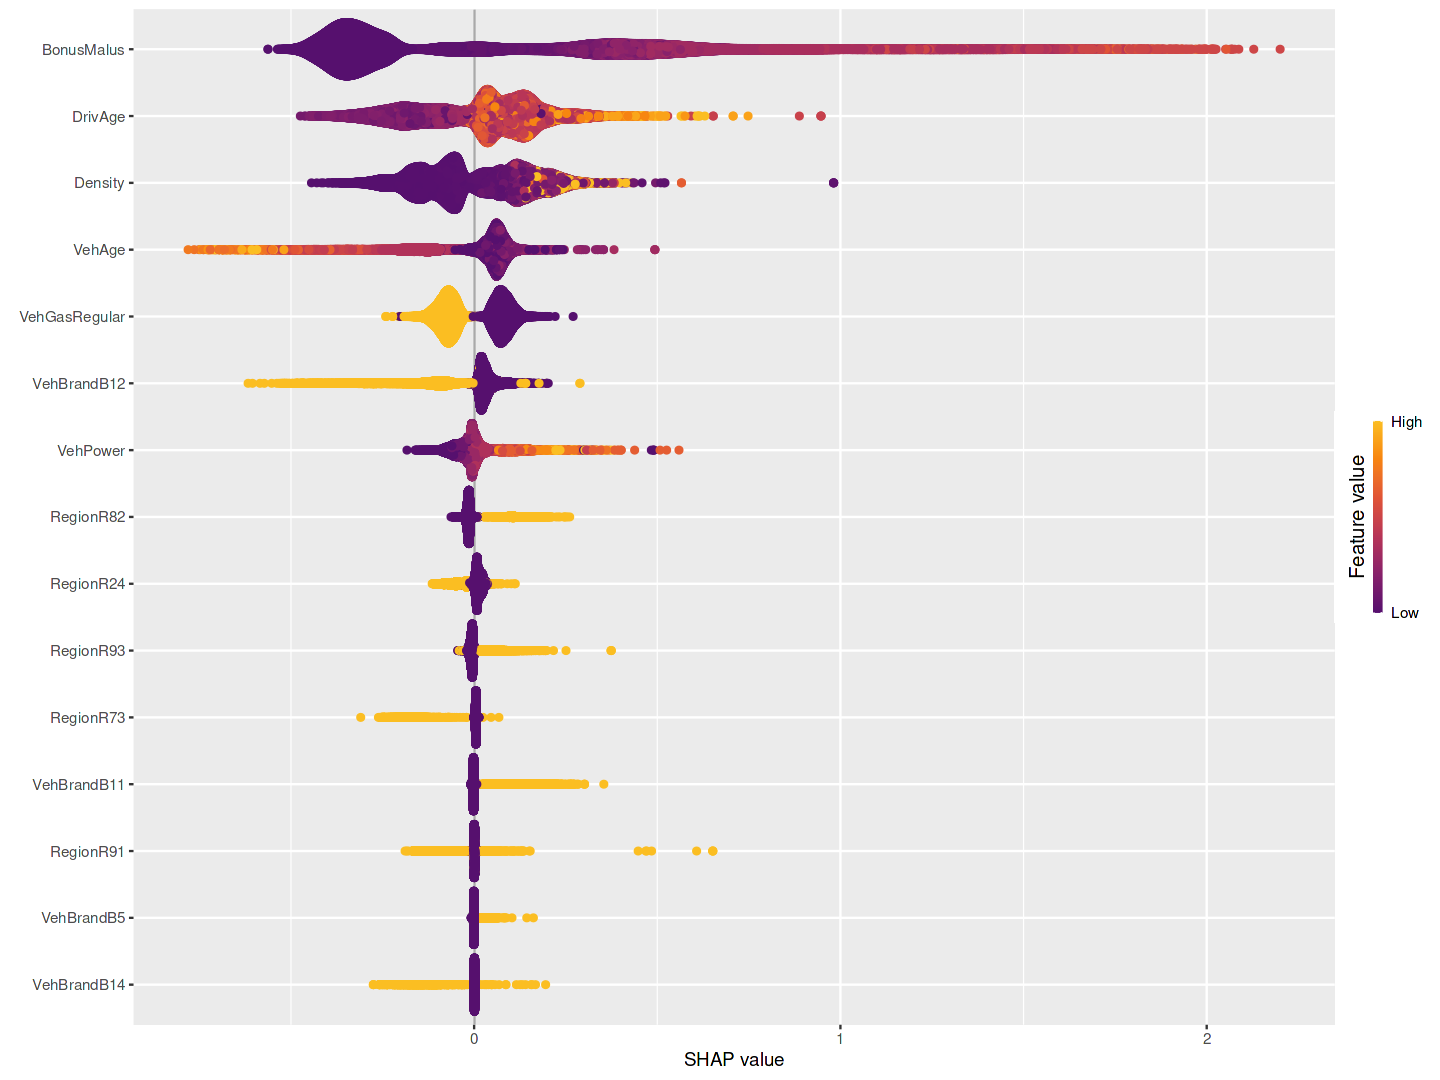

In [58]:
#SHAP importance: summary plot
sv_importance(shap_lgb_test, kind = "bee")

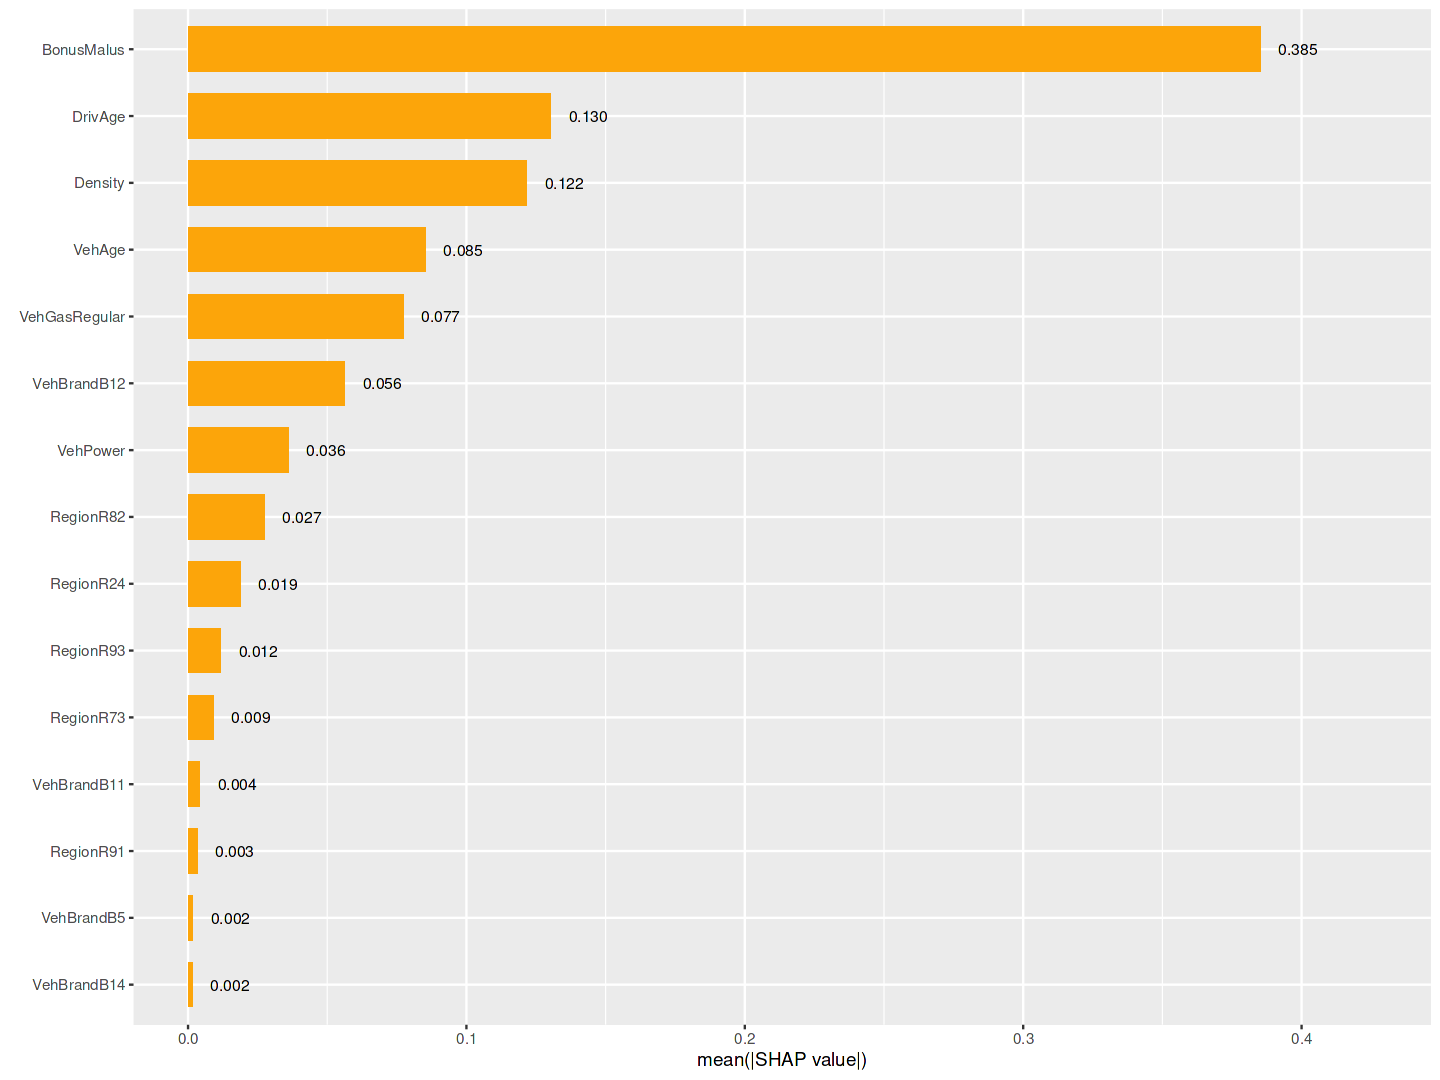

In [59]:
# SHAP feature importance
sv_importance(shap_lgb_test, show_numbers = TRUE)

As expected BonusMalus ist the most important feature, followed by DrivAge, Density and VehAge.

Warning message:
“Removed 3162 rows containing missing values (`geom_point()`).”


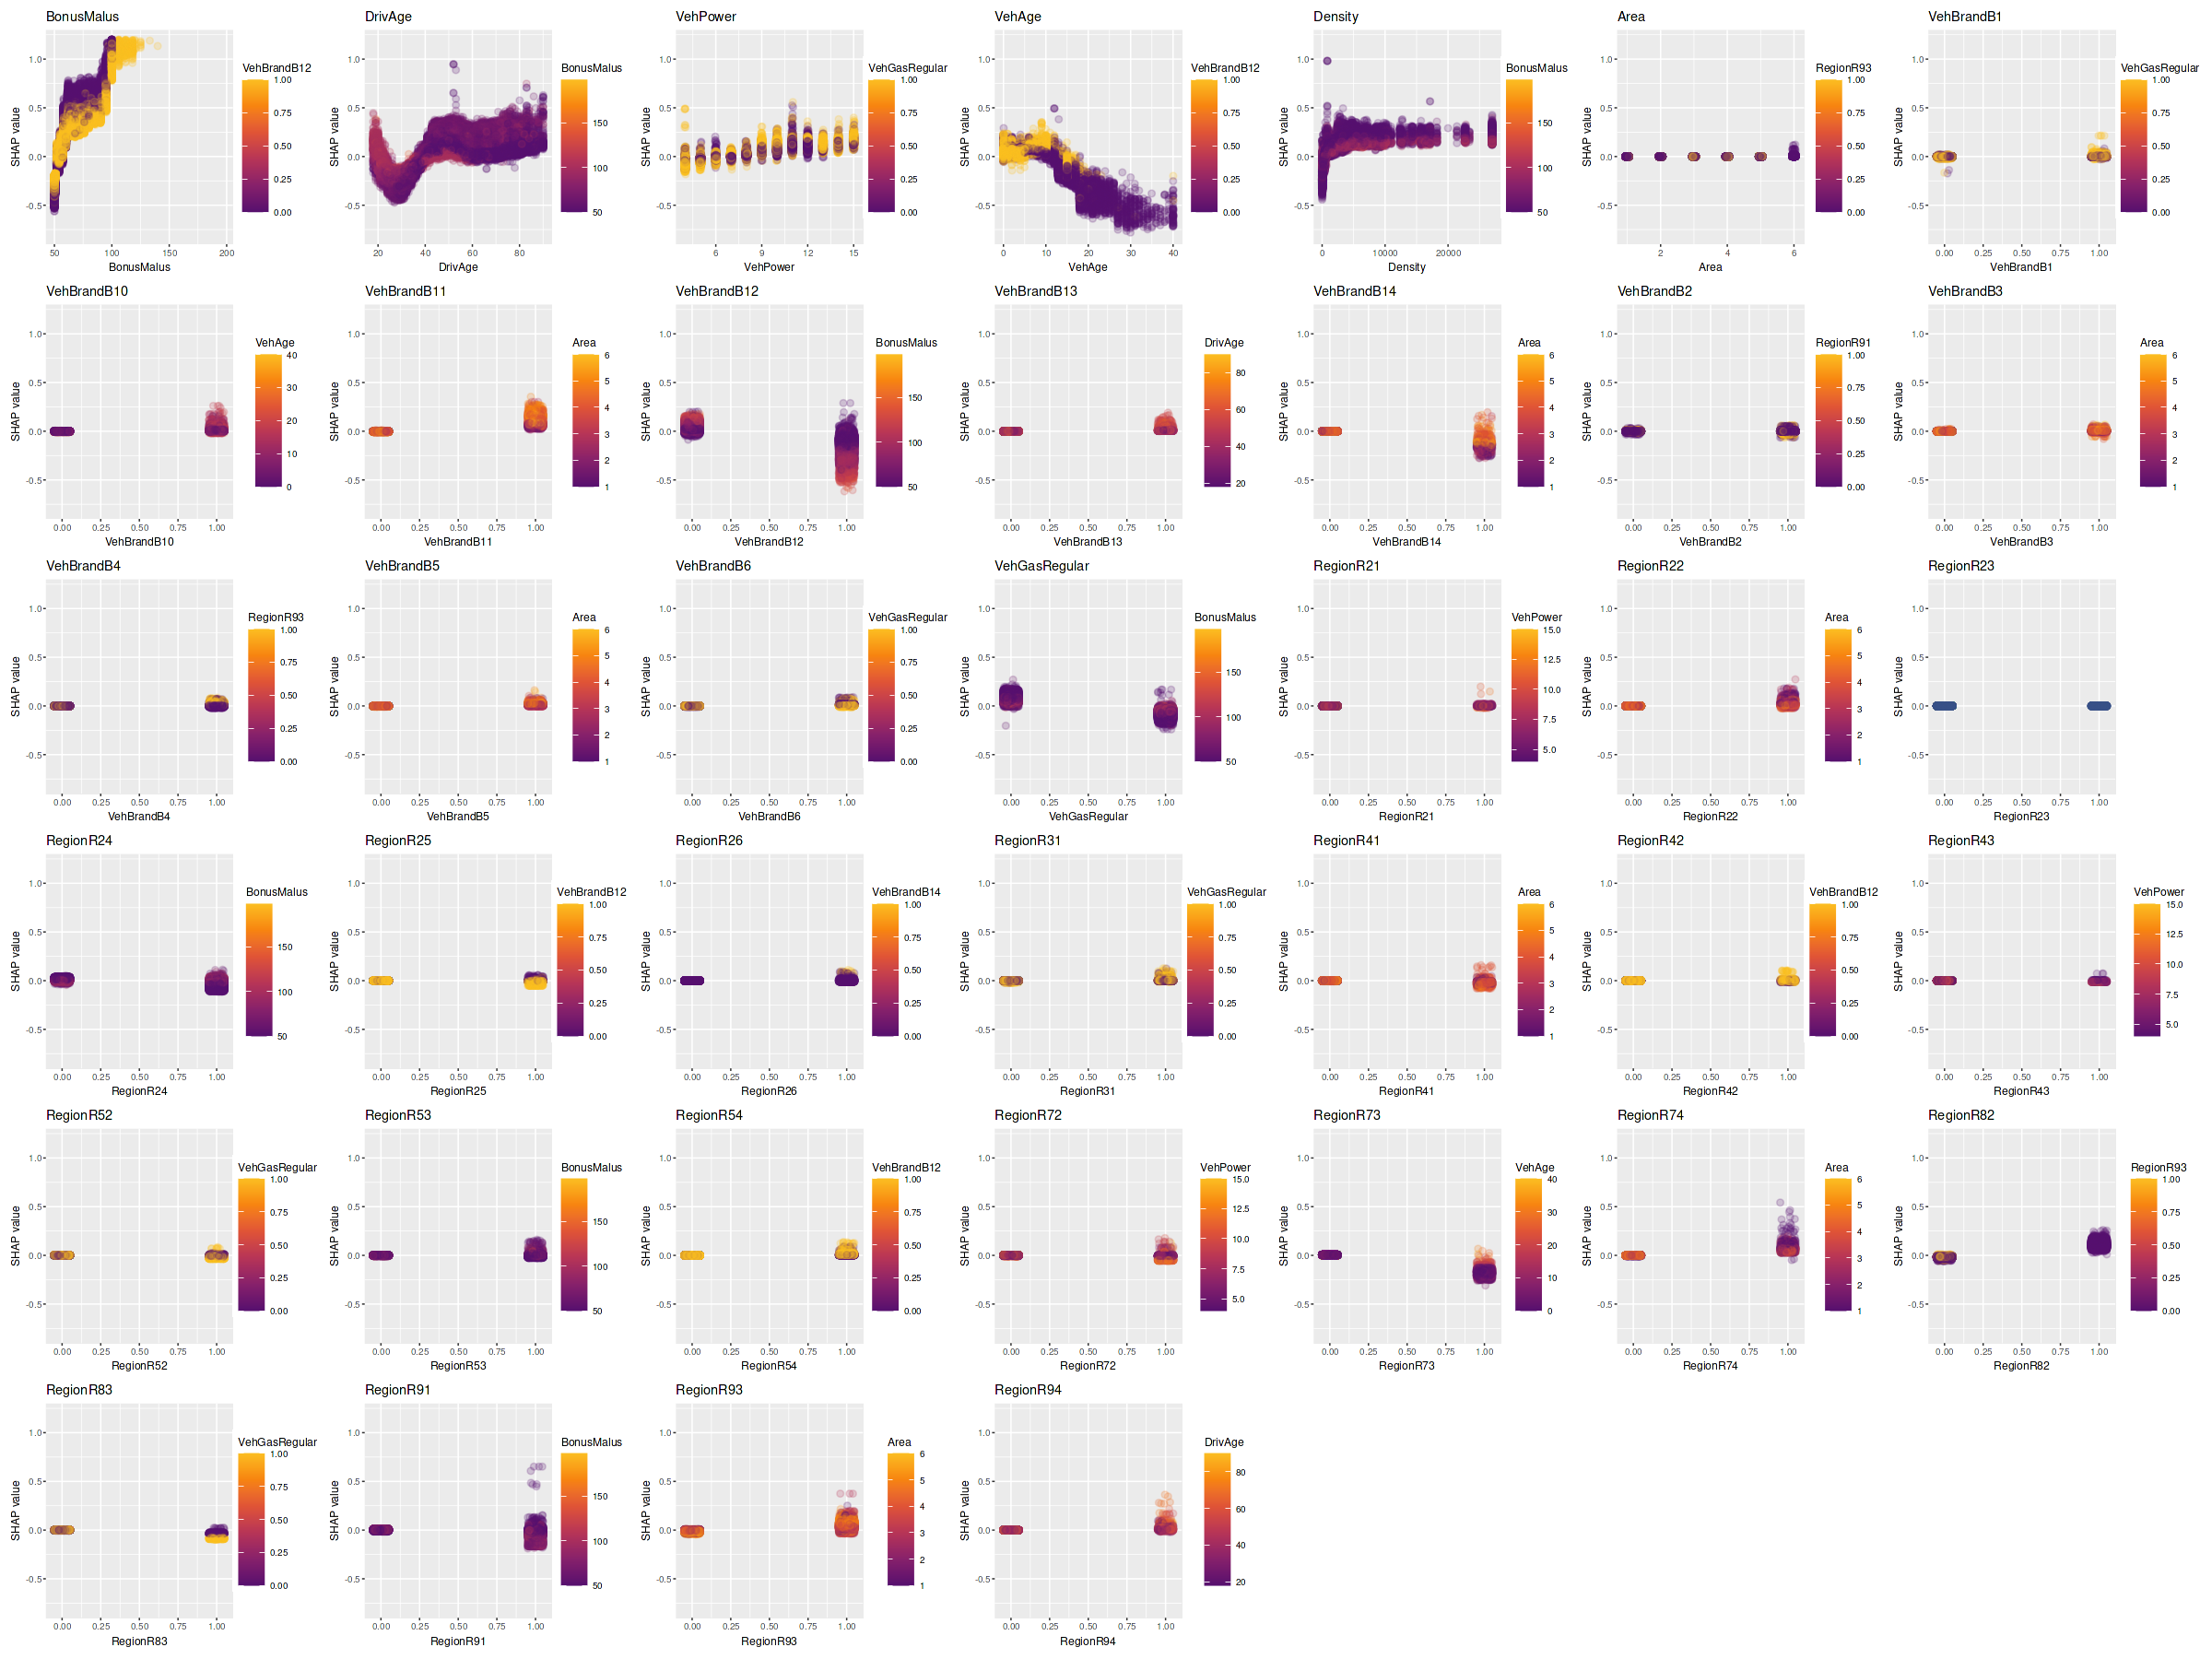

In [60]:
# SHAP dependence plots (note the different y-scales)
options(repr.plot.width=20, repr.plot.height = 15)

theme_set(theme_gray(base_size = 7))

sv_dependence(shap_lgb_test, colnames(X_test), jitter_width = 0.05, alpha = 0.2) &
  ylim(-0.8, 1.2)

options(repr.plot.width=12, repr.plot.height = 7)

#### B) Locally

In [61]:
head(test,4)

IDpol Exposure Area VehPower VehAge DrivAge BonusMalus VehBrand VehGas 
2   3    0.77     D    5        0      55      50         B12      Regular
12 27    0.87     C    7        0      56      50         B12      Diesel 
21 47    0.03     A    6        2      55      50         B12      Regular
22 49    0.81     E    7        0      73      50         B12      Regular
   Density ⋯ fit.cf      fitGLM1     fitGLM2    fitLASSO    fitRIDGE   
2  1217    ⋯ 0.056722609 0.041457824 0.04323763 0.042273331 0.033083808
12  173    ⋯ 0.064089182 0.047130784 0.04863739 0.047245206 0.045920546
21   37    ⋯ 0.002209972 0.001197806 0.00125653 0.001234614 0.002060968
22 3317    ⋯ 0.059669239 0.046084251 0.04359940 0.051576266 0.048254999
   fitGAM3     fitXGB0     fitXGB      fitCB      fitLGB     
2  0.038588702 0.037185138 0.031311153 0.02240850 0.041027549
12 0.043075455 0.049509484 0.051933848 0.02586555 0.058206341
21 0.001120073 0.001520915 0.001512679 0.01092709 0.001324615
22 0.041834420 0.049795545 0.052937178 0.02546205 0.054498501

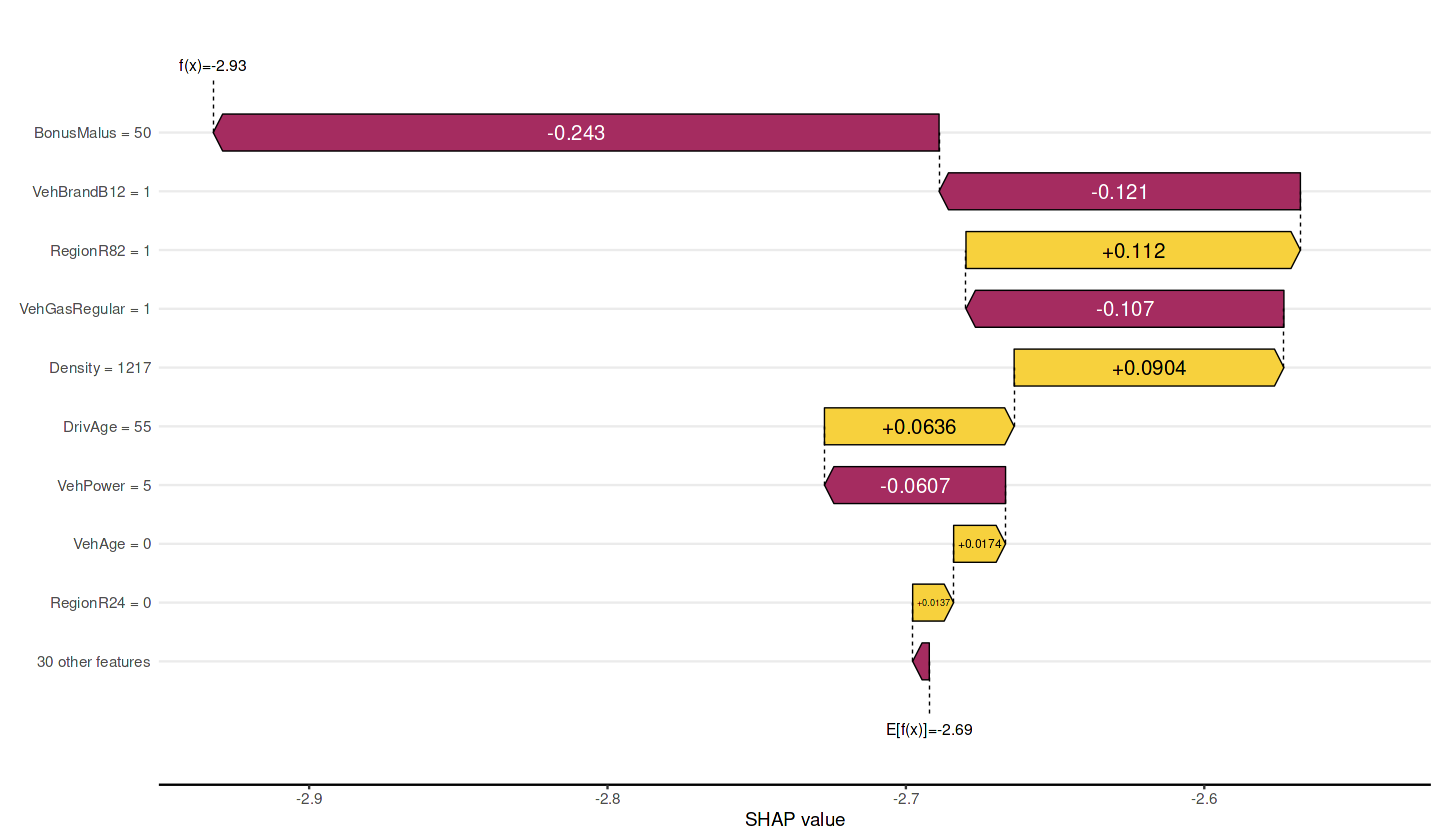

In [62]:
# Waterfall plot of first observation (log-scale)
sv_waterfall(shap_lgb_test, row_id = 1)

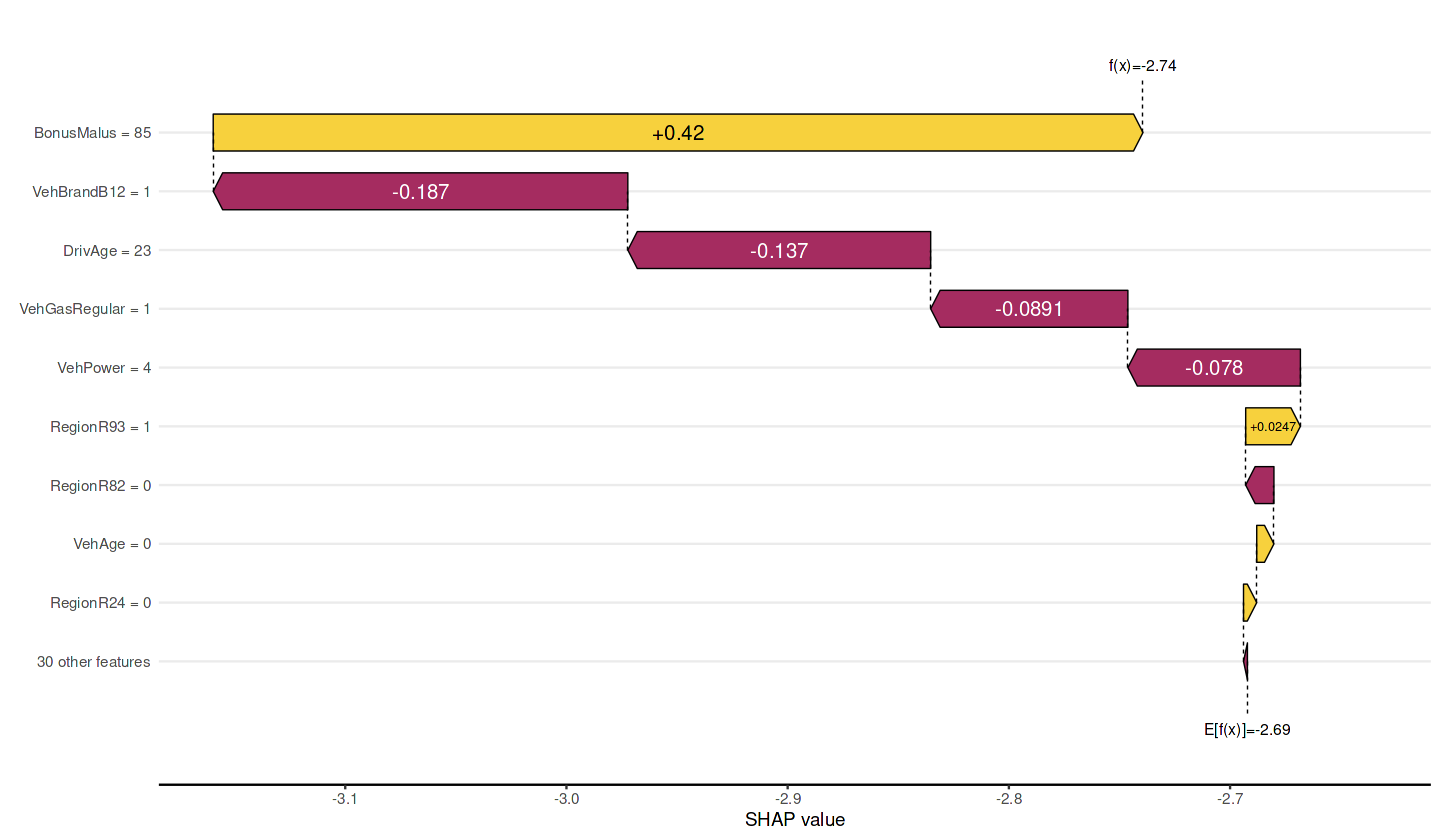

In [63]:
# Waterfall plot of sixth observation
sv_waterfall(shap_lgb_test, row_id = 6)

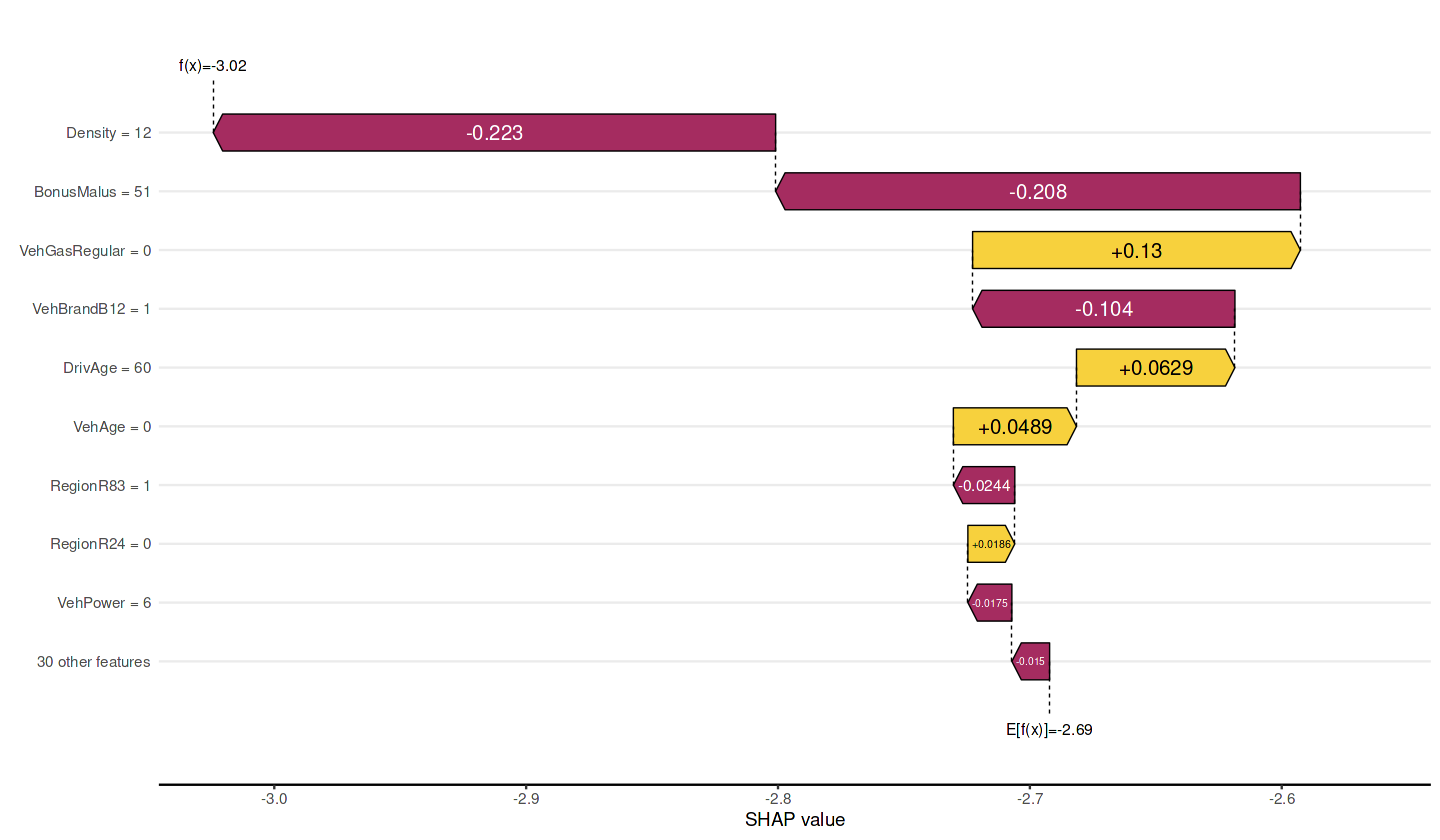

In [64]:
# Waterfall plot of seventh observation
sv_waterfall(shap_lgb_test, row_id = 7)

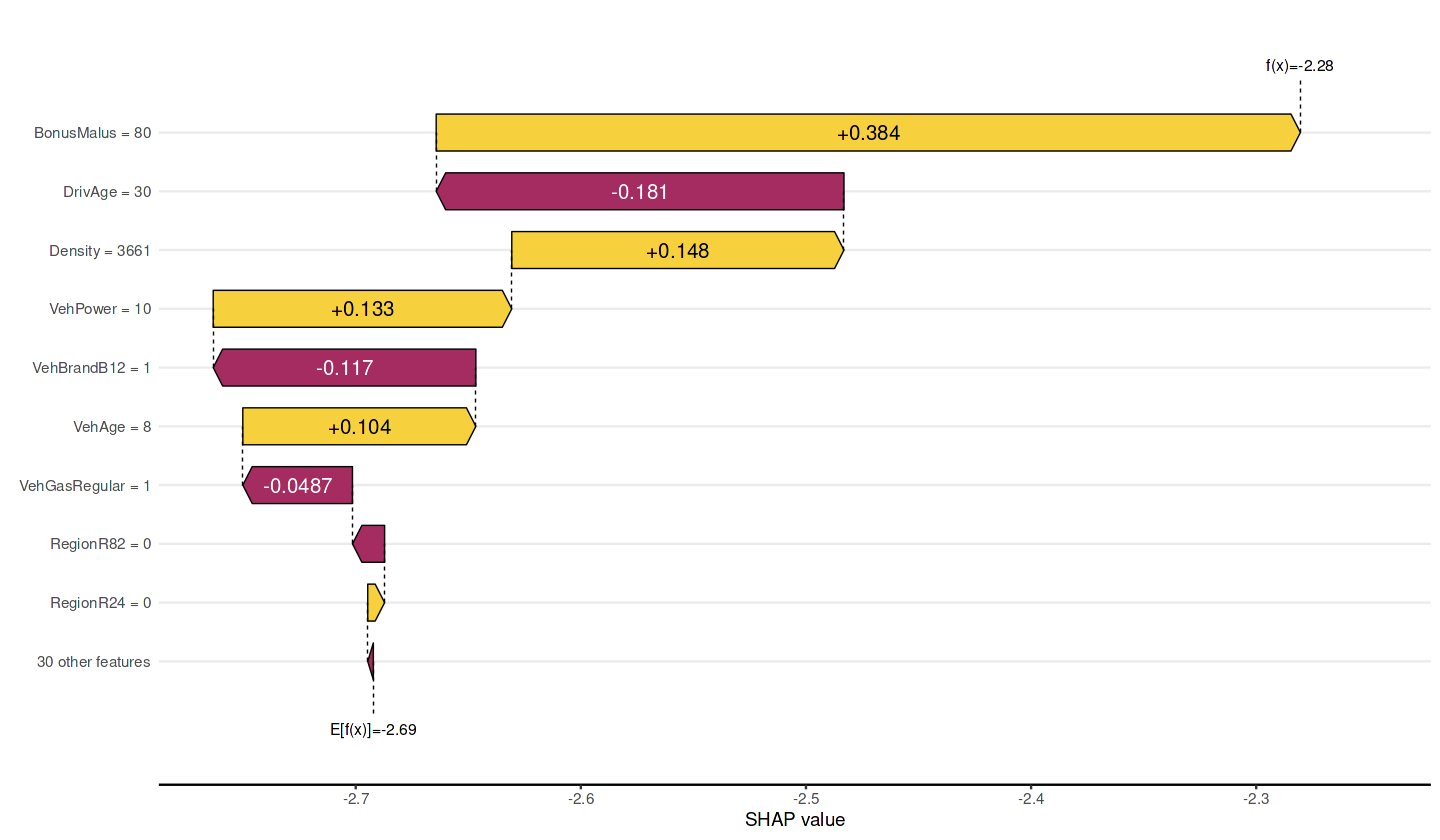

In [65]:
# Waterfall plot of eighth observation
sv_waterfall(shap_lgb_test, row_id = 8)

In summary, we see that waterfall charts are a very accessible way to explain the contribution of features to the predicted value.

### 3.5 Advantages and Disadvantages of Gradient Boosting
The applied gradient boosting method uses decision tree based model ensembles. The main advantage of powerful gradient boosting tools such as XGBoost and LightGBM is the high prediction quality that can be achieved with them, as shown above. Although the computing time required for this is generally longer than for GLMs, it is usually shorter than for comparable high-performance, giant neural networks and can also be reduced by an order of magnitude through the use of GPUs.

The resulting score code can be quite extensive and, depending on existing systems, may require new technologies in its application. If the data does not reflect the current market situation, the score code should not simply be adjusted. Instead, it is recommended to modify the data before modeling accordingly (for example, using a simulation).

Compared to easily understandable small decision trees, a boosted sequence of hundreds of (rather deep) trees is of course difficult to visualize directly. Section 3.4 showed how the results can be interpreted and explained both globally and locally using SHAP.


<a id="ch4"></a>
# 4. Deep Learning Approach with Embeddings and the "CANN"
This is basically a replication of the deep learning models published by Schelldorfer and Wüthrich (2019). The neural networks implemented are fairly small, the focus in this article is not on optimizing hyperparameters. Instead, very interesting ideas such as embeddings and the combined actuarial neural network (CANN) are demonstrated. For further information we recommend the article and the references therein. A brief overview can be found in this presentation (page 6 to 8): https://ethz.ch/content/dam/ethz/special-interest/math/risklab-dam/documents/risk-day/risk-day-2019/Schelldorfer_2019_09_11.pdf. 

Most of the code in this chapter was written and generously shared by Mario Wuthrich, see https://github.com/JSchelldorfer/ActuarialDataScience, Tutorial 3, file "01 CANN approach.r" (February 5, 2019). Due to error messages with Keras version 2.13, layer_add was replaced by layer_multiply and further changes were made to the code and the optimization parameters, which led to an improvement in model performance. 


## 4.1 Pre-Processing

In [66]:
# feature pre-processing 

# min-max-scaler:
PreProcess.Continuous <- function(var1, dat2){
  names(dat2)[names(dat2) == var1]  <- "V1"
  dat2$X <- as.numeric(dat2$V1)
  dat2$X <- 2*(dat2$X-min(dat2$X))/(max(dat2$X)-min(dat2$X))-1
  names(dat2)[names(dat2) == "V1"]  <- var1
  names(dat2)[names(dat2) == "X"]  <- paste(var1,"X", sep="")
  dat2
}

# pre-procecessing function:
Features.PreProcess <- function(dat2){
  dat2 <- PreProcess.Continuous("Area", dat2)   
  dat2 <- PreProcess.Continuous("VehPower", dat2)   
  dat2$VehAge <- pmin(dat2$VehAge,20)
  dat2 <- PreProcess.Continuous("VehAge", dat2)   
  dat2$DrivAge <- pmin(dat2$DrivAge,90)
  dat2 <- PreProcess.Continuous("DrivAge", dat2)   
  dat2$BonusMalus <- pmin(dat2$BonusMalus,150)
  dat2 <- PreProcess.Continuous("BonusMalus", dat2)   
  dat2$VehBrandX <- as.integer(dat2$VehBrand)-1
  dat2$VehGasX <- as.integer(dat2$VehGas)-1.5
  dat2$Density <- round(log(dat2$Density),2)
  dat2 <- PreProcess.Continuous("Density", dat2)   
  dat2$RegionX <- as.integer(dat2$Region)-1  # char R11,,R94 to number 0,,21
  dat2
}

dat2 <- Features.PreProcess(dat)  # original variables and fitGLM2 (CANN)

# Generate small random sample to inspect transformations
sample_n(dat2, 5) 

IDpol   Exposure Area VehPower VehAge DrivAge BonusMalus VehBrand VehGas 
1 1116884 0.02     C    7         1     59       50        B2       Diesel 
2 3147795 1.00     C    6         6     35       90        B1       Diesel 
3 3164475 0.36     E    7         4     56       62        B1       Diesel 
4 6114143 0.03     D    4         0     48      100        B12      Regular
5 3127283 1.00     D    8        17     41       50        B10      Diesel 
  Density ⋯ fitGLM2     AreaX VehPowerX  VehAgeX DrivAgeX    BonusMalusX
1 5.66    ⋯ 0.001273272 -0.2  -0.4545455 -0.9     0.13888889 -1.00      
2 5.26    ⋯ 0.155806047 -0.2  -0.6363636 -0.4    -0.52777778 -0.20      
3 9.05    ⋯ 0.052346961  0.6  -0.4545455 -0.6     0.05555556 -0.76      
4 7.34    ⋯ 0.005412603  0.2  -1.0000000 -1.0    -0.16666667  0.00      
5 6.33    ⋯ 0.058511972  0.2  -0.2727273  0.7    -0.36111111 -1.00      
  VehBrandX VehGasX DensityX   RegionX
1 6         -0.5    0.10980392  4     
2 0         -0.5    0.03137255  4     
3 0         -0.5    0.77450980 17     
4 3          0.5    0.43921569 19     
5 1         -0.5    0.24117647  7

In [67]:
# choosing learning and test sample (based on folds)
dat2$fold <- fold
learn0 <- dat2[dat2$fold != 5,]    # 80%
test0 <- dat2[ dat2$fold == 5,]    # 20%
learn1 <- learn0
test1 <- test0

CF2("Claim Frequency (Actual) Learn/Test", learn$ClaimNb,learn$Exposure, test$ClaimNb,test$Exposure)

[1] "Claim Frequency (Actual) Learn/Test: 7.37% / 7.38%"

In [68]:
# setting up the matrices
features_nn <- c(14:18, 20:21) # definition of feature variables (non-categorical)
q0 <- length(features_nn)
# learning data
Xlearn <- as.matrix(learn0[, features_nn])  # design matrix learning sample
Brlearn <- as.matrix(learn0$VehBrandX)
Relearn <- as.matrix(learn0$RegionX)
Ylearn <- as.matrix(learn0$ClaimNb)
# testing data
Xtest <- as.matrix(test0[, features_nn])    # design matrix test sample
Brtest <- as.matrix(test0$VehBrandX)
Retest <- as.matrix(test0$RegionX)
Ytest <- as.matrix(test0$ClaimNb)
# choosing the right volumes for EmbNN and CANN
Vlearn <- as.matrix(learn0$Exposure)
Vtest <- as.matrix(test0$Exposure)

print(paste("Number of basic features (without VehBrand and Region):",q0))
(lambda.hom <- sum(learn0$ClaimNb)/sum(learn0$Exposure)) 

[1] "Number of basic features (without VehBrand and Region): 7"


[1] 0.07366573

## 4.2 Setting up the Common Neural Network Architecture with Embeddings

In [69]:
# hyperparameters of the neural network architecture (as specified in "01 CANN approach.r") 
q1 <- 20 # Number of neuron in hidden layer 1
q2 <- 15
q3 <- 10
d <- 2   # dimensions embedding layers for categorical features
(BrLabel <- length(unique(learn0$VehBrandX))) 
(ReLabel <- length(unique(learn0$RegionX)))  

[1] 11

[1] 22

In [70]:
library(keras)

neural_net <- function() {

# Initialize neural net and set Tensorflow's random seed
k_clear_session()
set.seed(42)
tensorflow::tf$random$set_seed(42)

# define the network architecture
Design   <- layer_input(shape = c(q0), dtype = 'float32')
VehBrand <- layer_input(shape = c(1),  dtype = 'int8')
Region   <- layer_input(shape = c(1),  dtype = 'int8')
Vol      <- layer_input(shape = c(1),  dtype = 'float32')

BrandEmb = VehBrand %>% 
  layer_embedding(input_dim = BrLabel, output_dim = d, input_length = 1) %>%
  layer_flatten()

RegionEmb = Region %>% 
  layer_embedding(input_dim = ReLabel, output_dim = d, input_length = 1) %>%
  layer_flatten()

Network = list(Design, BrandEmb, RegionEmb) %>% 
  layer_concatenate() %>% 
  layer_dense(units=q1, activation='tanh') %>%
  layer_dense(units=q2, activation='tanh') %>%
  layer_dense(units=q3, activation='tanh') %>%
  layer_dense(units=1, activation='exponential', name='Network', 
              weights=list(array(0, dim=c(q3,1)), array(log(lambda.hom), dim=c(1))))

Response = list(Network, Vol) %>% layer_multiply()

model = keras_model(inputs = c(Design, VehBrand, Region, Vol), outputs = c(Response))

model %>% compile(loss = 'poisson', optimizer = optimizer_nadam(), weighted_metrics = 'poisson')

return(model)

}

# Check names of tf.random
names(tensorflow::tf$random)

[1] "Algorithm"                               
 [2] "all_candidate_sampler"                   
 [3] "categorical"                             
 [4] "create_rng_state"                        
 [5] "experimental"                            
 [6] "fixed_unigram_candidate_sampler"         
 [7] "gamma"                                   
 [8] "Generator"                               
 [9] "get_global_generator"                    
[10] "learned_unigram_candidate_sampler"       
[11] "log_uniform_candidate_sampler"           
[12] "normal"                                  
[13] "poisson"                                 
[14] "set_global_generator"                    
[15] "set_seed"                                
[16] "shuffle"                                 
[17] "stateless_binomial"                      
[18] "stateless_categorical"                   
[19] "stateless_gamma"                         
[20] "stateless_normal"                        
[21] "stateless_parameterized_truncated_normal"
[22] "stateless_poisson"                       
[23] "stateless_truncated_normal"              
[24] "stateless_uniform"                       
[25] "truncated_normal"                        
[26] "uniform"                                 
[27] "uniform_candidate_sampler"

## 4.3 Fitting the Neural Network with Embeddings (NNemb)

In [71]:
# Create, compile and summarize a neural network with the parameterization defined above
model1 <- neural_net()
summary(model1)

Model: "model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_2 (InputLayer)     [(None, 1)]       0        []                         
 input_3 (InputLayer)     [(None, 1)]       0        []                         
 embedding (Embedding)    (None, 1, 2)      22       ['input_2[0][0]']          
 embedding_1 (Embedding)  (None, 1, 2)      44       ['input_3[0][0]']          
 input_1 (InputLayer)     [(None, 7)]       0        []                         
 flatten (Flatten)        (None, 2)         0        ['embedding[0][0]']        
 flatten_1 (Flatten)      (None, 2)         0        ['embedding_1[0][0]']      
 concatenate (Concatenate  (None, 11)       0        ['input_1[0][0]',          
 )                                                    'flatten[0][0]',          
                                                      'flatten_1[0][0]']        
 dense_2 (Den

   user  system elapsed 
413.852  26.653 264.933 

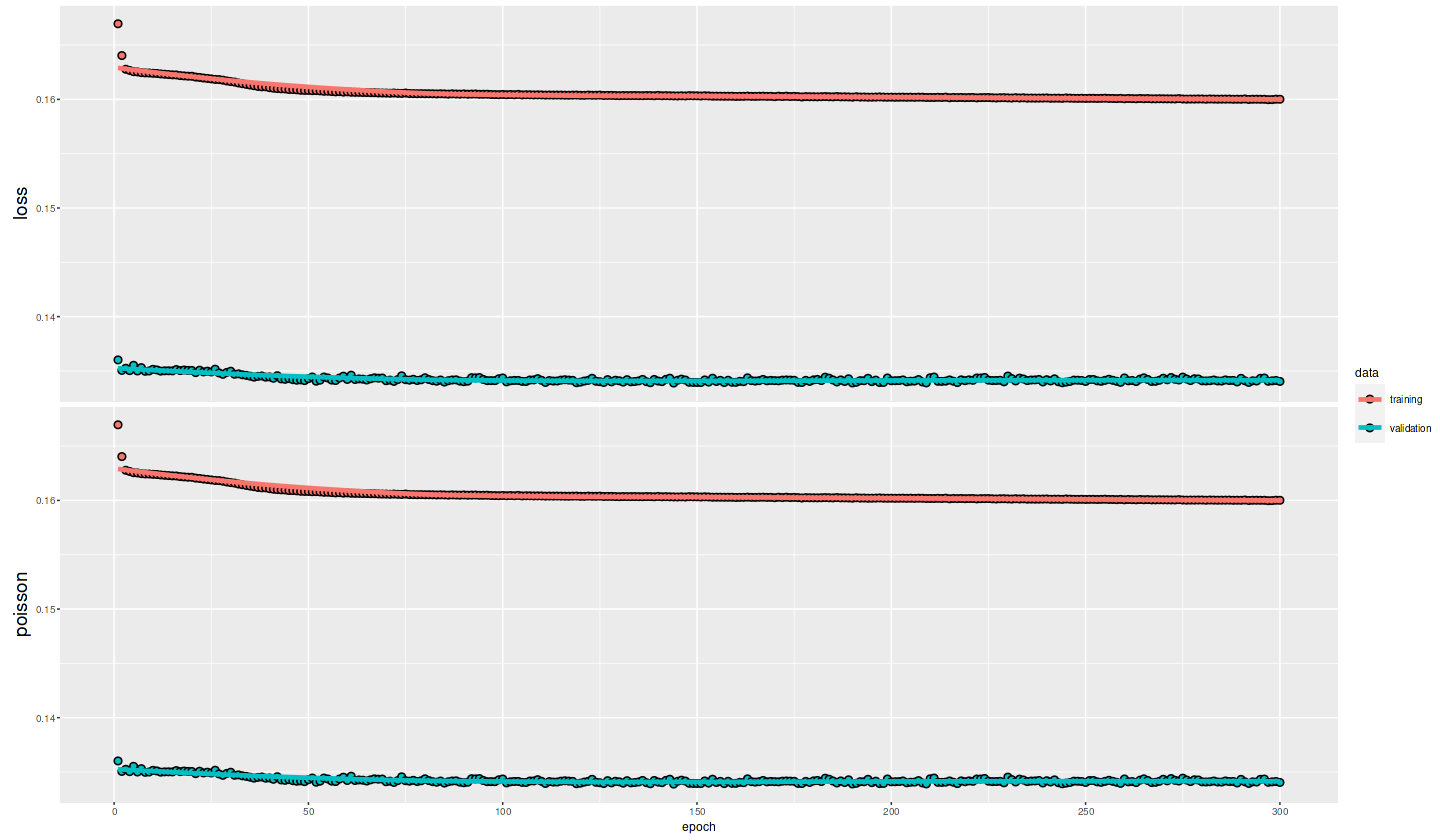

In [72]:
set.seed(42) # set seed again
# fitting the neural network (as specified in "01 CANN approach.r") 
{t1 <- proc.time()
  fit <- model1 %>% fit(list(Xlearn, Brlearn, Relearn, Vlearn), Ylearn, epochs=300, 
                       batch_size=5000, verbose=0, validation_split=0.2)
  (proc.time()-t1)}

plot(fit)

In [73]:
# calculating the predictions
learn0$fitNNemb <- as.vector(model1 %>% predict(list(Xlearn, Brlearn, Relearn, Vlearn)))
test0$fitNNemb <- as.vector(model1 %>% predict(list(Xtest, Brtest, Retest, Vtest)))

# Print claim frequency actual vs predicted
CF2("Claim Frequency NNemb, Test-Sample, Actual/Predicted", test0$ClaimNb,test0$Exposure, test0$fitNNemb,test0$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance NNemb", learn0$fitNNemb,as.vector(unlist(learn0$ClaimNb)),learn0$Exposure, test0$fitNNemb,as.vector(unlist(test0$ClaimNb)),test0$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("NNemb", test0$fitNNemb)

[1] "Claim Frequency NNemb, Test-Sample, Actual/Predicted: 7.38% / 7.28%"

[1] "Poisson Deviance NNemb, Learn/Test: 28.91% / 29.05%"

[1] "GLM2-Improvement-Index (PD test) of NNemb: 129.3%"

## 4.4 The Combined Actuarial Neural Network with GLM2 (CANN)

In [74]:
# Incorporating model GLM2 into a CANN
Vlearn <- as.matrix(learn$fitGLM2)
Vtest <- as.matrix(test$fitGLM2)
(lambda.hom <- sum(learn$ClaimNb)/sum(learn$fitGLM2))

[1] 1

In [75]:
# Create, compile and summarize a neural network with the parameterization defined above
model2 <- neural_net()
summary(model2)

Model: "model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_2 (InputLayer)     [(None, 1)]       0        []                         
 input_3 (InputLayer)     [(None, 1)]       0        []                         
 embedding (Embedding)    (None, 1, 2)      22       ['input_2[0][0]']          
 embedding_1 (Embedding)  (None, 1, 2)      44       ['input_3[0][0]']          
 input_1 (InputLayer)     [(None, 7)]       0        []                         
 flatten (Flatten)        (None, 2)         0        ['embedding[0][0]']        
 flatten_1 (Flatten)      (None, 2)         0        ['embedding_1[0][0]']      
 concatenate (Concatenate  (None, 11)       0        ['input_1[0][0]',          
 )                                                    'flatten[0][0]',          
                                                      'flatten_1[0][0]']        
 dense_2 (Den

   user  system elapsed 
124.001   7.613  71.409 

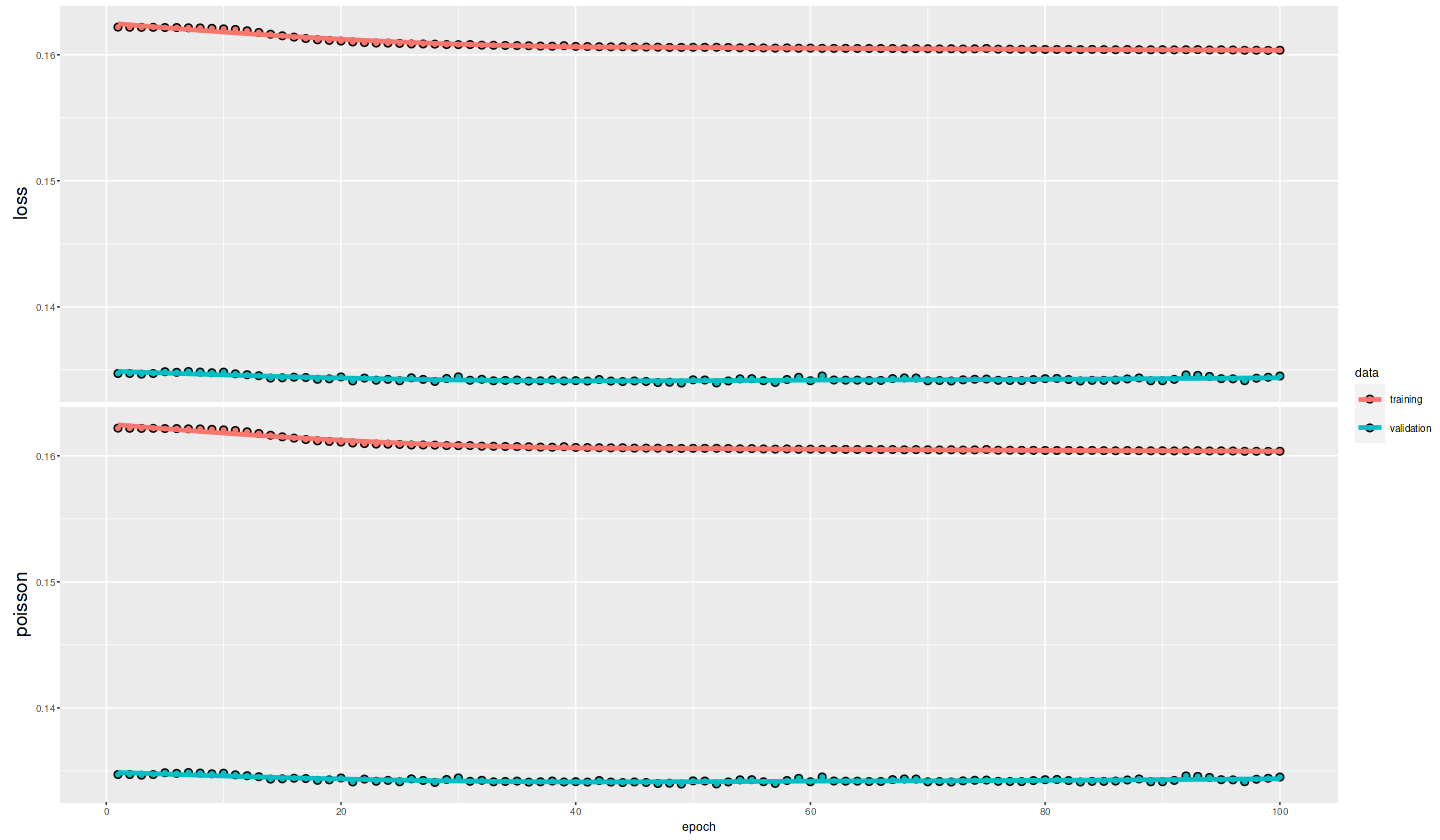

In [76]:
# re-fitting the neural network with GLM2-CANN
{t1 <- proc.time()
  fit <- model2 %>% fit(list(Xlearn, Brlearn, Relearn, Vlearn), Ylearn, epochs=100, 
                       batch_size=5000, verbose=0, validation_split=0.2)
  (proc.time()-t1)}

plot(fit)

In [77]:
# calculating the predictions
learn1$fitNNGLM <- as.vector(model2 %>% predict(list(Xlearn, Brlearn, Relearn, Vlearn)))
test1$fitNNGLM <- as.vector(model2 %>% predict(list(Xtest, Brtest, Retest, Vtest)))

# Print claim frequency actual vs predicted
CF2("Claim Frequency CANN, Test-Sample, Actual/Predicted", test1$ClaimNb,test1$Exposure, test1$fitNNGLM,test1$Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance CANN", learn1$fitNNGLM,as.vector(unlist(learn1$ClaimNb)),learn1$Exposure, test1$fitNNGLM,as.vector(unlist(test1$ClaimNb)),test1$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("CANN", test1$fitNNGLM)

[1] "Claim Frequency CANN, Test-Sample, Actual/Predicted: 7.38% / 7.92%"

[1] "Poisson Deviance CANN, Learn/Test: 29.09% / 29.22%"

[1] "GLM2-Improvement-Index (PD test) of CANN: 118.3%"

## 4.5 Visualization of 2Dim-Embeddings: NNemb vs. CANN 

Source: https://www.kaggle.com/code/floser/glm-nn-embeddings-and-gbm-for-claim-frequency

### a) "VehBrand"

In [78]:
# Get weights embedding VehBrand for model1 (NNemb) and model2 (CANN)
Brand <- c('B1','B10','B11','B12','B13','B14','B2','B3','B4','B5','B6')
emb_B1 <- get_weights(model1)[[1]]
emb_B1 <- cbind(Brand, as.data.frame(emb_B1)) 
colnames(emb_B1)<-c("Brand","dim1","dim2")
emb_B2 <- get_weights(model2)[[1]]
emb_B2 <- cbind(Brand, as.data.frame(emb_B2)) 
colnames(emb_B2)<-c("Brand","dim1","dim2")

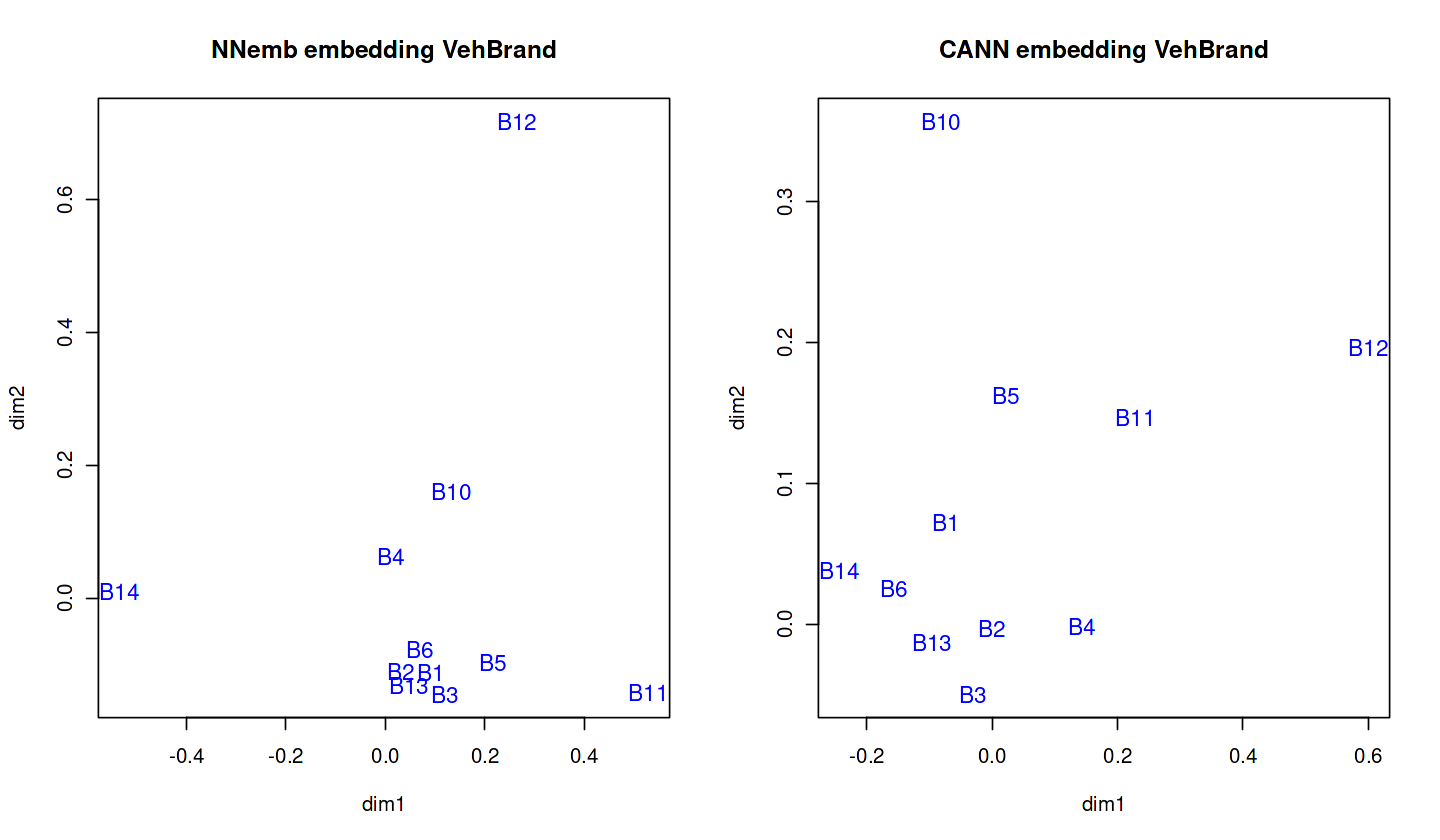

In [79]:
# Plot embeddings
par(mfrow=c(1,2)) 
plot(data=emb_B1, dim2~dim1, pch=3, col="red",cex=0.0, main='NNemb embedding VehBrand')
with(data=emb_B1, text(dim2~dim1, labels=Brand, col="blue",cex=1.1), pos=1)
plot(data=emb_B2, dim2~dim1, pch=3, col="red",cex=0.0, main='CANN embedding VehBrand')
with(data=emb_B2, text(dim2~dim1, labels=Brand, col="blue",cex=1.1), pos=1)

### b) "Region"

In [80]:
# Get weights embedding Region for model1 (NNemb) and model2 (CANN)
Region <- c('R11','R21','R22','R23','R24','R25','R26','R31','R41','R42','R43',
           'R52','R53','R54','R72','R73','R74','R82','R83','R91','R93','R94')
emb_R1 <- get_weights(model1)[[2]]
emb_R1 <- cbind(Region, as.data.frame(emb_R1)) 
colnames(emb_R1)<-c("Region","dim1","dim2")
emb_R2 <- get_weights(model2)[[2]]
emb_R2 <- cbind(Region, as.data.frame(emb_R2)) 
colnames(emb_R2)<-c("Region","dim1","dim2")

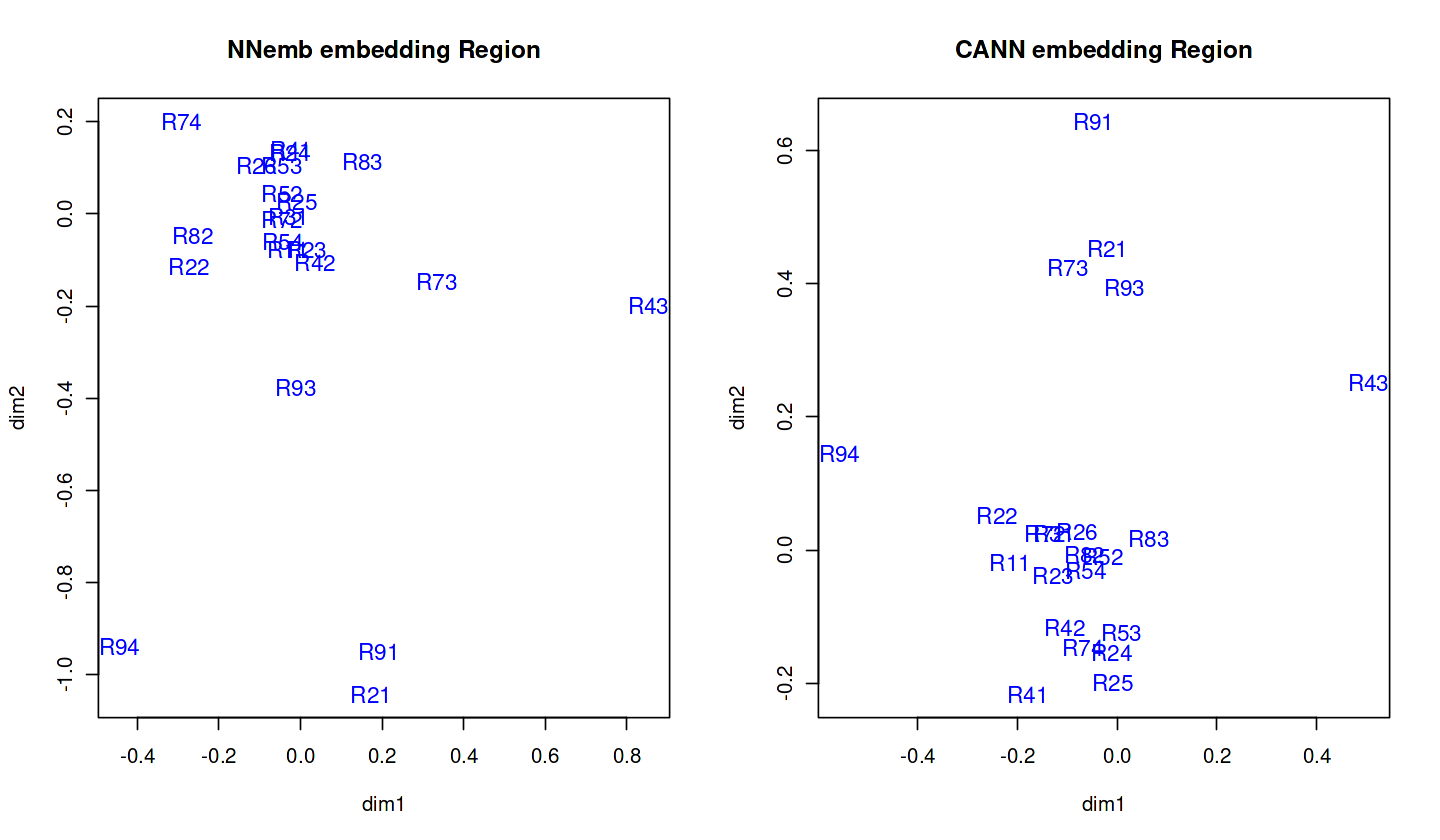

In [81]:
# Plot embeddings
par(mfrow=c(1,2)) 
plot(data=emb_R1, dim2~dim1, pch=3, col="red",cex=0.0, main='NNemb embedding Region')
with(data=emb_R1, text(dim2~dim1, labels=Region, col="blue",cex=1.1), pos=1)
plot(data=emb_R2, dim2~dim1, pch=3, col="red",cex=0.0, main='CANN embedding Region')
with(data=emb_R2, text(dim2~dim1, labels=Region, col="blue",cex=1.1), pos=1)

## 4.6 The monotonic CANN (NNGLMc)
To obtain monotonous behavior in BonusMalus, we remove it from the feature list of the neural network.

In [82]:
# changing the matrices (exclude BonusMalus, col18)
features_nn <- c(14:17, 20:21) # definition of feature variables (non-categorical)
q0 <- length(features_nn)
print(paste("Number of basic features (without VehBrand and Region):",q0))
# learning data
Xlearn <- as.matrix(learn0[, features_nn])  # design matrix learning sample
Brlearn <- as.matrix(learn0$VehBrandX)
Relearn <- as.matrix(learn0$RegionX)
Ylearn <- as.matrix(learn0$ClaimNb)
# testing data
Xtest <- as.matrix(test0[, features_nn])    # design matrix test sample
Brtest <- as.matrix(test0$VehBrandX)
Retest <- as.matrix(test0$RegionX)
Ytest <- as.matrix(test0$ClaimNb)

# Incorporating model GLM2 into a CANN
Vlearn <- as.matrix(learn$fitGLM2)
Vtest <- as.matrix(test$fitGLM2)
(lambda.hom <- sum(learn$ClaimNb)/sum(learn$fitGLM2))

[1] "Number of basic features (without VehBrand and Region): 6"


[1] 1

In [83]:
# Create, compile and summarize a neural network with the parameterization defined above
model <- neural_net()
summary(model)

Model: "model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_2 (InputLayer)     [(None, 1)]       0        []                         
 input_3 (InputLayer)     [(None, 1)]       0        []                         
 embedding (Embedding)    (None, 1, 2)      22       ['input_2[0][0]']          
 embedding_1 (Embedding)  (None, 1, 2)      44       ['input_3[0][0]']          
 input_1 (InputLayer)     [(None, 6)]       0        []                         
 flatten (Flatten)        (None, 2)         0        ['embedding[0][0]']        
 flatten_1 (Flatten)      (None, 2)         0        ['embedding_1[0][0]']      
 concatenate (Concatenate  (None, 10)       0        ['input_1[0][0]',          
 )                                                    'flatten[0][0]',          
                                                      'flatten_1[0][0]']        
 dense_2 (Den

The model is now 20 weights smaller.

   user  system elapsed 
 27.167   1.626  16.332 

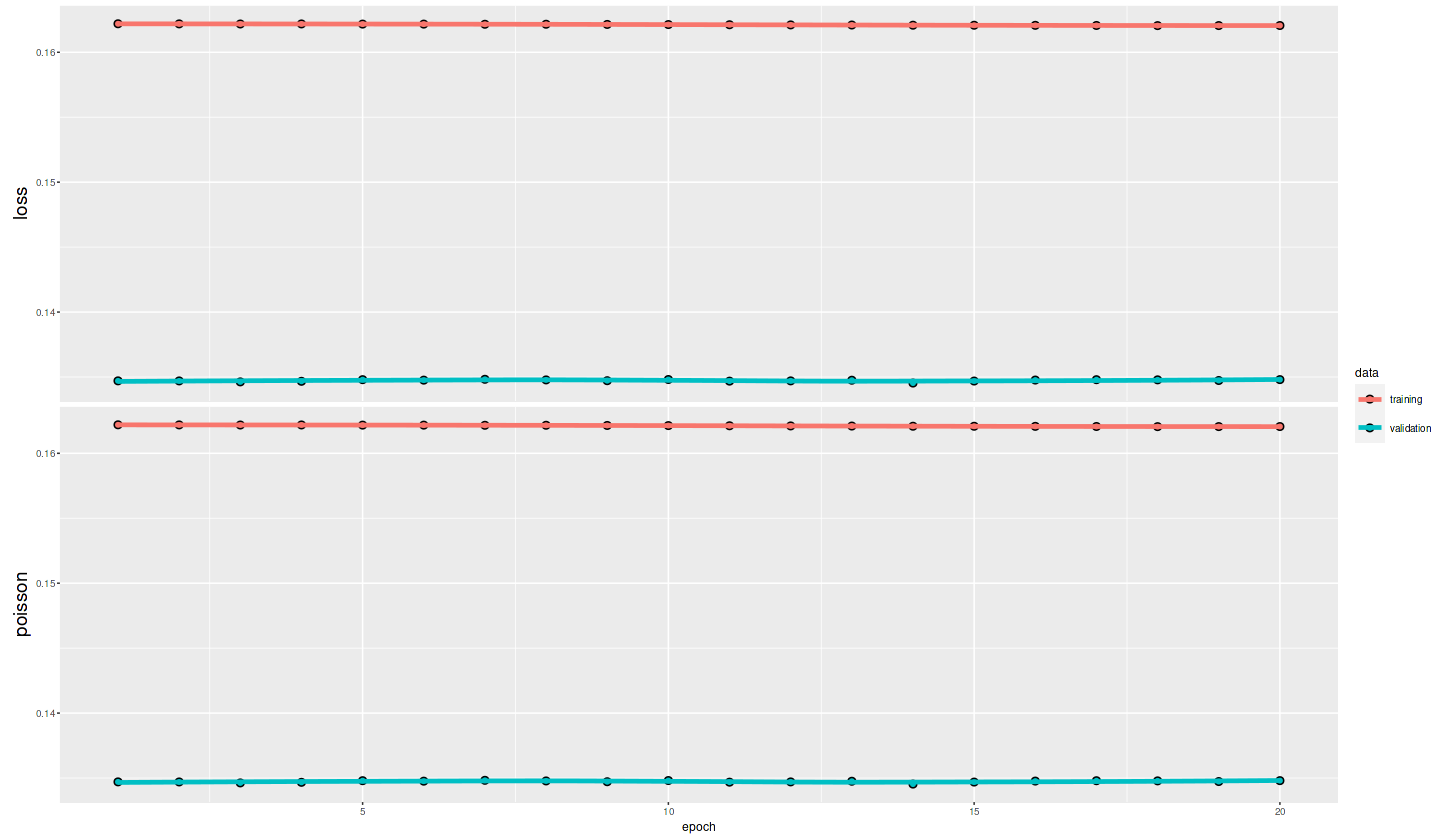

In [84]:
# re-fitting the neural network with GLM2-CANN
{t1 <- proc.time()
  fit <- model %>% fit(list(Xlearn, Brlearn, Relearn, Vlearn), Ylearn, epochs=20, 
                       batch_size=5000, verbose=0, validation_split=0.2)
  (proc.time()-t1)}

plot(fit)

In [85]:
# calculating the predictions
learn1$fitNNGLMc <- as.vector(model %>% predict(list(Xlearn, Brlearn, Relearn, Vlearn)))
test1$fitNNGLMc <- as.vector(model %>% predict(list(Xtest, Brtest, Retest, Vtest)))

# Print Poisson Deviance
PDW2("Poisson Deviance NNGLMc", learn1$fitNNGLMc,as.vector(unlist(learn1$ClaimNb)),learn1$Exposure, test1$fitNNGLMc,as.vector(unlist(test1$ClaimNb)),test1$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("NNGLMc", test1$fitNNGLMc)

[1] "Poisson Deviance NNGLMc, Learn/Test: 29.54% / 29.54%"

[1] "GLM2-Improvement-Index (PD test) of NNGLMc: 98.0%"

Depending on the random initialization of the weights, the performance of the monotonic CANN (NNGLMc) is comparable to the performance of the classical GLM2 model despite fluctuations. Since this is not an improvement, but much more complicated, we will not pursue this path further.

<a id="ch5"></a>
# 5. Back to GLM and GAM: Interactions

We have observed in Sections 4 and 5 that machine learning techniques such as Gradient Boosting consistently outperform the classical GLM approach. These machine learning methods excel in capturing complex interactions and nonlinear relationships within the data. So, how can we leverage this insight to enhance our GLMs? And does this work as well for GAMs? In this section, we specifically concentrate on identifying and integrating relevant interactions.

## 5.1 Interactions with EIX

The EIX package provides tools to explore the structure of XGBoost and LightGBM models. Specifically, it helps us to identify feature interactions that contribute significantly to the model performance withinthe XGBoost and LightGBM models.

In [86]:
# from xgboost model
install.packages("EIX")
library(EIX)

{t1 <- proc.time()
  inter.xgb <-interactions(fit.xgb, dtrain)
(proc.time()-t1)}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   user  system elapsed 
168.165   0.505 168.279 

In [87]:
# from lgb
{t1 <- proc.time()
  inter.lgb <-interactions(LGB, llearn)
(proc.time()-t1)}

   user  system elapsed 
 79.441   0.309  79.703 

`summarise()` has grouped output by 'Parent'. You can override using the
`.groups` argument.


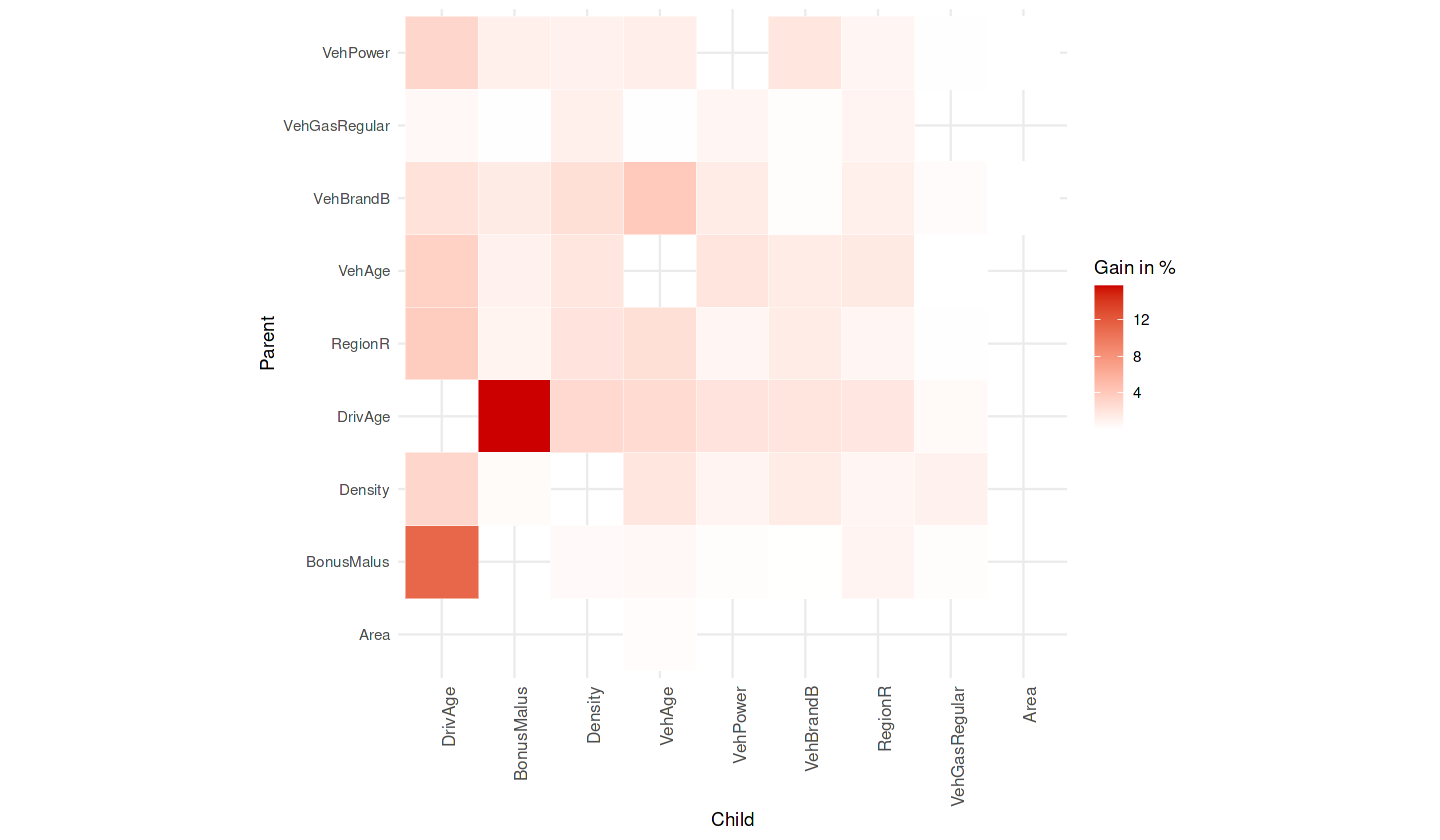

In [88]:
# Summarize one-hot-encoded features
to_delete <- c("1|2|3|4|5|6|7|8|9|0")

df.inter.xgb <- as.data.frame(inter.xgb)
df.inter.xgb$Parent <- str_remove_all(inter.xgb$Parent, to_delete)
df.inter.xgb$Child <- str_remove_all(inter.xgb$Child, to_delete)
df.inter.xgb$sumGain <- df.inter.xgb$sumGain / sum(df.inter.xgb$sumGain) * 100

df.inter.xgb %>%
  group_by(Parent, Child) %>%
  summarise(sumGain = sum(sumGain),
            frequency = sum(frequency)) %>%
  ungroup() %>%
  arrange(desc(sumGain)) %>%
  ggplot(mapping = aes(
    x = reorder(Child, desc(sumGain)),
    y = Parent,
    fill = sumGain  )) +
  xlab(label = "Child") +
  labs(fill = "Gain in %") +
  geom_tile(aes(fill = sumGain), color = "white") +
  scale_fill_gradient(low = "white", high = "red3") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 90,
      vjust = 1,
      size = 10,
      hjust = 1  ),
      legend.position = "right"  ) +
  coord_fixed()

`summarise()` has grouped output by 'Parent'. You can override using the
`.groups` argument.


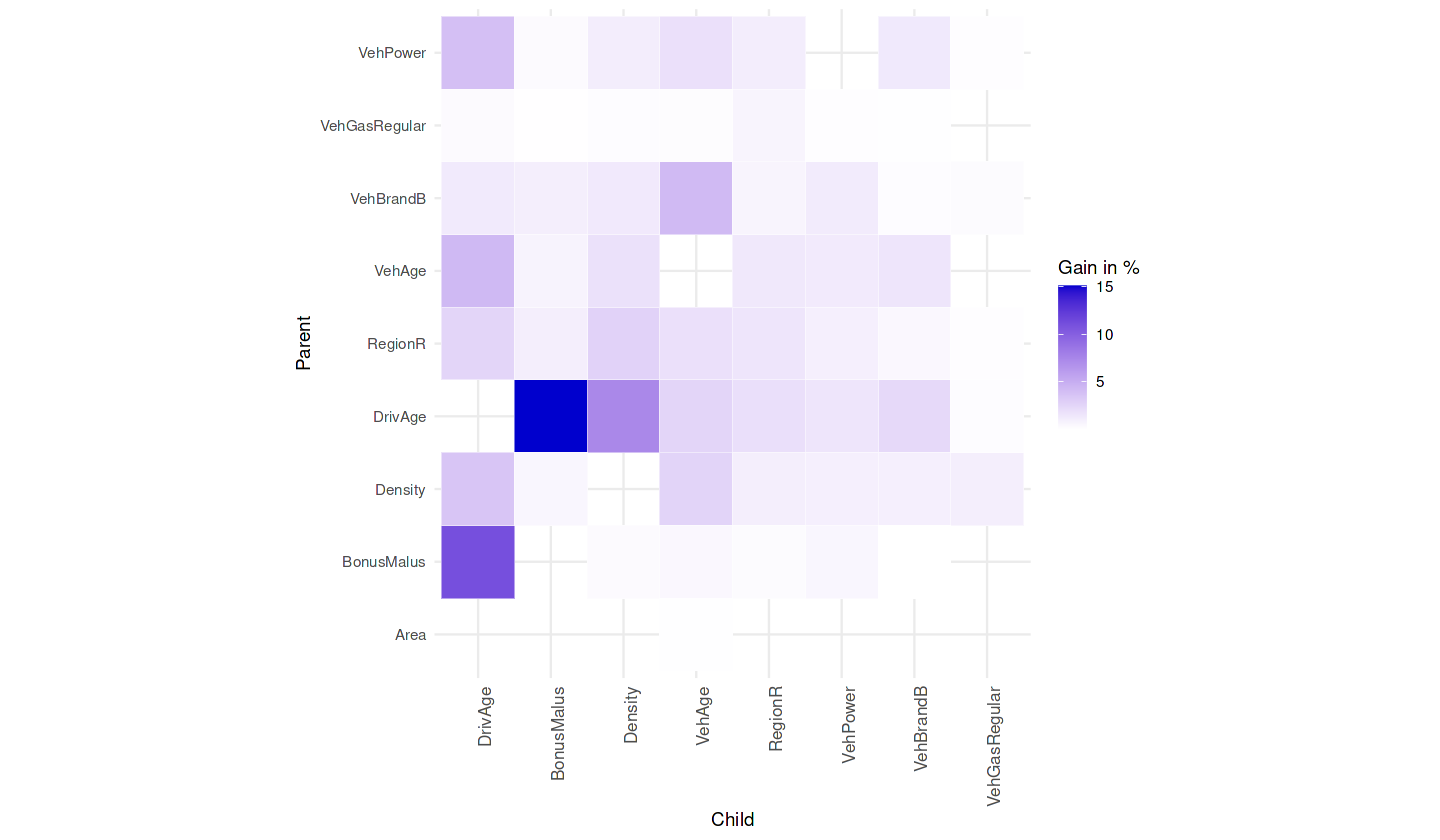

In [89]:
df.inter.lgb <- as.data.frame(inter.lgb)
df.inter.lgb$Parent <- str_remove_all(inter.lgb$Parent, to_delete)
df.inter.lgb$Child <- str_remove_all(inter.lgb$Child, to_delete)
df.inter.lgb$sumGain <- df.inter.lgb$sumGain / sum(df.inter.lgb$sumGain) * 100

df.inter.lgb %>%
  group_by(Parent, Child) %>%
  summarise(sumGain = sum(sumGain),
            frequency = sum(frequency)) %>%
  ungroup() %>%
  arrange(desc(sumGain)) %>%
  ggplot(mapping = aes(
    x = reorder(Child, desc(sumGain)),
    y = Parent,
    fill = sumGain  )) +
  xlab(label = "Child") +
  labs(fill = "Gain in %") +
  geom_tile(aes(fill = sumGain), color = "white") +
  scale_fill_gradient(low = "white", high = "blue3") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 90,
      vjust = 1,
      size = 10,
      hjust = 1  ),
      legend.position = "right"  ) +
  coord_fixed()

Interactions which include the Age of the driver are most important in both models. The highest gain is achieved vy the interaction DrivAge:BonusMalus. Overall, it can be said that the interaction importance of the 2-way interactions in both models is mostly the same.

## 5.2 Interactions with SHAP

Another way to identify interactions comes with the treeshap package previously used in 3.4. Due to longer processing times, we limit the interaction analysis with SHAP to the DriveAge feature. We furthermore use the already generated SHAP-Explainer for LightGBM.

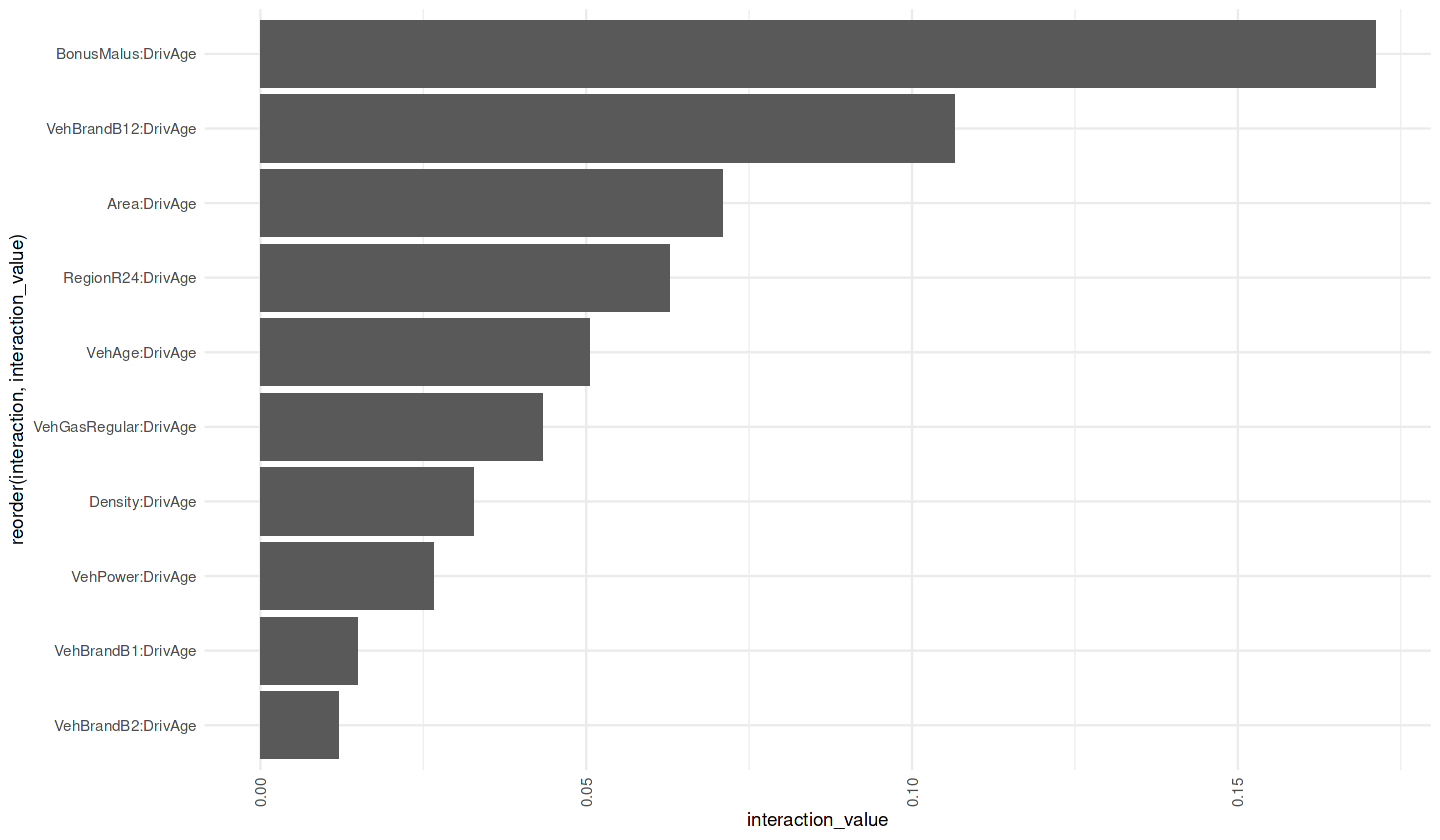

In [90]:
# Interactions: we use the explainer object from 3.4
inter.lgb.drivage <- as.data.frame(potential_interactions(shap_lgb_test, "DrivAge"))
names(inter.lgb.drivage)[1] <- "interaction_value"
# make new column "interaction" out of rownames and "DrivAge
inter.lgb.drivage$interaction <- paste0(rownames(inter.lgb.drivage), ":DrivAge")
# plot interaction_value top 10
inter.lgb.drivage %>% 
  arrange(desc(interaction_value)) %>% 
  head(10) %>% 
  ggplot(aes(x = reorder(interaction, interaction_value), y = interaction_value)) +
  geom_col() +
   coord_flip() +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

As we have already found out under 5.1, the most important interaction with the feature DriveAge is DriveAge:BonusMalus.

## 5.3 Friedmann's H-statistic

A classic approach to measuring interactions in models is Friedmann's H-statistic. In contrast the EIX-package mentioned above, this method is not restricted to certain model classes. Unfortunately, this method is also quite computationally intensive. Therefore we limit the calcultaion to the XGBoost model.

A nice introduction to this concept can be found in chapter 8 of the open-access book "Interpretable Machine Learning" by Chrisoph Molnar (2ed), see https://christophm.github.io/interpretable-ml-book/.

We use the flashlight-package for the calculation of Friedmann's H.

In [91]:
install.packages("flashlight")
library(flashlight)

# get names after one-hot-encoding
features_1 <- names(df_feat)

# create flashlight-object fpr xgboost model
fl_xgb <- flashlight(
  model = fit.xgb, 
  label = "XGBoost", 
  predict_function = function(fit, X) predict(fit, as.matrix(X[,c(features_1)]) ),
  data = cbind(X_test,"ClaimNb" = test$ClaimNb, "Exposure" = test$Exposure),
  y = "ClaimNb",
  w = "Exposure",
  linkinv = log,
  metrics = list(`Poisson Deviance` = PDW)
)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



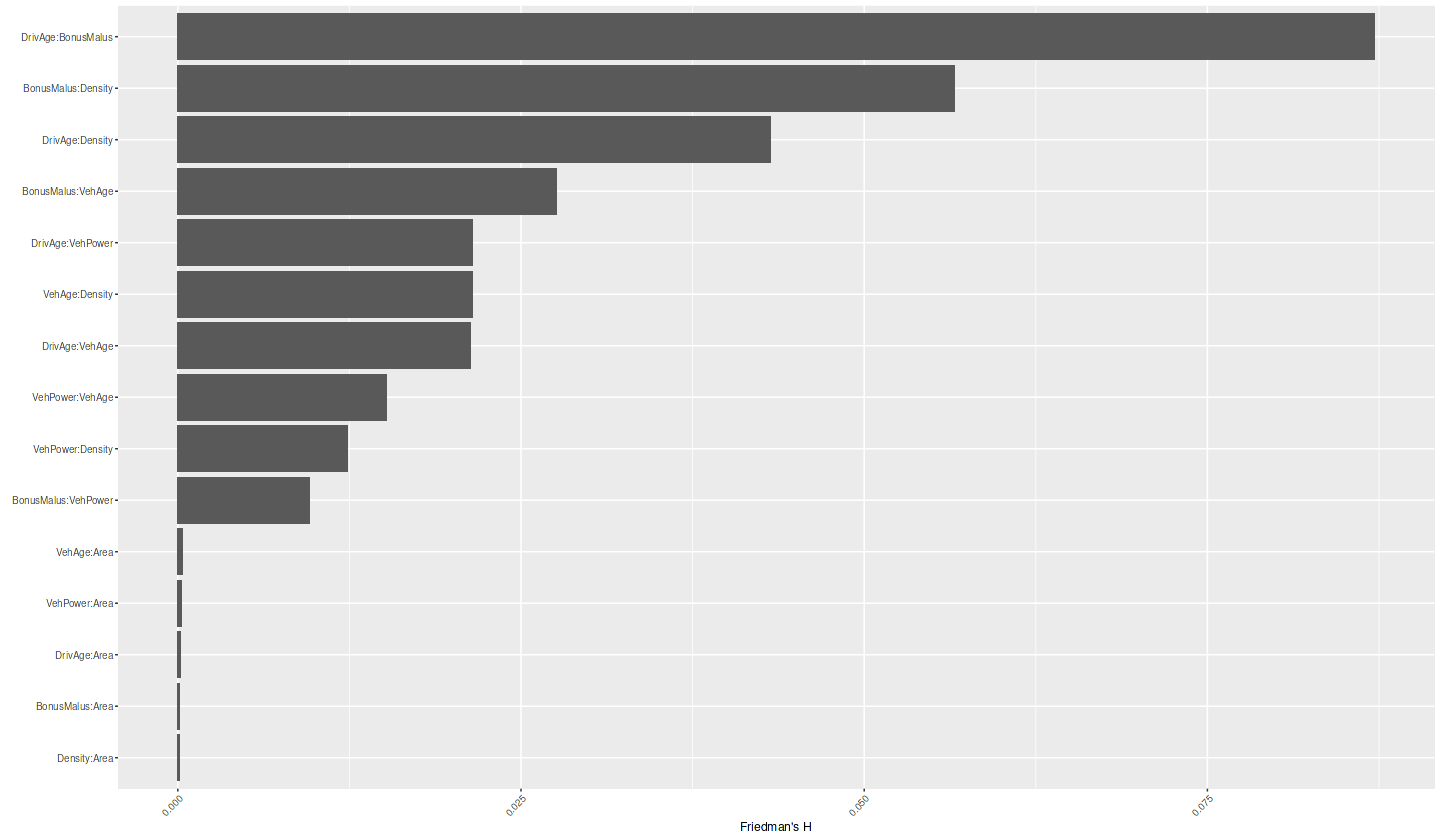

In [92]:
# Interaction (absolute)
interact_abs <- light_interaction(
  fl_xgb, 
  v = c("DrivAge", "BonusMalus" ,"VehPower" , "VehAge", "Density",  "Area"), 
  normalize = FALSE,
  pairwise = TRUE, 
  use_linkinv = TRUE,
  seed = 42
)
plot(interact_abs,  rotate_x = TRUE)

The evaluation of the interactions in the XGBoost model using Friedmann's H also confirms the results from 5.1 and 5.2: DriveAge:BonusMalus is the most important interaction.

## 5.4 Back to GLM and GAM
The aim of the previous sections was to find important interactions in the machine learning models. We will now use these interactions in the classical GLM. We have seen the high importance of the interaction DrivAge:BonusMalus in the previous sections. But other interactions also seem to be important. We will include these in the following GLMs. 
Finally, we transfer this approach to a Generalized Additive Model (GAM).

### 5.4.1 "GLM4" featuring neural net residual analyses

The interactions in this model were found using neural network residual analyzes, see "From Generalized Linear Models to Neural Networks, and Back" by Mario Wüthrich (SSRN-Preprint 3491790, 11.12.2019). Note: The interactions were developed on the basis of the original (unadjusted) data set.

In [93]:
f.glm4 <- "ClaimNb ~ AreaGLM + VehPowerGLM * VehAgeGLM + VehAgeGLM * VehBrand + VehGas * VehAgeGLM + DensityGLM + Region + BonusMalusGLM * log(DrivAge) + log(BonusMalusGLM) + I(BonusMalusGLM^2) + I(BonusMalusGLM^3) + I(BonusMalusGLM^4) + DrivAge + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)"
d.glm4 <- glm(f.glm4, data=learn, offset=log(Exposure), family=poisson())
summary(d.glm4)


Call:
glm(formula = f.glm4, family = poisson(), data = learn, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3657  -0.3203  -0.2415  -0.1379   6.9277  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -5.733e+02  5.585e+01 -10.265  < 2e-16 ***
AreaGLM                     2.379e-02  2.131e-02   1.117 0.264171    
VehPowerGLM5                5.468e-02  3.016e-02   1.813 0.069872 .  
VehPowerGLM6                9.540e-02  2.967e-02   3.215 0.001304 ** 
VehPowerGLM7                8.769e-02  2.984e-02   2.939 0.003296 ** 
VehPowerGLM8                1.178e-01  4.285e-02   2.748 0.005991 ** 
VehPowerGLM9                2.792e-01  3.317e-02   8.418  < 2e-16 ***
VehAgeGLM1                  1.347e-01  1.268e-01   1.062 0.288024    
VehAgeGLM3                 -1.253e-01  5.345e-02  -2.344 0.019102 *  
VehBrandB10                -6.811e-02  5.753e-02  -1.184 0.236418    
VehBrandB11   

In [94]:
learn$fitGLM4 <- fitted(d.glm4)
test$fitGLM4 <- predict(d.glm4, newdata=test, type="response")

# Print Poisson Deviance
PDW2('Poisson Deviance GLM4', learn$fitGLM4,learn$ClaimNb,learn$Exposure, test$fitGLM4,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GLM4", test$fitGLM4)

[1] "Poisson Deviance GLM4, Learn/Test: 29.25% / 29.23%"

[1] "GLM2-Improvement-Index (PD test) of GLM4: 117.5%"

Obviously, this is a major improvement compared to the Basic-GLM "GLM1" and "GLM2". We will see in the next paragraph, if the interactions we found can compete with that result.

### 5.4.2 "GLM5" Improved GLM with Interactions from XGBoost and LightGBM

The interactions in this model were found with XGBoost and LightGBM residual analyzes in 5.1 to 5.3 and are consistent with those developed based on the original (unadjusted) dataset, see version 2.

In [95]:
f.glm5 <- "ClaimNb ~ AreaGLM + VehPowerGLM * VehAgeGLM  + VehAgeGLM *VehBrand + VehGas * VehAgeGLM + DensityGLM + Region + BonusMalusGLM * log(DrivAge) +  VehAgeGLM *log(BonusMalusGLM) + I(BonusMalusGLM^2) + I(BonusMalusGLM^3) + I(BonusMalusGLM^4) + DrivAge * DensityGLM + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)"
d.glm5 <- glm(f.glm5, data=learn, offset=log(Exposure), family=poisson())
summary(d.glm5)


Call:
glm(formula = f.glm5, family = poisson(), data = learn, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4654  -0.3201  -0.2412  -0.1381   6.9668  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.783e+02  5.587e+01 -10.351  < 2e-16 ***
AreaGLM                        2.279e-02  2.131e-02   1.069 0.284917    
VehPowerGLM5                   5.356e-02  3.017e-02   1.775 0.075847 .  
VehPowerGLM6                   9.363e-02  2.968e-02   3.155 0.001605 ** 
VehPowerGLM7                   8.379e-02  2.986e-02   2.807 0.005008 ** 
VehPowerGLM8                   1.133e-01  4.287e-02   2.643 0.008229 ** 
VehPowerGLM9                   2.739e-01  3.320e-02   8.250  < 2e-16 ***
VehAgeGLM1                     2.592e+00  6.139e-01   4.223 2.41e-05 ***
VehAgeGLM3                    -1.416e+00  2.387e-01  -5.932 3.00e-09 ***
VehBrandB10                   -6.986e-02  5.753e-02  -

In [96]:
learn$fitGLM5 <- fitted(d.glm5)
test$fitGLM5 <- predict(d.glm5, newdata=test, type="response")

# Print Poisson Deviance
PDW2('Poisson Deviance GLM5', learn$fitGLM5,learn$ClaimNb,learn$Exposure, test$fitGLM5,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GLM5", test$fitGLM5)

[1] "Poisson Deviance GLM5, Learn/Test: 29.24% / 29.23%"

[1] "GLM2-Improvement-Index (PD test) of GLM5: 117.7%"

This GLM5 is marginally better than the GLM4. We now have two GLMs (basically the same as in version 2) with a PD improvement index around 118%. This is a significant improvement compared to the simple GLMs we have seen before.

However, it still lags far behind the gradient tree boosting models in Chapter 3. A look back at section 2.4 shows that the Generalized Additive Model GAM3 without interactions also performs comparably well, even slightly better: 

In [97]:
# For comparison: Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GAM3", test$fitGAM3)

[1] "GLM2-Improvement-Index (PD test) of GAM3: 120.0%"

### 5.4.3 "GAM6" Improved GAM with an Interaction

In extending GAM3, we only consider the apparent interaction between BonusMalus and driver age, which can be seen in the graphs in Section 2.4 and in the interaction analysis for GLMs above.

In [98]:
f.gam6 <- ClaimNb ~ s(VehAge) + s(DrivAge) + s(BonusMalusGLM,by=DrivAgeGLM) + VehPowerGLM + VehGas + VehBrand + AreaGLM + DensityGLM + Region + offset(log(Exposure))

{t1 <- proc.time()
    d.gam6 <- bam(f.gam6, data=learn, scale=-1, family=poisson)
(proc.time()-t1)}

summary(d.gam6)

   user  system elapsed 
240.646 136.177 112.505 


Family: poisson 
Link function: log 

Formula:
ClaimNb ~ s(VehAge) + s(DrivAge) + s(BonusMalusGLM, by = DrivAgeGLM) + 
    VehPowerGLM + VehGas + VehBrand + AreaGLM + DensityGLM + 
    Region + offset(log(Exposure))

Parametric coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -3.0593570  0.0541636 -56.484  < 2e-16 ***
VehPowerGLM5   0.0590283  0.0321402   1.837  0.06627 .  
VehPowerGLM6   0.0874747  0.0316043   2.768  0.00564 ** 
VehPowerGLM7   0.0917411  0.0312260   2.938  0.00330 ** 
VehPowerGLM8   0.1211168  0.0442987   2.734  0.00626 ** 
VehPowerGLM9   0.2597773  0.0350528   7.411 1.26e-13 ***
VehGasRegular -0.1569455  0.0196717  -7.978 1.49e-15 ***
VehBrandB10   -0.0345462  0.0589151  -0.586  0.55763    
VehBrandB11    0.1781177  0.0609407   2.923  0.00347 ** 
VehBrandB12   -0.2819149  0.0334868  -8.419  < 2e-16 ***
VehBrandB13   -0.0020923  0.0666172  -0.031  0.97494    
VehBrandB14   -0.3024244  0.1363983  -2.217  0.02661 *  
VehBrandB2    -0

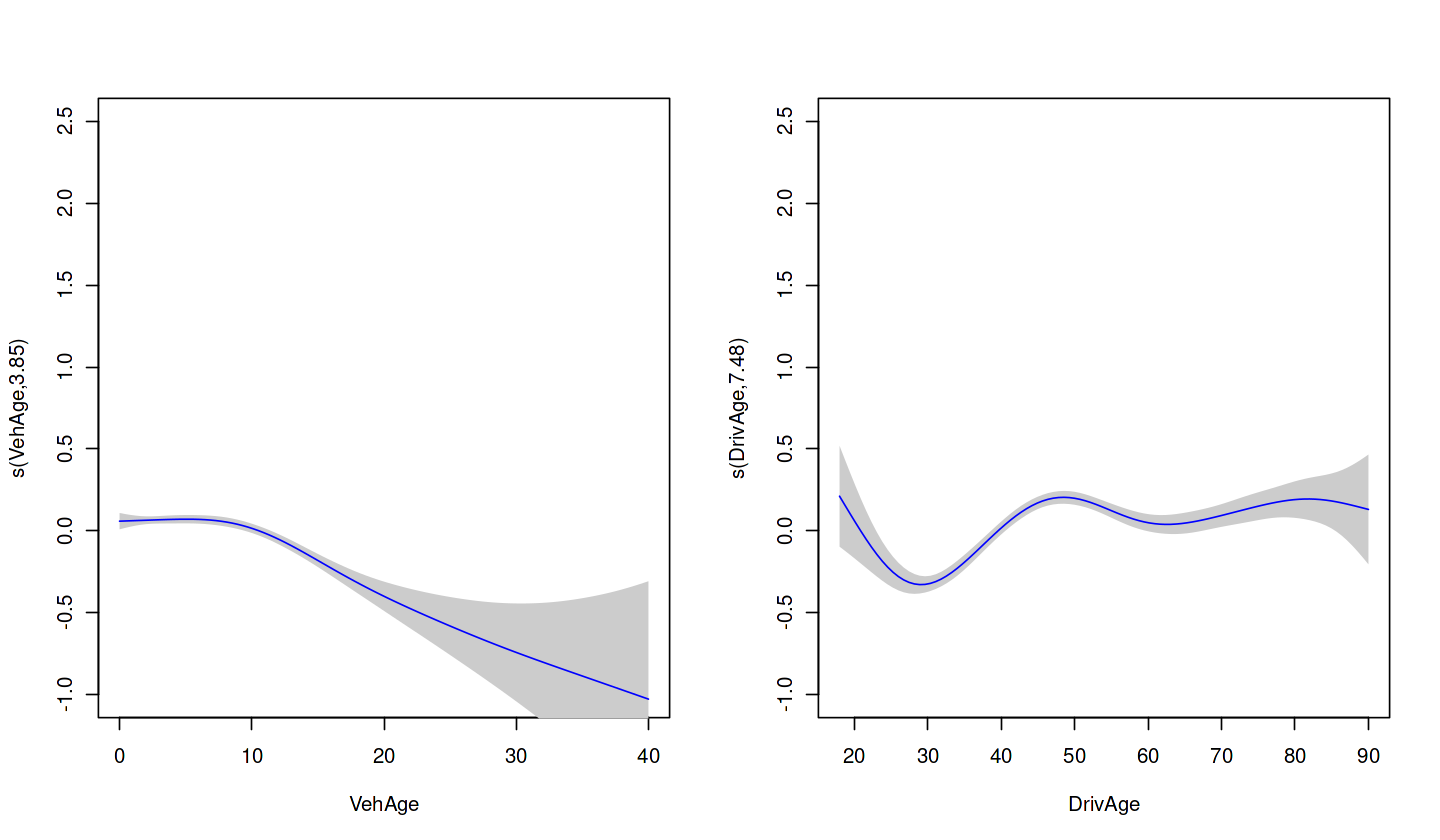

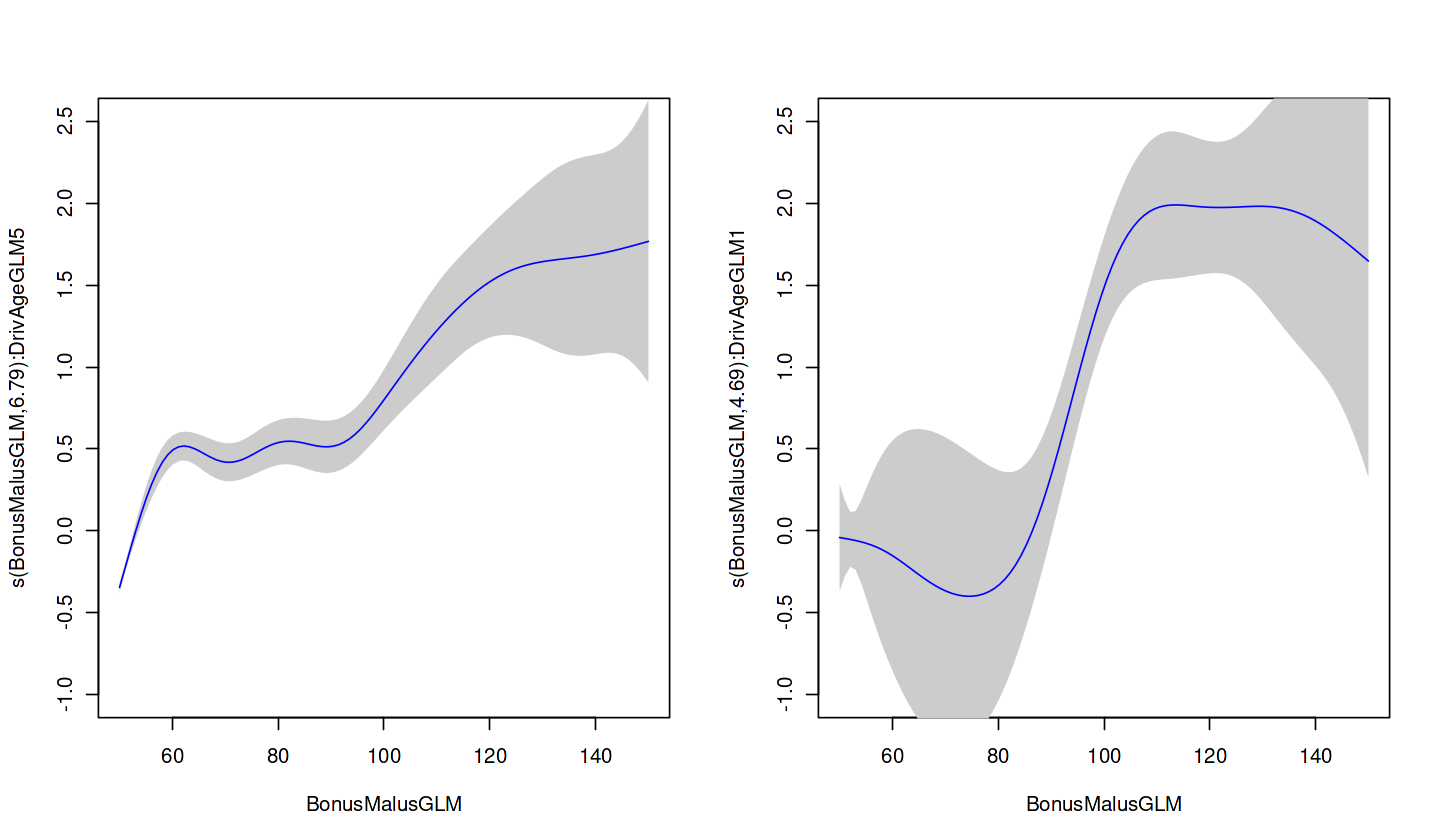

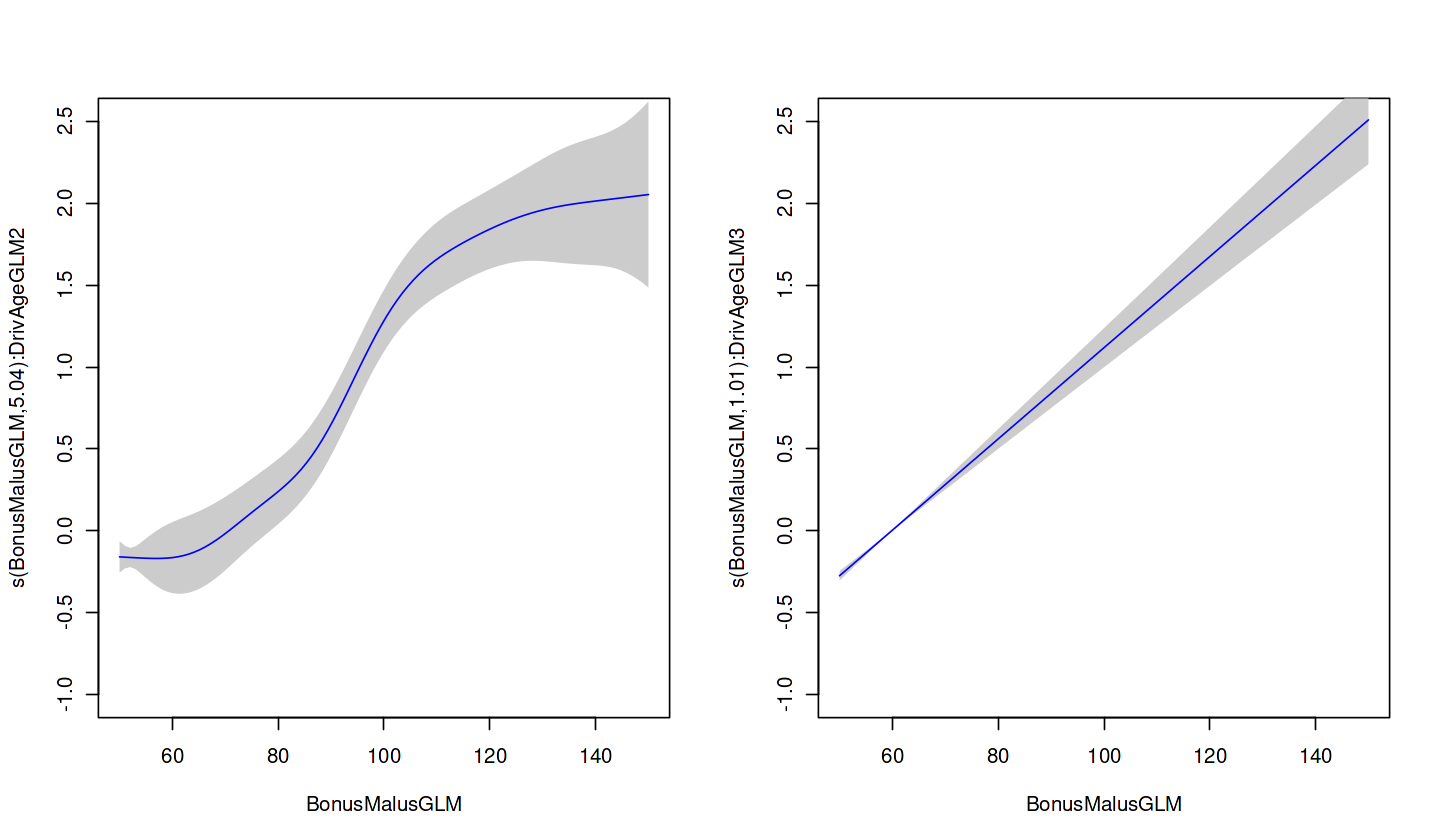

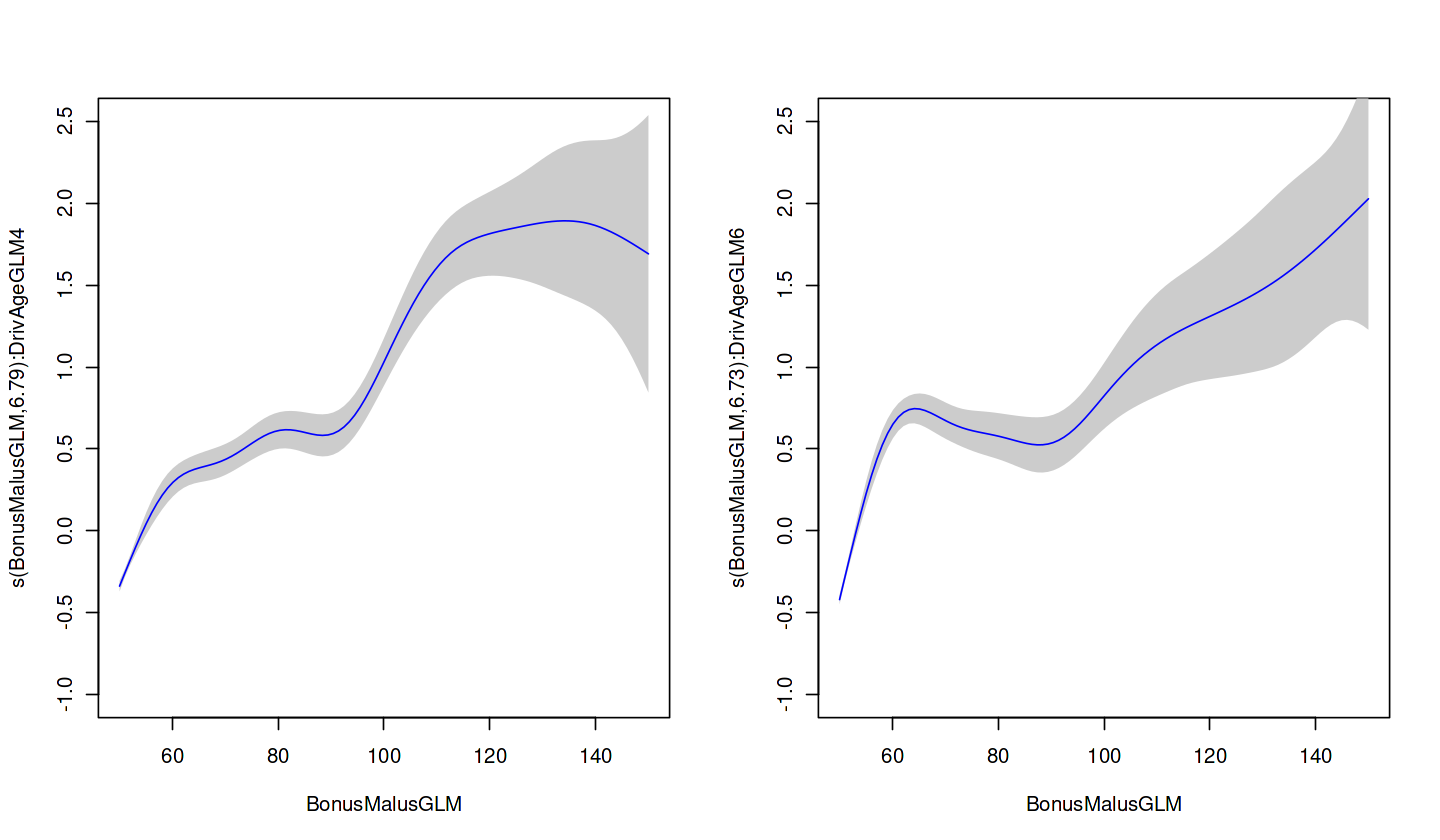

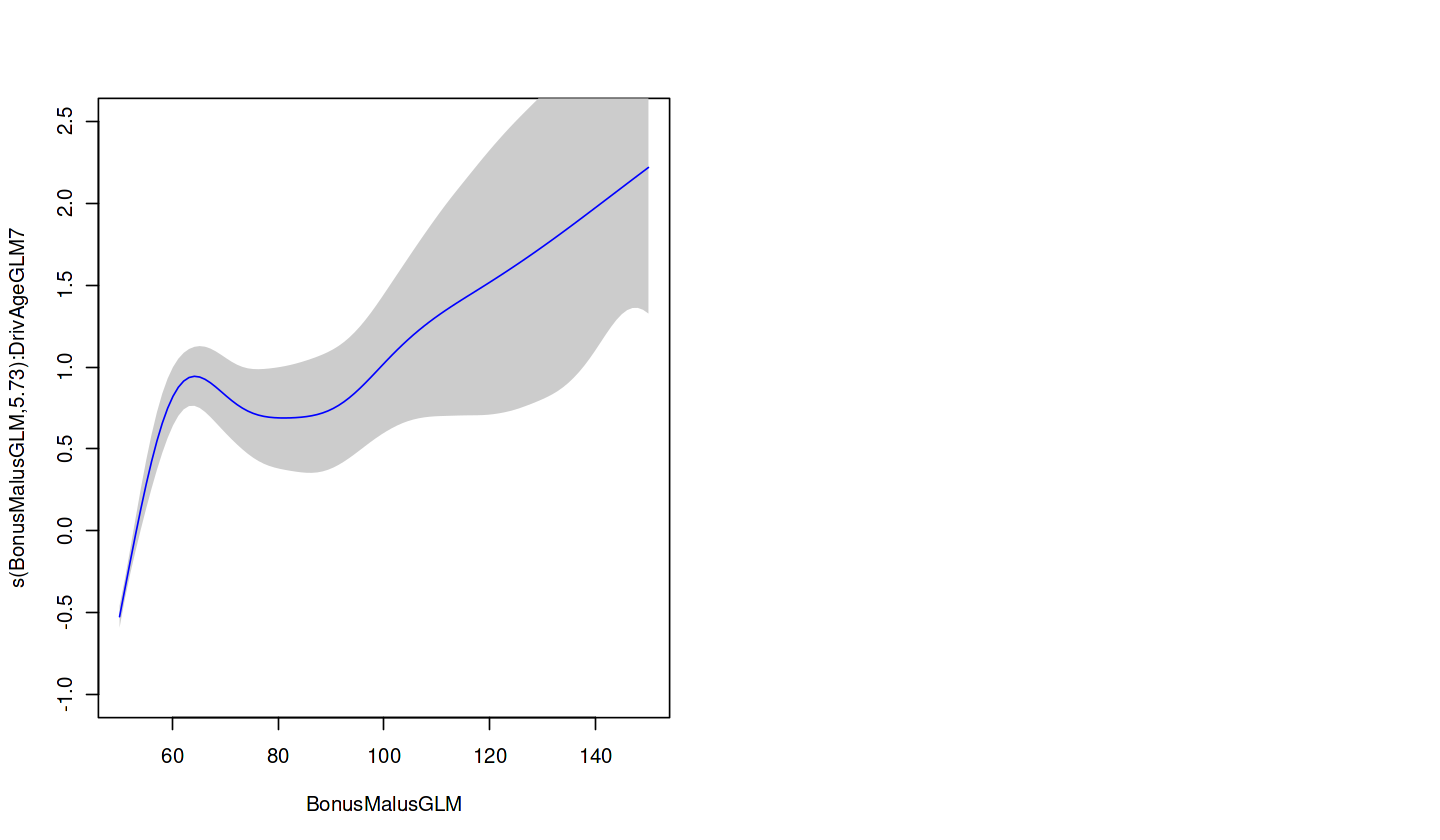

In [99]:
# Visualization of the fitted spline functions
plot(d.gam6, col = 'blue', shade=TRUE, ylim = c(-1.0,2.5), pages=5) 

As we can see, the adjusted BonusMalus function does not increase monotonically.

In [100]:
# Model performance: Improved GAM with an Interaction

learn$fitGAM6 <- fitted(d.gam6)
test$fitGAM6 <- predict(d.gam6, newdata=test, type="response")

# Print Poisson Deviance
PDW2('Poisson Deviance GAM6', learn$fitGAM6,learn$ClaimNb,learn$Exposure, test$fitGAM6,test$ClaimNb,test$Exposure)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GAM6", test$fitGAM6)

[1] "Poisson Deviance GAM6, Learn/Test: 29.12% / 29.13%"

[1] "GLM2-Improvement-Index (PD test) of GAM6: 124.3%"

The GAM, extended by a single interaction, is performing best in this comparison while being fast enough and again shows the potential of other methods related to the GLM. It is a similar but regularized approach to modeling curves as with the polynomials for driver age and BonusMalus in GLM4 and GLM5. If required for the application, the spline functions could be replaced by a series of class values or an approximate polynomial.

<a id="ch6"></a>
# 6. Cross Validation and Boxplots: Results

So far we have trained the models once at 80% of all policies and tested it on a hold-out data set consisting of 20% of all policies. The results could be a bit arbitrary. We don't know if our models generalize well with respect to other test data.

In Chapter 1.6 we have already divided the data into five parts, which are called folds. Up to now we used fold no. 5 for testing. Now we repeat this for all five folds. This is called cross validation and considered the best way to avoid over-fitting.

In the following, we restrict ourselves to the optimized classical models from Chapter 5 and the gradient boosting models from Chapter 3. The latter performed best, even when strong monotonicity constraints for plausible tariff structures are taken into account. This was not the case with the neural networks, which are also significantly more complex to implement.

In [101]:
# k folds as defined in Ch. 1.6
{t1 <- proc.time()

PD.test.INT  <- vector() # initialize PD-test-folds-vector
PD.test.GLM2 <- vector() # 
PD.test.GLM4 <- vector() 
PD.test.GLM5 <- vector() 
PD.test.GAM6 <- vector()  
PD.test.ML_CB0  <- vector() 
PD.test.ML_CB1 <- vector() 
PD.test.ML_LGB0 <- vector() 
PD.test.ML_LGB1 <- vector() 
PD.test.ML_XGB0 <- vector() 
PD.test.ML_XGB1 <- vector() 

for (i in 1:k) {
    learn <- dat1[dat1$fold != i,]
    test  <- dat1[dat1$fold == i,]
    (n_l <- nrow(learn))
    (n_t <- nrow(test))
    df_feat <- dat[,c(features)]
    df_feat$Area <- as.integer(df_feat$Area)
    df_feat <- as.data.frame(model.matrix( ~ 0 +. ,data = df_feat)) 
    X_learn <- df_feat[dat1$fold != i,]    # 80%
    X_test  <- df_feat[dat1$fold == i,]    # 20%

    ### Model INT (intercept-only).  No model, just average claim frequency
    (cf <- sum(learn$ClaimNb)/sum(learn$Exposure))
    test$fit.cf <- cf*test$Exposure
    # out-of-sample losses (in 10^(-2))
    PD.test.INT[i] <- PDW(test$fit.cf, test$ClaimNb, test$Exposure)
    
    ### Model GLM2: Basic GLM without interactions
    GLM2 <- glm(f.glm2, data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM2 <- predict(GLM2, newdata=test, type="response")
    PD.test.GLM2[i] <- PDW(test$fitGLM2, test$ClaimNb, test$Exposure)

    ### Model GLM4: Featuring neural net residual analyses
    GLM4 <- glm(f.glm4, data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM4 <- predict(GLM4, newdata=test, type="response")
    PD.test.GLM4[i] <- PDW(test$fitGLM4, test$ClaimNb, test$Exposure)
    
    ### Model GLM5: Improved GLM with Interactions from XGBoost
    GLM5 <- glm(f.glm5, data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM5 <- predict(GLM5, newdata=test, type="response")
    PD.test.GLM5[i] <- PDW(test$fitGLM5, test$ClaimNb, test$Exposure)
    
    ### Model GAM6: Generalized Additive Model (3 splines and a single interaction)
    GAM6 <- bam(f.gam6, data=learn, scale=-1, family=poisson)
    test$fitGAM6 <- predict(GAM6, newdata=test, type="response")
    PD.test.GAM6[i] <- PDW(test$fitGAM6, test$ClaimNb, test$Exposure)
   
    ### CatBoost-Models:
    learn_pool <- catboost.load_pool(data = learn[features], label = learn$ClaimNb, 
                     cat_features = cat_features, baseline = as.matrix(learn$Exposure))
    test_pool <- catboost.load_pool(data = test[features], label = test$ClaimNb, 
                     cat_features = cat_features, baseline = as.matrix(test$Exposure))
    # CB0: Unconstraint 
    CB0_params <- list(logging_level='Silent', loss_function='Poisson', random_seed=42,
                      iterations = 500, learning_rate = 0.15, depth = 3)
    CB0 <- catboost.train(learn_pool, params = CB0_params) 
    test$fitCB0 <- exp(catboost.predict(CB0,test_pool))
    PD.test.ML_CB0[i] <- PDW(test$fitCB0, test$ClaimNb, test$Exposure)
    # CB1: Constraint 
    CB1_params <- list(logging_level='Silent', loss_function='Poisson', 
                      monotone_constraints = mtcc, random_seed=42,
                      iterations = 500, learning_rate = 0.15, depth = 3)
    CB1 <- catboost.train(learn_pool, params = CB1_params) 
    test$fitCB1 <- exp(catboost.predict(CB1,test_pool))
    PD.test.ML_CB1[i] <- PDW(test$fitCB1, test$ClaimNb, test$Exposure)

    ### LightGBM-Models:
    llearn <- lgb.Dataset(data = data.matrix(X_learn), 
                          label = learn$ClaimNb/learn$Exposure, weight=learn$Exposure)
    # LGB0: Unconstraint 
    LGB0 <- lgb.train(data=llearn, objective='poisson',
                      num_leaves=31, learning_rate=0.1, n_estimators=100)
    test$fitLGB0 <- predict(LGB0, data.matrix(X_test)) * test$Exposure
    PD.test.ML_LGB0[i] <- PDW(test$fitLGB0, test$ClaimNb, test$Exposure)
    # LGB1: Constraint 
    LGB1 <- lgb.train(data=llearn, objective='poisson', monotone_constraints = mtc,
                      num_leaves=31, learning_rate=0.1, n_estimators=100)
    test$fitLGB1 <- predict(LGB1, data.matrix(X_test)) * test$Exposure
    PD.test.ML_LGB1[i] <- PDW(test$fitLGB1, test$ClaimNb, test$Exposure)

    ### XGBoost-Models:  
    dlearn <- xgb.DMatrix(data = data.matrix(X_learn),
                          label = learn$ClaimNb/learn$Exposure, weight=learn$Exposure)
    dtest <- xgb.DMatrix(data = data.matrix(X_test), 
                         label = test$fold, weight=test$Exposure)
    # XGB0: Unconstraint 
    XGB0 <- xgb.train(data=dlearn, objective='count:poisson', 
                      nrounds = 500, max_depth = 5, eta = 0.05, tree_method = "hist")
    test$fitXGB0 <- predict(XGB0, newdata = dtest) * test$Exposure
    PD.test.ML_XGB0[i] <- PDW(test$fitXGB0, test$ClaimNb, test$Exposure)  
    # XGB1: Constraint
    XGB1 <- xgb.train(data=dlearn, objective='count:poisson', monotone_constraints = mtc, 
                      nrounds = 500, max_depth = 5, eta = 0.05, tree_method = "hist")
    test$fitXGB1 <- predict(XGB1, newdata = dtest) * test$Exposure
    PD.test.ML_XGB1[i] <- PDW(test$fitXGB1, test$ClaimNb, test$Exposure)
}
k
(proc.time()-t1)}

Model shrinkage in combination with baseline column is not implemented yet. Reset model_shrink_rate to 0.
Model shrinkage in combination with baseline column is not implemented yet. Reset model_shrink_rate to 0.
Model shrinkage in combination with baseline column is not implemented yet. Reset model_shrink_rate to 0.
Model shrinkage in combination with baseline column is not implemented yet. Reset model_shrink_rate to 0.
Model shrinkage in combination with baseline column is not implemented yet. Reset model_shrink_rate to 0.


    user   system  elapsed 
8582.540 1200.821 2790.050 

## 6.1 Repeat modeling k-times

In [102]:
# write vectors in a Data Frame
df <- data.frame(1:5,PD.test.INT,PD.test.GLM2,PD.test.GLM4,PD.test.GLM5,PD.test.GAM6,
                 PD.test.ML_CB0,PD.test.ML_CB1,PD.test.ML_LGB0,PD.test.ML_LGB1,
                 PD.test.ML_XGB0,PD.test.ML_XGB1)
names(df) <- c("fold","INT","GLM2","GLM4","GLM5","GAM6","CatBoost","CatBoost_mc",
               "LightGBM","LightGBM_mc","XGBoost","XGBoost_mc")
# calculate GLM2-Improvement-Index
df.idx <- df
df.idx$GLM4 <- round(((df$GLM4 - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$GLM5 <- round(((df$GLM5 - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$GAM6 <- round(((df$GAM6 - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$CatBoost <- round(((df$CatBoost - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$CatBoost_mc <- round(((df$CatBoost_mc - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$LightGBM <- round(((df$LightGBM - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$LightGBM_mc <- round(((df$LightGBM_mc - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$XGBoost <- round(((df$XGBoost - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$XGBoost_mc  <- round(((df$XGBoost_mc - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx

fold INT      GLM2     GLM4   GLM5   GAM6   CatBoost CatBoost_mc LightGBM
1 1    31.12465 29.44236 113.76 114.71 121.24 145.29   128.06      147.98  
2 2    31.26807 29.63421 115.26 116.16 123.91 149.35   124.18      153.55  
3 3    31.44854 29.83801 119.75 120.46 128.31 156.94   130.66      158.93  
4 4    30.90379 29.29171 116.51 117.12 122.62 152.34   130.86      151.45  
5 5    31.09465 29.51152 117.54 117.74 124.28 149.12   129.79      151.20  
  LightGBM_mc XGBoost XGBoost_mc
1 132.63      147.13  131.95    
2 132.67      154.52  133.29    
3 137.83      154.95  136.37    
4 134.86      149.42  134.96    
5 134.55      149.00  133.85

## 6.2 Plot Poisson Deviance for each fold

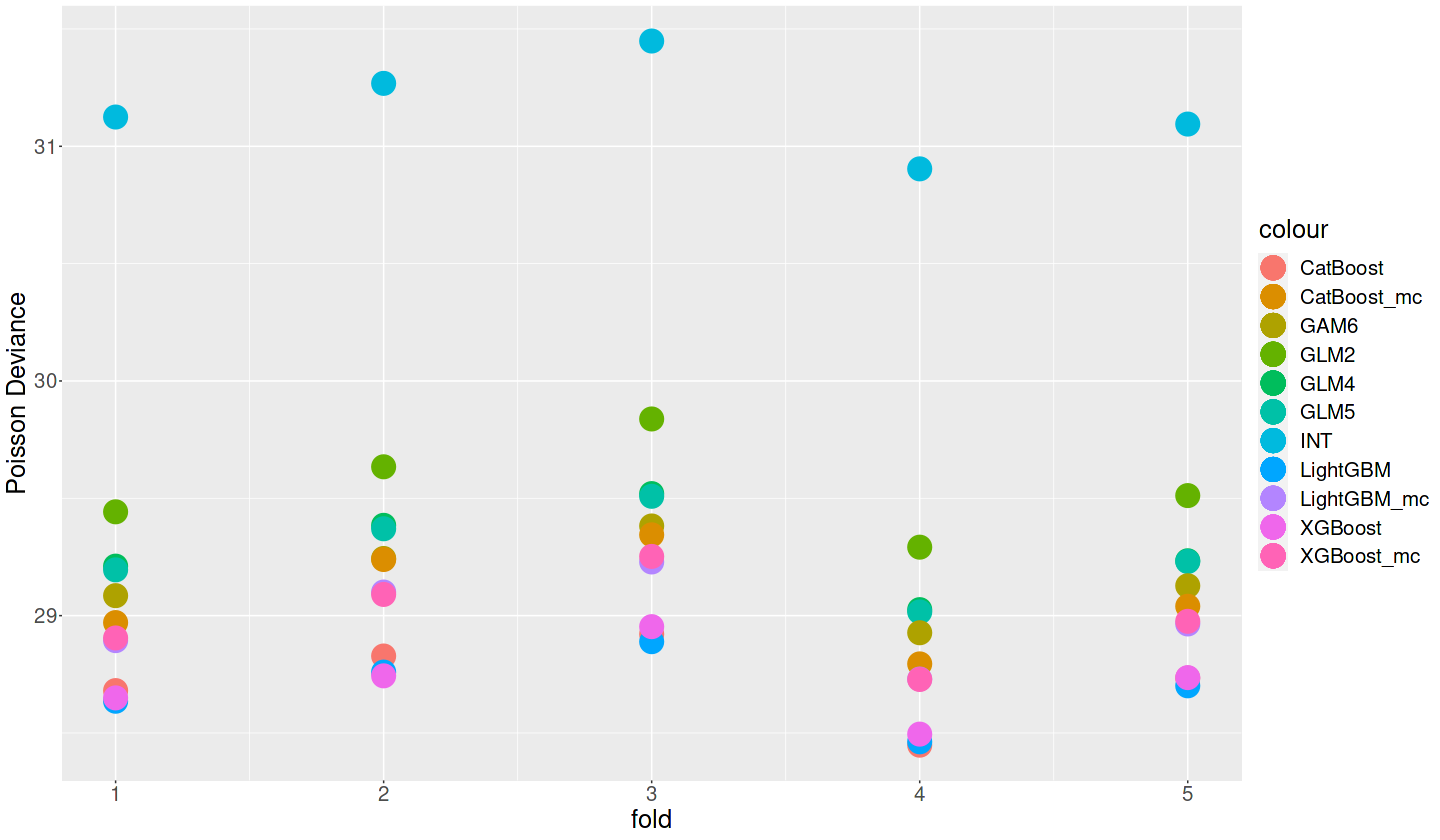

In [103]:
ggplot(df, aes(fold)) + 
  geom_point(aes(y = INT,  colour = "INT"),  size=6) + 
  geom_point(aes(y = GLM2, colour = "GLM2"), size=6) + 
  geom_point(aes(y = GLM4, colour = "GLM4"), size=6) + 
  geom_point(aes(y = GLM5, colour = "GLM5"), size=6) + 
  geom_point(aes(y = GAM6, colour = "GAM6"), size=6) + 
  geom_point(aes(y = CatBoost,    colour = "CatBoost"),    size=6) + 
  geom_point(aes(y = CatBoost_mc, colour = "CatBoost_mc"), size=6) + 
  geom_point(aes(y = LightGBM,    colour = "LightGBM"),    size=6) + 
  geom_point(aes(y = LightGBM_mc, colour = "LightGBM_mc"), size=6) + 
  geom_point(aes(y = XGBoost,     colour = "XGBoost"),     size=6) + 
  geom_point(aes(y = XGBoost_mc,  colour = "XGBoost_mc"),  size=6) + 
  ylab("Poisson Deviance") + theme(text = element_text(size=15))

## 6.3 Plot GLM2-Improvement-Index: Final Results

Since a substantial part of the uncertainty is caused by differences between folds we calculate the relative improvement with respect to the models INT ("no model") and our benchmark-model GLM2: 

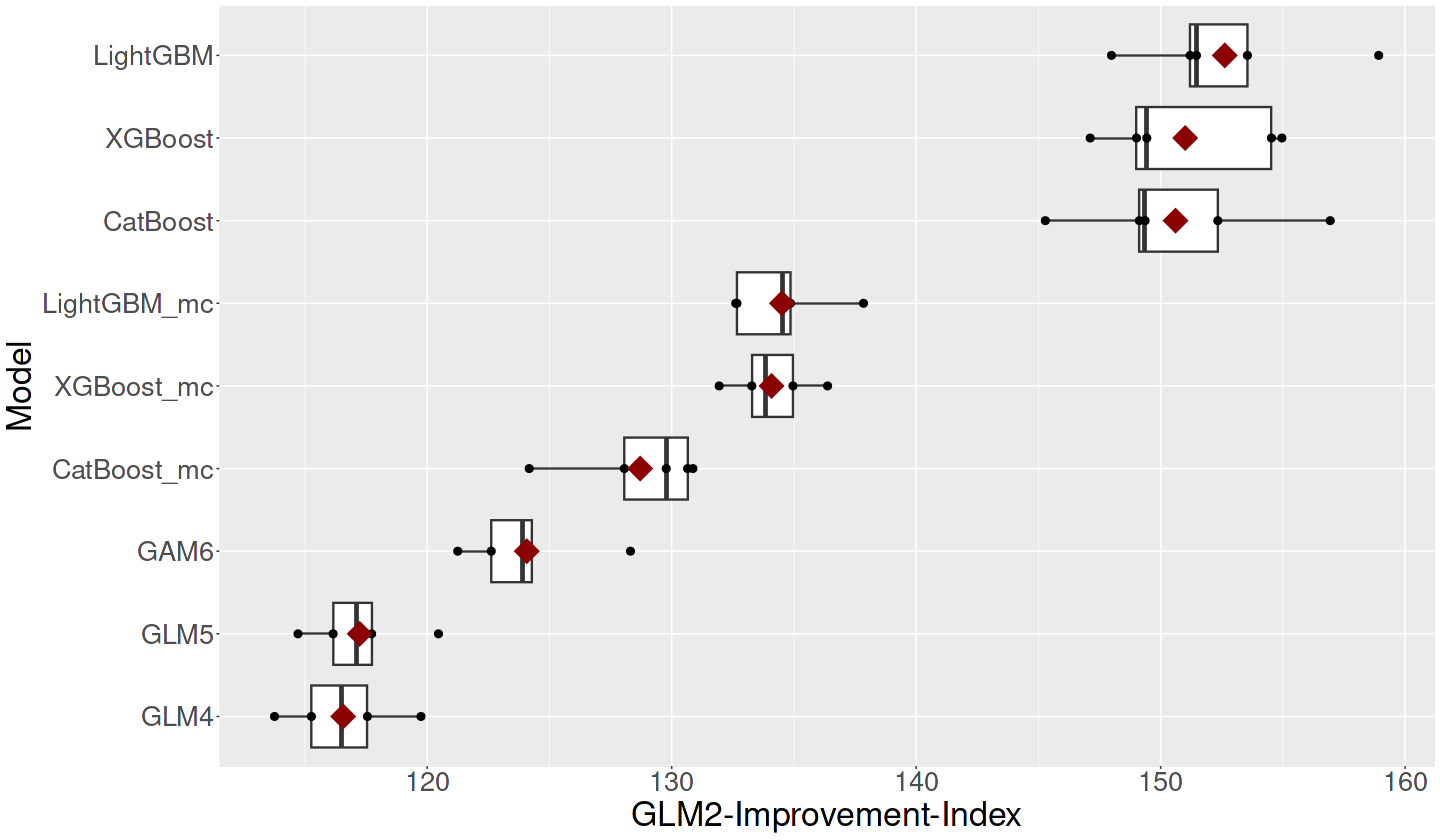

In [104]:
df.idx  %>% select(fold, GLM4, GLM5, GAM6, CatBoost, CatBoost_mc,
                      LightGBM, LightGBM_mc, XGBoost, XGBoost_mc) %>% 
  gather(model, PD, GLM4, GLM5, GAM6, CatBoost, CatBoost_mc,
                 LightGBM, LightGBM_mc, XGBoost, XGBoost_mc) %>% 
  ggplot(aes(x = fct_reorder(model, PD, mean), y=PD)) +
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(width = 0) +
    stat_summary(fun = mean, colour="darkred", geom="point",shape=18, size=7) +
    coord_flip() +
    xlab("Model") + 
    ylab("GLM2-Improvement-Index") + 
    theme(text = element_text(size=20))

The boxplots confirm and complement the results already seen above in Chapters 3 and 5. The three gradient boosting models LightGBM, XGBoost and Catboost achieve by far the best model quality, with LightGBM having a small lead. The monotonicity constraint (_mc) regarding the most important feature BonusMalus reduces the model quality considerably, especially for CatBoost_mc. Among the generalized linear or additive models, GAM6 performs best by some margin, while GLM4 and GLM5 can only achieve a relatively modest improvement of about 15% over the basic GLM2, although they are not monotonicity constrained and therefore fall far behind in direct comparison with the unconstrained gradient boosting models (that lead to an improvement of a good 50%).

A direct comparison with the results from version 2 of this notebook shows a decline in model performance. This is caused by the cleansing of inconsistent claims data in this new version. The strong pattern that is easily recognizable to the models is now missing; the data picture has become more blurrier, so to speak.

<a id="ch7"></a>
# 7. Summary

In summary, it can be stated that in the data set examined here, the gradient boosting models prove to be the superior forecasting models, even taking into account the tariff system. XGBoost continues to do very well, but has to pass the crown to the even better and, above all, much faster LightGBM. To ensure interpretability, SHAP, which builds on game theory, was used to demonstrate how the decisions of LightGBM can be explained globally and locally.

While industry standard GLMs did perform worst (as well as regularized GLMs), generalized additive models, which can be viewed as smooth extensions of GLMs, worked remarkably well and should be considered for similar data with interesting nonlinear metric features.

Neural networks with two-dimensional embeddings, which can be visualized nicely, have been shown to provide similar model performance to GAMs, but are much more complicated to implement.

On our journey through the world of machine learning methods, we curiously started with deep learning and ended with powerful gradient boosting.

<br>

### References
 
Faraway, J. J. (2016), "Extending the Linear Model with R" (https://julianfaraway.github.io/faraway/ELM/) 

Hastie, T., Tibshirani, R. (1984), "Generalized Additive Models", SLAC PUB-3531: https://www.slac.stanford.edu/pubs/slacpubs/3500/slac-pub-3531.pdf

James et al., "An Introduction to Statistical Learning", 2ed, 2021-2023. Available in two versions with R or Python examples, see https://www.statlearning.com/

Mayer, M., Meier, D., Wüthrich, M. V. (2023), "SHAP for Actuaries: Explain any Model": https://github.com/actuarial-data-science/Tutorials/tree/master/14%20-%20SHAP

Schelldorfer, J., Wüthrich, M. V. (2019) "Nesting Classical Actuarial Models into Neural Networks", SSRN-Preprint 3320525 (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525).

Wüthrich, M. V., Merz, M. (2023) "Statistical Foundations of Actuarial Learning and its Applications" (open-access book: https://link.springer.com/book/10.1007/978-3-031-12409-9)

<br>

<br>

In [105]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] flashlight_0.9.0 EIX_1.2.0        keras_2.13.0     kernelshap_0.4.1
 [5] shapviz_0.9.3    lightgbm_2.3.1   R6_2.5.1         catboost_0.23.2 
 [9] xgboost_1.7.6.1  ggeffects_1.3.2  mgcv_1.9-0       nlme_3.1-164    
[13] glmnet_4.1-8     Matrix_1.6-4 